In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import time
import argparse
import pickle
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse import coo_matrix
# from model import MDANet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())



import sys
import logging
import numpy as np


def get_logger(filename):
    # Logging configuration: set the basic configuration of the logging system
    log_formatter = logging.Formatter(fmt='%(asctime)s [%(processName)s, %(process)s] [%(levelname)-5.5s]  %(message)s',
                                      datefmt='%m-%d %H:%M')
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    # File logger
    file_handler = logging.FileHandler("{}.log".format(filename))
    file_handler.setFormatter(log_formatter)
    file_handler.setLevel(logging.DEBUG)
    logger.addHandler(file_handler)
    # Stderr logger
    std_handler = logging.StreamHandler(sys.stdout)
    std_handler.setFormatter(log_formatter)
    std_handler.setLevel(logging.DEBUG)
    logger.addHandler(std_handler)
    return logger


def data_loader(inputs, targets, batch_size, shuffle=True):
    assert inputs.shape[0] == targets.shape[0]
    inputs_size = inputs.shape[0]
    if shuffle:
        random_order = np.arange(inputs_size)
        np.random.shuffle(random_order)
        inputs, targets = inputs[random_order, :], targets[random_order]
    num_blocks = int(inputs_size / batch_size)
    for i in range(num_blocks):
        yield inputs[i * batch_size: (i+1) * batch_size, :], targets[i * batch_size: (i+1) * batch_size]
    if num_blocks * batch_size != inputs_size:
        yield inputs[num_blocks * batch_size:, :], targets[num_blocks * batch_size:]


def multi_data_loader(inputs, targets, batch_size, shuffle=True):
    """
    Both inputs and targets are list of numpy arrays, containing instances and labels from multiple sources.
    """
    assert len(inputs) == len(targets)
    input_sizes = [data.shape[0] for data in inputs]
    max_input_size = max(input_sizes)
    num_domains = len(inputs)
    if shuffle:
        for i in range(num_domains):
            r_order = np.arange(input_sizes[i])
            np.random.shuffle(r_order)
            inputs[i], targets[i] = inputs[i][r_order, :], targets[i][r_order]
    num_blocks = int(max_input_size / batch_size)
    for j in range(num_blocks):
        xs, ys = [], []
        for i in range(num_domains):
            ridx = np.random.choice(input_sizes[i], batch_size)
            xs.append(inputs[i][ridx, :])
            ys.append(targets[i][ridx])
        yield xs, ys
        
def weighted_jmmd(source, target):
    loss = torch.mean(torch.stack([JAN_Linear(source[i], target) for i in range(len(source))]))
    return loss

True


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

def EntropyLoss(input_):
    mask = input_.ge(0.000001)
    mask_out = torch.masked_select(input_, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out)))
    return entropy / float(input_.size(0))

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)

    
def JAN(source_list, target_list, kernel_muls=[2.0, 2.0], kernel_nums=[1, 1], fix_sigma_list=[None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = guassian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if i==0:
            joint_kernels=torch.ones_like(kernels)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    loss1 = 0
    for s1 in range(batch_size):
        for s2 in range(s1 + 1, batch_size):
            t1, t2 = s1 + batch_size, s2 + batch_size
            loss1 += joint_kernels[s1, s2] + joint_kernels[t1, t2]
    loss1 = loss1 / float(batch_size * (batch_size - 1) / 2)

    loss2 = 0
    for s1 in range(batch_size):
        for s2 in range(batch_size):
            t1, t2 = s1 + batch_size, s2 + batch_size
            loss2 -= joint_kernels[s1, t2] + joint_kernels[s2, t1]
    loss2 = loss2 / float(batch_size * batch_size)
    return loss1 + loss2

def JAN_Linear(source_list, target_list, kernel_muls=[2.0, 2.0], kernel_nums=[2, 1], fix_sigma_list=[None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = guassian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if i==0:
            joint_kernels=torch.ones_like(kernels)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    # Linear version
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1)%batch_size
        t1, t2 = s1+batch_size, s2+batch_size
        loss += joint_kernels[s1, s2] + joint_kernels[t1, t2]
        loss -= joint_kernels[s1, t2] + joint_kernels[s2, t1]
    return loss / float(batch_size)

In [4]:
from sklearn.metrics import  zero_one_loss,mean_absolute_error,r2_score, mean_squared_error
from math import sqrt
def get_mae(target, prediction):
    assert (target.shape == prediction.shape)

    return mean_absolute_error(target, prediction)

def get_mse(target, prediction):
    assert (target.shape == prediction.shape)

    return mean_squared_error(target, prediction)

def get_sae(target, prediction):
    assert (target.shape == prediction.shape)

    r = target.sum()
    r0 = prediction.sum()
    sae = abs(r0 - r) / r
    return sae

def get_nde(target, prediction):
    assert (target.shape == prediction.shape)

    error, squarey = [], []
    for i in range(len(prediction)):
        value = prediction[i] - target[i]
        error.append(value * value)
        squarey.append(target[i] * target[i])
    nde = sqrt(sum(error) / sum(squarey))
    return nde



In [5]:
###############################################Regression########################################################
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import logging
import torch
import torch.nn as nn
import torch.nn.functional as F


logger = logging.getLogger(__name__)

def weighted_mse(outputs,alpha):
    """
    Spectral Norm Loss between one source and one target: ||output^T*output-target^T*target||_2
    Inputs:
        - output: torch.Tensor, source distribution
        - target: torch.Tensor, target distribution
    Output:
        - loss: float, value of the spectral norm of the difference of covariance matrix
        
    """
    loss = torch.sum(torch.stack([alpha[i]*outputs[i] for i in range(len(outputs))]))
    return loss

class GradientReversalLayer(torch.autograd.Function):
    """
    Implement the gradient reversal layer for the convenience of domain adaptation neural network.
    The forward part is the identity function while the backward part is the negative function.
    """

    @staticmethod
    def forward(ctx, inputs):
        ctx.save_for_backward(inputs)
        return inputs
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        grad_input = -grad_input
        return grad_input

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    

class MDANet(nn.Module):
    """
    Multi-layer perceptron with adversarial regularizer by domain classification.
    """
    def __init__(self, configs):
        
        super(MDANet, self).__init__()
        self.input_dim = configs["input_dim"]
        self.num_domains = configs["num_domains"]
        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.BatchNorm1d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        def conv(in_feat, out_feat, filter_size=5, stride=1,padding=True):
            if padding==True: 
                p=int((filter_size-1)/2)
            else:
                p=0
            conv_layers = [nn.Conv1d(in_feat, out_feat,filter_size,stride,padding=p)]
            conv_layers.append(nn.LeakyReLU(0.2, inplace=True))
            return conv_layers

        def flat():
            flatten=Flatten()
            layers = [flatten]
            #layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.g1 = nn.Sequential(
            *conv(in_feat=1,out_feat=30,filter_size=10,stride=1,padding=True),            
        )
        
        self.g2 = nn.Sequential(
            *conv(in_feat=30,out_feat=30,filter_size=8,stride=1,padding=True),
        )
        
        self.g3= nn.Sequential(
            *conv(in_feat=30,out_feat=40,filter_size=6,stride=1,padding=True),
        )
        
        self.g4= nn.Sequential(
            *conv(in_feat=40,out_feat=50,filter_size=5,stride=1,padding=True),

        )
        
        self.g5= nn.Sequential(
            *conv(in_feat=50,out_feat=50,filter_size=5,stride=1,padding=True),           
            *flat(),
        )

        self.g6 = nn.Sequential(
#             *block(4800, 1024),
              *block(800, 1024),
        )
        
        self.softmax = nn.Linear(1024, 1)
        
        self.domains = nn.ModuleList([nn.Linear(1024, 2) for _ in range(self.num_domains)])
        # Gradient reversal layer.
        self.grls = [GradientReversalLayer() for _ in range(self.num_domains)]
        self.register_parameter(name='alpha', param=torch.nn.Parameter(torch.Tensor(np.ones(self.num_domains)/self.num_domains)) )
        
             
    def forward(self, sinputs, tinputs):
        """
        :param sinputs:     A list of k inputs from k source domains.
        :param tinputs:     Input from the target domain.
        :return:
        """
        sh_relu, th_relu = sinputs.copy(), tinputs.clone()
        for i in range(self.num_domains):
            sh_relu[i] = self.g1(sh_relu[i])
            sh_relu[i] = self.g2(sh_relu[i])
            sh_relu[i] = self.g3(sh_relu[i])
            sh_relu[i] = self.g4(sh_relu[i])
            sh_relu[i] = self.g5(sh_relu[i])
            sh_relu[i] = self.g6(sh_relu[i])

            
        th_relu = self.g1(th_relu)
        th_relu = self.g2(th_relu)
        th_relu = self.g3(th_relu)
        th_relu = self.g4(th_relu)
        th_relu = self.g5(th_relu)
        th_relu = self.g6(th_relu)
        # Classification probabilities on k source domains.
        y_spred = []
        for i in range(self.num_domains):
            y_spred.append(self.clamp(self.softmax(sh_relu[i])))
        y_tpred=self.clamp(self.softmax(th_relu))
        # Domain regression accuracies.
        sdomains, tdomains = [], []
        for i in range(self.num_domains):
            sdomains.append(F.log_softmax(self.domains[i](self.grls[i].apply(sh_relu[i])), dim=1))
            tdomains.append(F.log_softmax(self.domains[i](self.grls[i].apply(th_relu)), dim=1))
        return y_spred, y_tpred,sdomains, tdomains

    def predict(self, inputs):
        h_relu = inputs.clone()
        h_relu = self.g1(h_relu)
        h_relu = self.g2(h_relu)
        h_relu = self.g3(h_relu)
        h_relu = self.g4(h_relu)
        h_relu = self.g5(h_relu)
        h_relu = self.g6(h_relu)
        # Classification probability.
        logprobs = self.clamp(self.softmax(h_relu))
        return logprobs
    
    
    def extract(self, inputs):
        h_relu = inputs
        h_relu = self.g1(h_relu)
        h_relu = self.g2(h_relu)
        h_relu = self.g3(h_relu)
        h_relu = self.g4(h_relu)
        h_relu = self.g5(h_relu)
        h_relu = self.g6(h_relu)
        return h_relu
    
    def clamp(self, x):
        return torch.clamp(x, 0, np.inf)


In [6]:
#####################################################Regression#######################################
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
def dataProvider(file,windowsize,stepsize,threshold):  
    dataframe=pd.read_csv(file,header=0)    
    np_array=np.array(dataframe)
    inputs, targets=np_array[:, 0], np_array[:, 1]
    offset = int(0.5 * (windowsize - 1.0))
#     window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    i=0
    while (i<=inputs.size-windowsize):
        data_in=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(data_in)
        labels.append(tar)
        i=i+stepsize
    X=np.array(features)
    Y=np.array(labels)
    Y[Y<=threshold] = 0
    # scaler = MinMaxScaler()
    # X=scaler.fit_transform(X)
    x_train_all, X, y_train_all, Y = train_test_split(X, Y, test_size=0.2,random_state=100)
    return X,Y

In [7]:
# ######################################Fridge###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM//training_data/fridge_house_3_training_.csv"

# trainfile2="F:/NILM/ukdale_training/fridge_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="F:/NILM/refit_training/fridge/fridge_house_12_training_.csv"
# trainfile4="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=50
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [42]:
trainfile1="F:/NILM/training_data/fridge_test_.csv"
trainfile2="F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile3="F:/NILM/ukdale_training/fridge_house_1_training_.csv"
trainfile4="F:/NILM/ukdale_training/fridge_house_2_training_.csv"
trainfile5="F:/NILM/refit_ training/fridge/fridge_house_12_training_.csv"
trainfile6="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,2,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=50
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

FileNotFoundError: [Errno 2] File b'F:/NILM/refit_ training/fridge/fridge_house_12_training_.csv' does not exist: b'F:/NILM/refit_ training/fridge/fridge_house_12_training_.csv'

In [ ]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [1]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
                loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/20
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 1
Epoch: 0; MSE loss: 1134018.508
76.30515326673385
13242.962638129957
Epoch: 1; MSE loss: 987971.229
72.60542520448892
10841.694236309544
Epoch: 2; MSE loss: 897835.679
72.62659039449557
10339.333064169383
Epoch: 3; MSE loss: 876084.484
73.86255655783947
10254.00391218866
Epoch: 4; MSE loss: 882442.362
75.05141642090484
10125.243252149448
Epoch: 5; MSE loss: 855539.339
75.46124065414408
9641.631584153629
Epoch: 6; MSE loss: 873839.501
76.41526906420484
9589.796650520871
Epoch: 7; MSE loss: 814137.932
77.00695535631853
9492.37040108278
Epoch: 8; MSE loss: 862873.610
76.7026164420594
9186.48009684266
Epoch: 9; MSE loss: 817905.258
76.43995686917108
9250.262487056012
Epoch: 10; Test MAE loss on target data is: 76.440
Epoch: 10; Test MSE loss on target data is: 9250.262


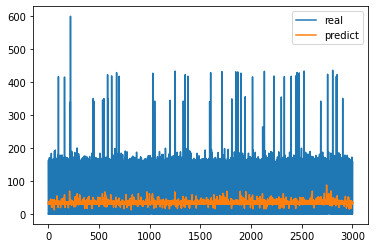

Epoch: 10; Test MAE loss on source data is: 46.994
Epoch: 10; Test MSE loss on source data is: 3702.563


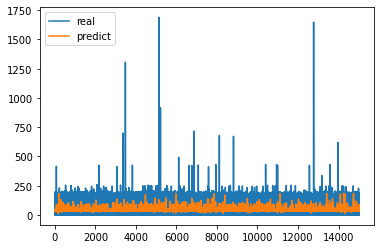

Epoch: 10; MSE loss: 856663.624
76.36454819807517
9315.66985642841
Epoch: 11; MSE loss: 840804.109
76.10534536346456
9219.377968195759
Epoch: 12; MSE loss: 880870.078
75.77453120157976
9236.07542052435
Epoch: 13; MSE loss: 859521.289
75.60277903508569
9221.708396496053
Epoch: 14; MSE loss: 816275.514
73.45890892139288
8735.172181517733
Epoch: 15; MSE loss: 814642.102
71.27862614464665
8576.36857396274
Epoch: 16; MSE loss: 803294.830
68.36253604717483
8433.394345427432
Epoch: 17; MSE loss: 748478.887
62.12962561710855
7454.067717107459
Epoch: 18; MSE loss: 747376.275
58.31039002599237
7327.451307544641
Epoch: 19; MSE loss: 708807.389
57.804752652028625
7291.767994332926
Epoch: 20; Test MAE loss on target data is: 57.805
Epoch: 20; Test MSE loss on target data is: 7291.768


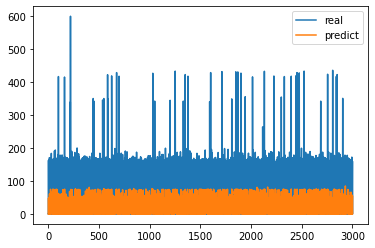

Epoch: 20; Test MAE loss on source data is: 37.878
Epoch: 20; Test MSE loss on source data is: 3147.488


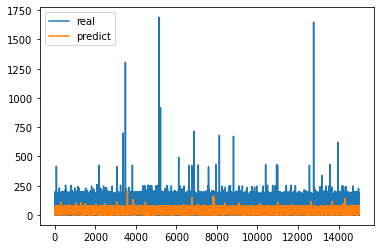

Epoch: 20; MSE loss: 730406.439
55.117662111069066
6616.322021933549
Epoch: 21; MSE loss: 706607.053
54.64367437756778
6479.317802639481
Epoch: 22; MSE loss: 715011.806
52.57843906241909
6069.0271302428355
Epoch: 23; MSE loss: 717297.397
54.49189899255647
6393.922273970771
Epoch: 24; MSE loss: 748597.900
55.82528147088009
6820.936346632327
Epoch: 25; MSE loss: 721480.002
53.6534769403365
6413.0136189748755
Epoch: 26; MSE loss: 698690.635
55.30425244742402
6706.270919155525
Epoch: 27; MSE loss: 716287.402
55.14274539265251
6622.567189406069
Epoch: 28; MSE loss: 720744.849
53.94531362371819
6312.3167859395735
Epoch: 29; MSE loss: 657421.661
54.87305089581346
6566.9856135774635
Epoch: 30; Test MAE loss on target data is: 54.873
Epoch: 30; Test MSE loss on target data is: 6566.986


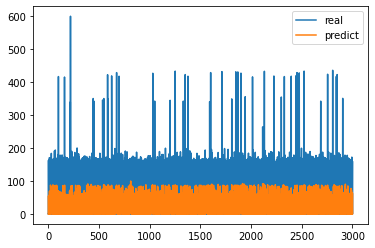

Epoch: 30; Test MAE loss on source data is: 36.567
Epoch: 30; Test MSE loss on source data is: 3041.079


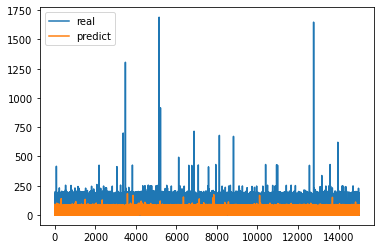

Epoch: 30; MSE loss: 721245.340
55.2634491203762
6629.328020199513
Epoch: 31; MSE loss: 701790.979
54.93737487162596
6700.311228264143
Epoch: 32; MSE loss: 657582.646
51.44955668953829
5779.9714516289405
Epoch: 33; MSE loss: 687611.434
52.16938514862651
6053.176423276877
Epoch: 34; MSE loss: 699529.406
51.49751704602878
5933.874557816087
Epoch: 35; MSE loss: 712691.046
53.86651973049101
6445.863111734142
Epoch: 36; MSE loss: 726992.066
56.18899043287323
6995.129433574185
Epoch: 37; MSE loss: 684890.186
52.87746267394967
6313.452836314848
Epoch: 38; MSE loss: 717718.439
51.720532647402244
5925.494452918125
Epoch: 39; MSE loss: 680884.450
49.915879648178816
5510.905449654408
Epoch: 40; Test MAE loss on target data is: 49.916
Epoch: 40; Test MSE loss on target data is: 5510.905


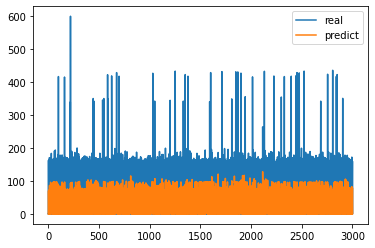

Epoch: 40; Test MAE loss on source data is: 39.060
Epoch: 40; Test MSE loss on source data is: 3045.957


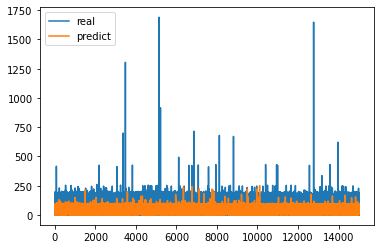

Epoch: 40; MSE loss: 705286.522
53.41327156592285
6358.911878420923
Epoch: 41; MSE loss: 637132.416
54.09480816004835
6566.294353174475
Epoch: 42; MSE loss: 704711.790
52.15074806075082
6129.77278411375
Epoch: 43; MSE loss: 709725.593
53.2195752867846
6362.214166362244
Epoch: 44; MSE loss: 664113.494
49.40078288020092
5490.865486101102
Epoch: 45; MSE loss: 665216.051
56.517739648656665
6920.452993783063
Epoch: 46; MSE loss: 679891.732
49.26787992231746
5477.17750743212
Epoch: 47; MSE loss: 673528.864
51.40519002645454
5893.604753109005
Epoch: 48; MSE loss: 694289.384
49.15699447291133
5475.3324156903855
Epoch: 49; MSE loss: 684726.768
50.838401084346636
5835.059245531918
Epoch: 50; Test MAE loss on target data is: 50.838
Epoch: 50; Test MSE loss on target data is: 5835.059


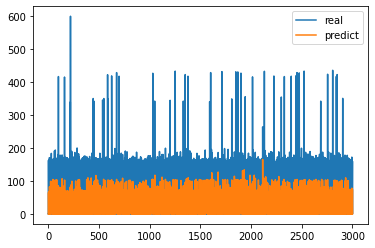

Epoch: 50; Test MAE loss on source data is: 36.581
Epoch: 50; Test MSE loss on source data is: 2897.988


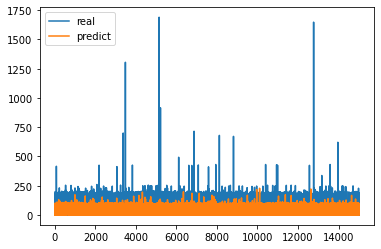

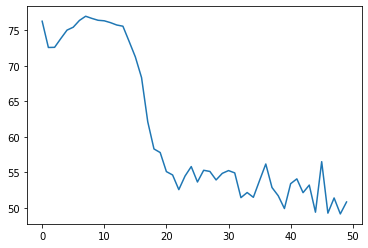

50.838401084346636
0.5104614402462647
0.6480689588199636


In [38]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [1]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
                loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/20
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 1222102.019
48.093865401372064
9619.68716371867
Epoch: 1; MSE loss: 1181672.033
49.66296811874656
8980.157687447434
Epoch: 2; MSE loss: 1086591.001
52.04464904483138
8660.826548475168
Epoch: 3; MSE loss: 1072157.338
53.20470648017185
8494.310468809532
Epoch: 4; MSE loss: 1089359.171
53.906892515900815
8384.250875384114
Epoch: 5; MSE loss: 1063411.504
54.363674950398604
8294.50678092907
Epoch: 6; MSE loss: 999271.690
55.31277128060658
8229.988340343763
Epoch: 7; MSE loss: 1039485.494
56.60606738645872
8146.991124368691
Epoch: 8; MSE loss: 996960.621
56.26379453057164
8125.54642068302
Epoch: 9; MSE loss: 960291.944
58.789757713444004
7908.429433136946
Epoch: 10; Test MAE loss on target data is: 58.790
Epoch: 10; Test MSE loss on target data is: 7908.429


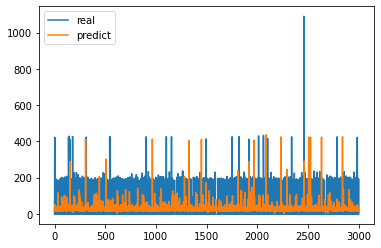

Epoch: 10; Test MAE loss on source data is: 46.104
Epoch: 10; Test MSE loss on source data is: 4051.959


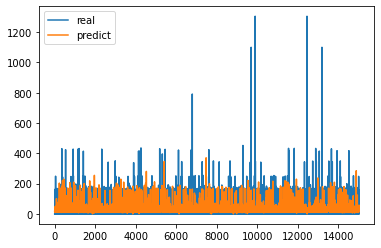

Epoch: 10; MSE loss: 950193.833
61.052539819989576
7790.783562690356
Epoch: 11; MSE loss: 941247.415
61.72461367767226
7576.328985107063
Epoch: 12; MSE loss: 927735.329
63.27519320222043
7489.953227748152
Epoch: 13; MSE loss: 848986.834
63.14859215550776
7542.618484161815
Epoch: 14; MSE loss: 900845.301
62.81598035680999
7539.97019635335
Epoch: 15; MSE loss: 812466.893
64.8123900399928
7230.642758078787
Epoch: 16; MSE loss: 829079.700
66.1127948453439
6990.06462254756
Epoch: 17; MSE loss: 835109.517
65.7012835540509
7065.763149993555
Epoch: 18; MSE loss: 819626.099
64.66955219852728
7007.60785647626
Epoch: 19; MSE loss: 838630.560
65.77472191287764
6953.801395760082
Epoch: 20; Test MAE loss on target data is: 65.775
Epoch: 20; Test MSE loss on target data is: 6953.801


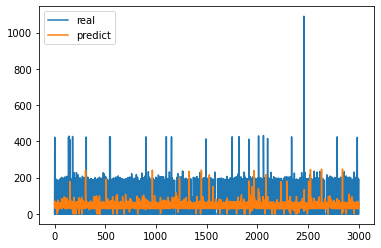

Epoch: 20; Test MAE loss on source data is: 47.166
Epoch: 20; Test MSE loss on source data is: 3424.315


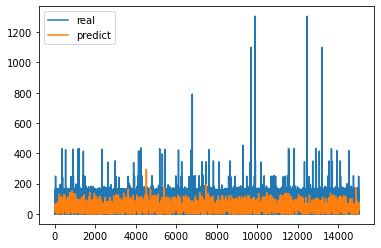

Epoch: 20; MSE loss: 831321.972
65.85324566659534
6770.794048583946
Epoch: 21; MSE loss: 819537.256
64.19409973633009
6798.480178610267
Epoch: 22; MSE loss: 775452.992
63.676003950942736
6721.410143159077
Epoch: 23; MSE loss: 781599.975
60.91840201253513
6466.859546602498
Epoch: 24; MSE loss: 771767.081
65.8458138202138
7472.321490224689
Epoch: 25; MSE loss: 736098.487
62.218196601482475
6547.740657377497
Epoch: 26; MSE loss: 782395.548
58.220074150560826
6909.173561595439
Epoch: 27; MSE loss: 741822.873
56.45206039893629
6170.774350437451
Epoch: 28; MSE loss: 731977.366
56.624932909985404
6127.495120203743
Epoch: 29; MSE loss: 703288.468
56.92164569596449
6614.787560662064
Epoch: 30; Test MAE loss on target data is: 56.922
Epoch: 30; Test MSE loss on target data is: 6614.788


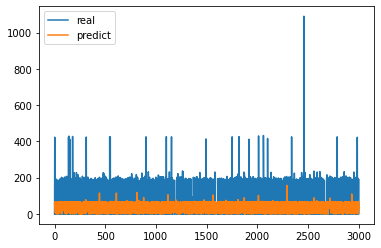

Epoch: 30; Test MAE loss on source data is: 41.341
Epoch: 30; Test MSE loss on source data is: 3122.531


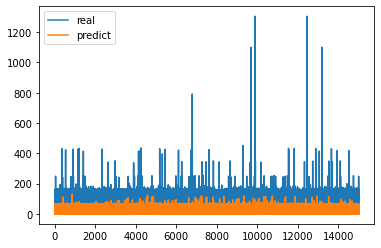

Epoch: 30; MSE loss: 758750.364
54.22697230454582
6169.825180529675
Epoch: 31; MSE loss: 701981.311
52.491891646049204
5689.739656746774
Epoch: 32; MSE loss: 718984.871
51.57642846058804
5811.820777497495
Epoch: 33; MSE loss: 683378.526
51.67284602477247
5554.812600242233
Epoch: 34; MSE loss: 703631.463
49.01663289679304
5467.86619526596
Epoch: 35; MSE loss: 697004.016
55.10807765351465
6201.183879719474
Epoch: 36; MSE loss: 704566.022
55.763094335450525
6498.059741650397
Epoch: 37; MSE loss: 706540.589
53.200932507720246
6206.915833378712
Epoch: 38; MSE loss: 676305.723
55.65736923822484
6203.196825203224
Epoch: 39; MSE loss: 670750.682
58.20476356090517
7156.562025143342
Epoch: 40; Test MAE loss on target data is: 58.205
Epoch: 40; Test MSE loss on target data is: 7156.562


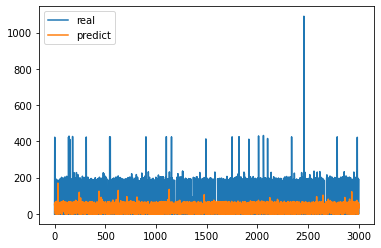

Epoch: 40; Test MAE loss on source data is: 41.244
Epoch: 40; Test MSE loss on source data is: 3206.238


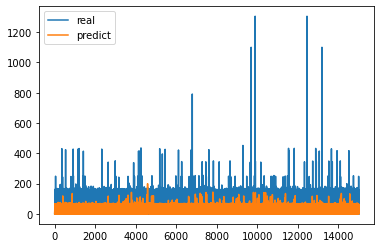

Epoch: 40; MSE loss: 683571.787
54.21840541725304
6235.01063984567
Epoch: 41; MSE loss: 693668.245
53.99126893604696
6612.549437381768
Epoch: 42; MSE loss: 700150.283
51.4699840966035
5764.968782558339
Epoch: 43; MSE loss: 709788.797
51.4361853259196
5659.673130498468
Epoch: 44; MSE loss: 667902.150
51.80670873424277
5478.042296587597
Epoch: 45; MSE loss: 700859.035
49.72373291036908
5897.7643133991505
Epoch: 46; MSE loss: 757492.896
52.578138037368525
5662.021460403606
Epoch: 47; MSE loss: 725200.515
53.19259884757396
6021.587192395196
Epoch: 48; MSE loss: 693973.840
52.64214898405131
5996.037212237569
Epoch: 49; MSE loss: 669575.265
55.225720686714844
6307.871593728743
Epoch: 50; Test MAE loss on target data is: 55.226
Epoch: 50; Test MSE loss on target data is: 6307.872


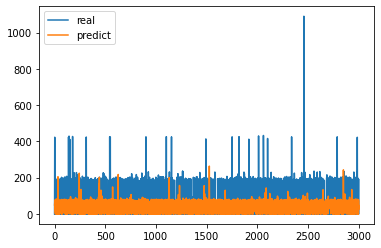

Epoch: 50; Test MAE loss on source data is: 38.826
Epoch: 50; Test MSE loss on source data is: 2986.505


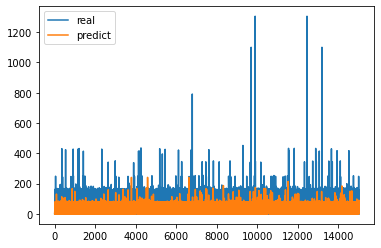

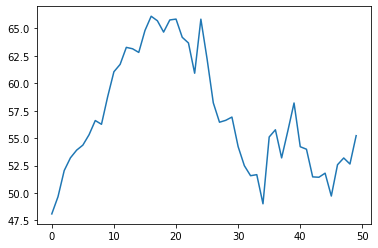

55.225720686714844
0.1702404688647654
0.7831855397433017
house instance is: 2
Epoch: 0; MSE loss: 1423740.460
41.475043936441594
4476.499337302709
Epoch: 1; MSE loss: 1477421.944
42.32848531543742
3940.978379835654
Epoch: 2; MSE loss: 1378294.142
43.06230756471779
3723.9655858300125
Epoch: 3; MSE loss: 1311481.962
43.64995038469685
3623.42027483553
Epoch: 4; MSE loss: 1288786.655
43.13791135575538
3565.709544885343
Epoch: 5; MSE loss: 1256114.713
42.66031569417085
3582.7895122582104
Epoch: 6; MSE loss: 1271834.781
44.06375195468949
3416.4807227437996
Epoch: 7; MSE loss: 1233357.336
43.76864350937337
3347.2699998981775
Epoch: 8; MSE loss: 1181594.615
43.6875135520803
3280.6951515422497
Epoch: 9; MSE loss: 1176149.642
44.6541732678242
3200.3763351981984
Epoch: 10; Test MAE loss on target data is: 44.654
Epoch: 10; Test MSE loss on target data is: 3200.376


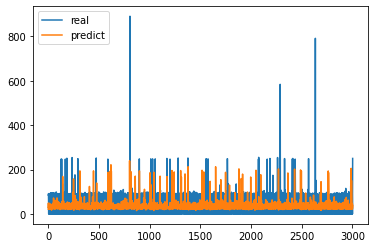

Epoch: 10; Test MAE loss on source data is: 49.490
Epoch: 10; Test MSE loss on source data is: 5270.356


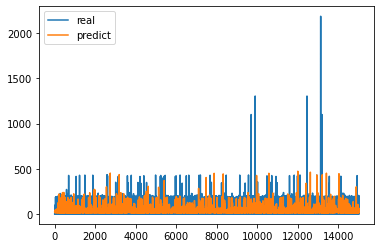

Epoch: 10; MSE loss: 1158329.837
44.87771895563555
3137.6379876543224
Epoch: 11; MSE loss: 1103190.058
44.74342022310402
3036.1643350995655
Epoch: 12; MSE loss: 1105501.961
44.42556761107972
2938.4913772714513
Epoch: 13; MSE loss: 1074924.356
44.666594559279645
2872.1226518630547
Epoch: 14; MSE loss: 1082344.702
44.577271174178144
2892.337889217594
Epoch: 15; MSE loss: 1051255.780
44.812650553673784
2848.545733102143
Epoch: 16; MSE loss: 1074696.395
45.69093686889872
2970.128458136091
Epoch: 17; MSE loss: 1026275.741
45.15489546581607
2820.281200391583
Epoch: 18; MSE loss: 1014560.833
45.09986509813291
2803.9072812321333
Epoch: 19; MSE loss: 1010377.231
45.79476591020069
2993.2735154823376
Epoch: 20; Test MAE loss on target data is: 45.795
Epoch: 20; Test MSE loss on target data is: 2993.274


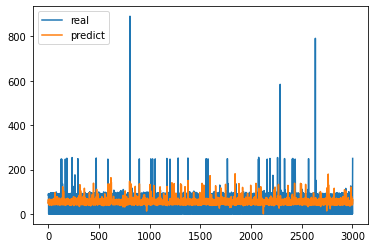

Epoch: 20; Test MAE loss on source data is: 52.870
Epoch: 20; Test MSE loss on source data is: 4566.634


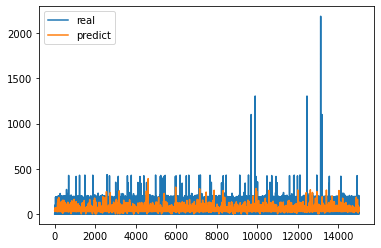

Epoch: 20; MSE loss: 1005883.531
45.652247117497474
3049.916249877507
Epoch: 21; MSE loss: 990569.419
45.32123873522691
2918.2019245755127
Epoch: 22; MSE loss: 954223.125
44.80934515734329
2842.092207564104
Epoch: 23; MSE loss: 938842.269
44.24448894613116
2853.932895652368
Epoch: 24; MSE loss: 942557.953
43.489742119683726
2853.8172137204087
Epoch: 25; MSE loss: 935691.496
43.87583487995772
2888.208187551012
Epoch: 26; MSE loss: 914452.913
42.61953568347443
3107.839182282412
Epoch: 27; MSE loss: 881869.011
41.01802489078156
3108.6554132242645
Epoch: 28; MSE loss: 803152.993
39.64341610009855
3074.046499172787
Epoch: 29; MSE loss: 844394.953
42.02589946461422
3354.0919781648417
Epoch: 30; Test MAE loss on target data is: 42.026
Epoch: 30; Test MSE loss on target data is: 3354.092


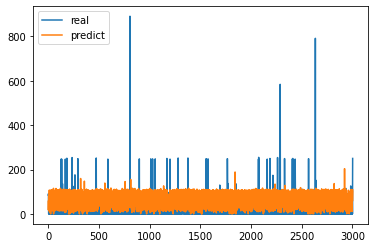

Epoch: 30; Test MAE loss on source data is: 40.099
Epoch: 30; Test MSE loss on source data is: 3764.722


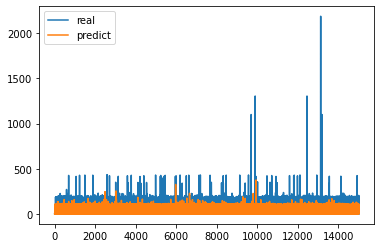

Epoch: 30; MSE loss: 816281.599
40.047717541575274
3090.1330686640194
Epoch: 31; MSE loss: 793771.398
42.00916947287504
3367.0699060692696
Epoch: 32; MSE loss: 794235.821
42.28725947059701
3394.704338254764
Epoch: 33; MSE loss: 820211.996
38.69138331268821
2991.153675052881
Epoch: 34; MSE loss: 789467.770
38.47543565313841
2947.2864462620755
Epoch: 35; MSE loss: 811190.244
38.38699633666821
2937.549604388548
Epoch: 36; MSE loss: 804885.171
38.160211698113685
2935.658313370944
Epoch: 37; MSE loss: 729984.510
39.405974381019206
3049.034287294775
Epoch: 38; MSE loss: 774980.115
39.24036124364514
3046.651412589433
Epoch: 39; MSE loss: 749997.409
42.322605298130156
3373.6373669545465
Epoch: 40; Test MAE loss on target data is: 42.323
Epoch: 40; Test MSE loss on target data is: 3373.637


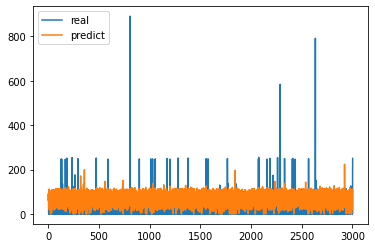

Epoch: 40; Test MAE loss on source data is: 39.718
Epoch: 40; Test MSE loss on source data is: 3569.516


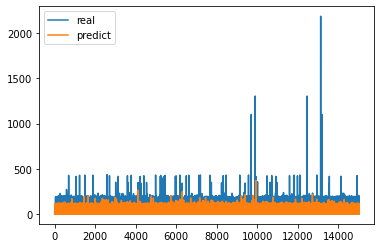

Epoch: 40; MSE loss: 758167.181
42.75005311367118
3411.071421902743
Epoch: 41; MSE loss: 780829.253
38.945057216520794
3055.621425753262
Epoch: 42; MSE loss: 762184.169
40.87811779083012
3165.9959418080366
Epoch: 43; MSE loss: 756774.378
40.354788866405
3173.424915662041
Epoch: 44; MSE loss: 728157.366
40.19533339839245
3080.410079519597
Epoch: 45; MSE loss: 745547.121
37.15318614774236
2614.850516049839
Epoch: 46; MSE loss: 766892.705
41.000827351299804
3165.9555496103267
Epoch: 47; MSE loss: 770105.728
39.089048061564505
2932.940658984148
Epoch: 48; MSE loss: 760164.715
41.43253847861417
3210.243649159589
Epoch: 49; MSE loss: 780062.218
41.66092208267925
3248.0217088095005
Epoch: 50; Test MAE loss on target data is: 41.661
Epoch: 50; Test MSE loss on target data is: 3248.022


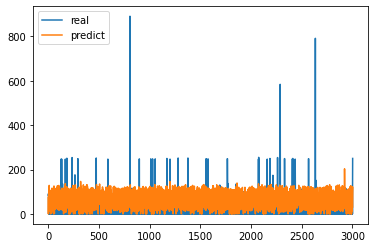

Epoch: 50; Test MAE loss on source data is: 38.006
Epoch: 50; Test MSE loss on source data is: 3439.071


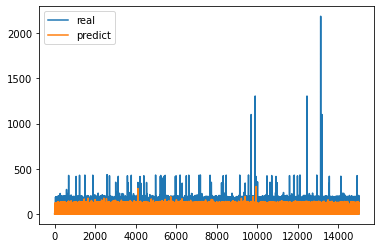

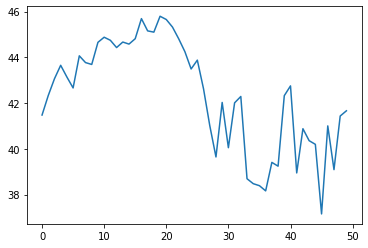

41.66092208267925
0.5530277878435527
0.8320781788559826
house instance is: 5
Epoch: 0; MSE loss: 1537568.212
25.329294149923857
1974.1664913705845
Epoch: 1; MSE loss: 1521763.448
27.586818172468664
1977.6022298619325
Epoch: 2; MSE loss: 1466908.857
28.513459023440408
1791.044722928838
Epoch: 3; MSE loss: 1370816.744
29.64482398539504
1718.2540455333149
Epoch: 4; MSE loss: 1345600.792
30.050031356900416
1621.4313369774043
Epoch: 5; MSE loss: 1338104.726
31.461323616507844
1624.5053367527735
Epoch: 6; MSE loss: 1300092.469
31.498323246896188
1490.7876243354297
Epoch: 7; MSE loss: 1271432.266
32.745683426545874
1471.2284100188874
Epoch: 8; MSE loss: 1183691.492
34.65395976081193
1504.138658946162
Epoch: 9; MSE loss: 1178669.110
36.15279714308788
1470.68782753089
Epoch: 10; Test MAE loss on target data is: 36.153
Epoch: 10; Test MSE loss on target data is: 1470.688


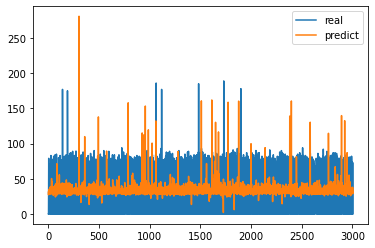

Epoch: 10; Test MAE loss on source data is: 52.902
Epoch: 10; Test MSE loss on source data is: 5055.640


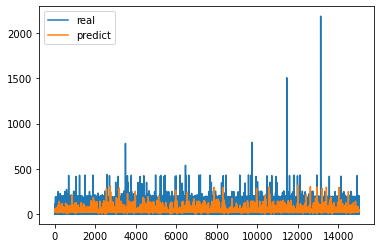

Epoch: 10; MSE loss: 1193088.089
39.93935471880293
1849.4541457567443
Epoch: 11; MSE loss: 1097922.165
37.13226975589872
1441.3520156843424
Epoch: 12; MSE loss: 1094567.975
40.47173289801881
1862.1497488767957
Epoch: 13; MSE loss: 1095322.943
39.9456179501531
1719.8743558146796
Epoch: 14; MSE loss: 1037498.662
40.69285062134028
1853.1380108533397
Epoch: 15; MSE loss: 1031859.856
40.760792026507076
1862.2617857563716
Epoch: 16; MSE loss: 1005736.350
40.35999050615889
1828.150077196367
Epoch: 17; MSE loss: 1012977.339
39.295380887115364
1696.578193436543
Epoch: 18; MSE loss: 1043598.356
38.281214452853376
1622.4187677380673
Epoch: 19; MSE loss: 941016.349
39.476209828602805
1848.8914865748352
Epoch: 20; Test MAE loss on target data is: 39.476
Epoch: 20; Test MSE loss on target data is: 1848.891


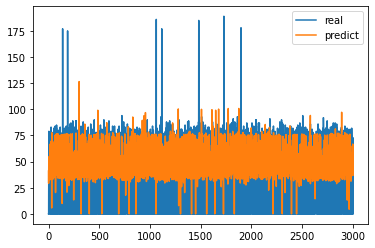

Epoch: 20; Test MAE loss on source data is: 49.926
Epoch: 20; Test MSE loss on source data is: 4199.190


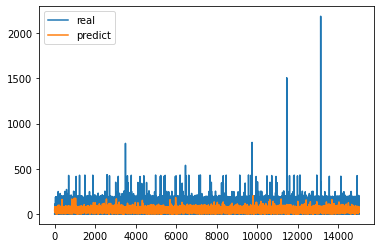

Epoch: 20; MSE loss: 933431.289
37.71528488040447
1787.2707482453854
Epoch: 21; MSE loss: 907667.606
37.55464215647583
1821.353051762912
Epoch: 22; MSE loss: 871157.535
33.327324054381265
1761.3058753334415
Epoch: 23; MSE loss: 837391.636
35.68181877103095
1931.3685318999762
Epoch: 24; MSE loss: 858973.962
32.3388195111802
1747.1949778812632
Epoch: 25; MSE loss: 833601.168
34.37159722146594
1910.5431125739158
Epoch: 26; MSE loss: 830557.185
32.558372127301446
1852.838111490516
Epoch: 27; MSE loss: 848054.892
34.78777069121242
1926.8777579984742
Epoch: 28; MSE loss: 821722.566
31.438319565849838
1797.921432093174
Epoch: 29; MSE loss: 833576.216
33.680018762773905
1919.972761186045
Epoch: 30; Test MAE loss on target data is: 33.680
Epoch: 30; Test MSE loss on target data is: 1919.973


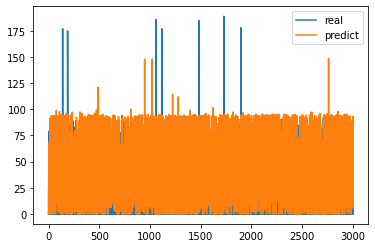

Epoch: 30; Test MAE loss on source data is: 39.661
Epoch: 30; Test MSE loss on source data is: 3672.150


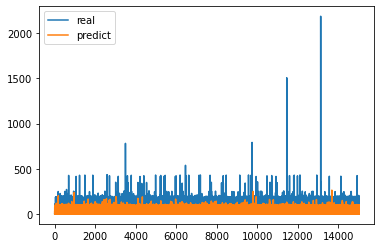

Epoch: 30; MSE loss: 854609.311
32.55116621290796
1819.3273696608683
Epoch: 31; MSE loss: 858429.691
30.25253865708127
1777.178437968716
Epoch: 32; MSE loss: 847008.991
32.80031692058086
1849.5690834170614
Epoch: 33; MSE loss: 853095.553
36.23972925069567
2101.0618538580848
Epoch: 34; MSE loss: 834918.045
35.59873948038894
2062.8714598212805
Epoch: 35; MSE loss: 789685.544
33.87009804601596
2010.0439032311765
Epoch: 36; MSE loss: 799327.511
33.59397765234629
1926.9616466719926
Epoch: 37; MSE loss: 782400.053
30.7490464872848
1785.8940138338248
Epoch: 38; MSE loss: 803701.144
32.47201199040372
1921.2726236149329
Epoch: 39; MSE loss: 804233.089
32.45142913067071
1907.0485073545174
Epoch: 40; Test MAE loss on target data is: 32.451
Epoch: 40; Test MSE loss on target data is: 1907.049


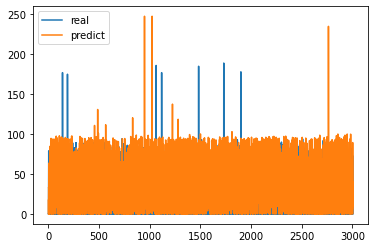

Epoch: 40; Test MAE loss on source data is: 38.428
Epoch: 40; Test MSE loss on source data is: 3523.623


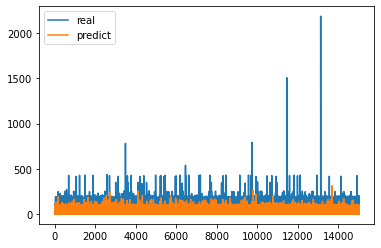

Epoch: 40; MSE loss: 828012.702
35.30619898692428
2121.001518546885
Epoch: 41; MSE loss: 807325.468
33.574059185042444
2094.380103438298
Epoch: 42; MSE loss: 818552.160
34.56444227953408
2039.138552353534
Epoch: 43; MSE loss: 791990.889
31.282556182713545
1781.5099515602712
Epoch: 44; MSE loss: 782847.109
31.329973008786236
1900.2170271457558
Epoch: 45; MSE loss: 788691.586
36.05676152810117
2235.8761351116264
Epoch: 46; MSE loss: 796286.434
34.94041602499535
2155.326625542397
Epoch: 47; MSE loss: 770931.697
32.21917745203137
1852.080454796366
Epoch: 48; MSE loss: 773361.355
33.84237975769052
1991.420805837004
Epoch: 49; MSE loss: 716180.894
33.813810063186246
2015.4934711184985
Epoch: 50; Test MAE loss on target data is: 33.814
Epoch: 50; Test MSE loss on target data is: 2015.493


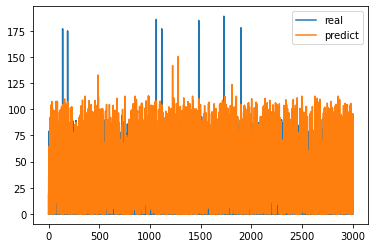

Epoch: 50; Test MAE loss on source data is: 37.597
Epoch: 50; Test MSE loss on source data is: 3348.021


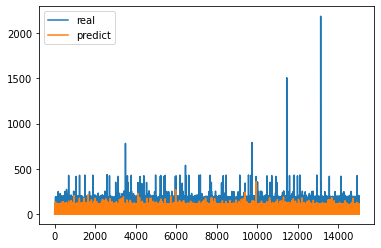

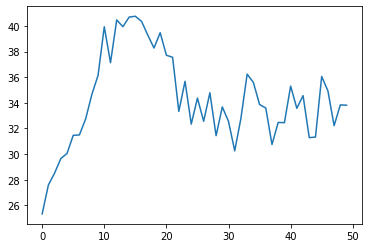

33.813810063186246
0.5510054955994014
1.0268639029621778


In [25]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,2,5]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
                loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/20
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [9]:
# ######################################washingmachine###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM//training_data/washingmachine_house_3_training_.csv"

# trainfile2="F:/NILM/ukdale_training/washingmachine_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="F:/NILM/refit_training/washingmachine/washingmachine_house_9_training_.csv"
# trainfile4="F:/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[1,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=20
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)
# # fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# # stepsizeList=[4,1,4,4]
# # data_insts, data_labels, num_insts,on = [], [], [],[]
# # threshold=200
# # for i in range(len(fileList)):
# #     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
# #     X_on=X[Y>0]
# #     Y_on=Y[Y>0]
# #     X_off=X[Y==0]
# #     Y_off=Y[Y==0]
# #     ridx = np.random.choice(X_off.shape[0], int(len(Y_on)*20))
# #     X_off = X_off[ridx, :]
# #     Y_on=Y_on.reshape(-1,1)
# #     Y_off=Y_off.reshape(-1,1)
# #     Y_off = Y_off[ridx, :]
# #     X_pre=np.concatenate([X_on,X_off], axis=0)
# #     Y_pre=np.concatenate([Y_on,Y_off], axis=0)
# #     on.append(Y_on)
# #     data_insts.append(X_pre)
# #     data_labels.append(Y_pre)
# #     num_insts.append(X_pre.shape[0])
# #     # r_order = np.arange(num_insts[i])
# #     # np.random.shuffle(r_order)
# #     # data_insts[i] = data_insts[i][r_order, :]
# #     # data_labels[i] = data_labels[i][r_order,:]
# # print(num_insts)
# # min_size=min(num_insts)
# # x_tem, y_tem=[],[]
# # for j in range(len(fileList)):
# #   ridx = np.random.choice(num_insts[j], min_size)
# #   x_tem.append(data_insts[j][ridx, :])
# #   y_tem.append(data_labels[j][ridx, :])
# #   num_insts[j]=x_tem[j].shape[0]
# # data_insts=x_tem
# # data_labels=y_tem 
# # print(num_insts)

In [10]:
# ######################################washingmachine###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# # trainfile1="/content/drive/MyDrive/training_data/washingmachine_house_2_training_.csv"
# trainfile1="F:/NILM//training_data/washingmachine_test_.csv"

# trainfile2="F:/NILM/ukdale_training/washingmachine_house_1_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="F:/NILM/refit_training/washingmachine/washingmachine_house_9_training_.csv"
# trainfile4="F:/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=20
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [26]:
######################################washingmachine###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# # trainfile1="/content/drive/MyDrive/training_data/washingmachine_house_2_training_.csv"
# trainfile1="/content/drive/MyDrive/training_data/washingmachine_test_.csv"

# trainfile2="/content/drive/MyDrive/ukdale_training/washingmachine_house_1_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="/content/drive/MyDrive/refit_training/washingmachine/washingmachine_house_9_training_.csv"
# trainfile4="/content/drive/MyDrive/refit_training/washingmachine/washingmachine_house_16_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
trainfile1="F:/NILM/training_data/washingmachine_test_.csv"
trainfile2="F:/NILM/training_data/washingmachine_house_2_training_.csv"
trainfile3="F:/NILM/ukdale_training/washingmachine_house_1_training_.csv"
trainfile4="F:/NILM/ukdale_training/washingmachine_house_2_training_.csv"
trainfile5="F:/NILM/refit_training/washingmachine/washingmachine_house_9_training_.csv"
trainfile6="F:/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,2,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=20
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[15017, 15017, 15017, 15017, 15017, 15017]


house instance is: 0
Epoch: 0; MSE loss: 5751748.736
27.72651789793798
61028.86174877852
Epoch: 1; MSE loss: 5172410.242
37.88427457892899
48100.16923805208
Epoch: 2; MSE loss: 5118633.989
36.19559564121519
49620.28689962367
Epoch: 3; MSE loss: 5216037.604
33.86028155825761
52086.21839543309
Epoch: 4; MSE loss: 5126114.279
41.808717943952836
45530.25234786342
Epoch: 5; MSE loss: 5219163.195
31.513589127330686
55716.09262077179
Epoch: 6; MSE loss: 4828784.367
32.750087122200156
54456.08291898382
Epoch: 7; MSE loss: 5523507.869
37.822417677825754
48316.47974627268
Epoch: 8; MSE loss: 5454030.670
32.50052736713884
54549.2193481143
Epoch: 9; MSE loss: 5149543.446
35.19913470850413
51831.007277313875
Epoch: 10; Test MAE loss on target data is: 35.199
Epoch: 10; Test MSE loss on target data is: 51831.007


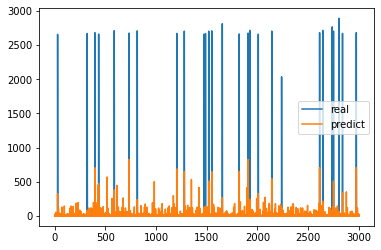

Epoch: 10; Test MAE loss on source data is: 30.341
Epoch: 10; Test MSE loss on source data is: 20779.438


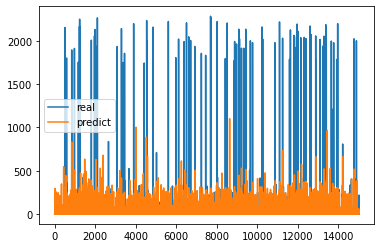

Epoch: 10; MSE loss: 4966574.235
34.48829773356547
51663.536396514755
Epoch: 11; MSE loss: 5144102.236
31.953294889884017
52939.84166023831
Epoch: 12; MSE loss: 4914885.176
33.9106855940998
50951.9291767407
Epoch: 13; MSE loss: 5065944.902
31.84950647482717
53147.20745862722
Epoch: 14; MSE loss: 5451979.735
32.21781634195772
53638.13701433697
Epoch: 15; MSE loss: 4920890.059
30.99843216639986
55170.98369595968
Epoch: 16; MSE loss: 4635039.147
29.722353872578115
54449.886467333024
Epoch: 17; MSE loss: 5367081.840
34.09724245267216
47889.65490475295
Epoch: 18; MSE loss: 5256170.988
34.955978277749914
48940.5097194272
Epoch: 19; MSE loss: 5109634.972
32.11438227566583
48956.04383831962
Epoch: 20; Test MAE loss on target data is: 32.114
Epoch: 20; Test MSE loss on target data is: 48956.044


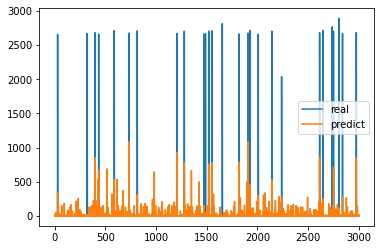

Epoch: 20; Test MAE loss on source data is: 28.517
Epoch: 20; Test MSE loss on source data is: 20797.417


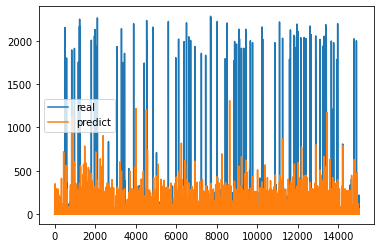

Epoch: 20; MSE loss: 4953556.850
28.478340703063125
56695.34222719718
Epoch: 21; MSE loss: 5127328.147
27.645239863318174
57842.20857947208
Epoch: 22; MSE loss: 4906827.369
30.83146223782686
52763.27944358581
Epoch: 23; MSE loss: 5205746.842
30.563400512446282
54496.13453493796
Epoch: 24; MSE loss: 5228242.000
31.050817683737606
54780.03559394322
Epoch: 25; MSE loss: 5363711.381
30.097030632467373
52842.62712965942
Epoch: 26; MSE loss: 4935216.544
30.07585294554287
53512.88112004121
Epoch: 27; MSE loss: 5095090.836
29.732642798422045
51489.90177768996
Epoch: 28; MSE loss: 5138241.545
29.00590148271188
53347.03309693637
Epoch: 29; MSE loss: 5320920.725
29.87275443401368
50599.417334412
Epoch: 30; Test MAE loss on target data is: 29.873
Epoch: 30; Test MSE loss on target data is: 50599.417


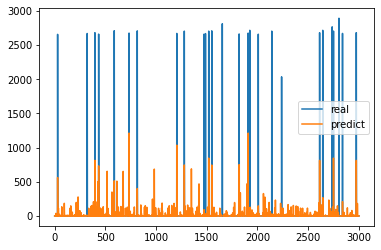

Epoch: 30; Test MAE loss on source data is: 24.972
Epoch: 30; Test MSE loss on source data is: 20383.115


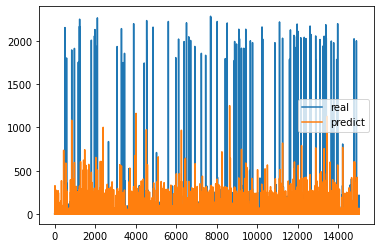

Epoch: 30; MSE loss: 5197185.136
28.059413515211567
51814.20671502744
Epoch: 31; MSE loss: 5073625.393
28.579465295377037
52269.48156230511
Epoch: 32; MSE loss: 5350966.453
30.29358826287643
50099.51905178248
Epoch: 33; MSE loss: 5320869.818
30.531194439801872
48984.218586753814
Epoch: 34; MSE loss: 5524618.877
30.1666956463431
57963.14803030109
Epoch: 35; MSE loss: 5058532.545
29.24879461958098
53361.88684779199
Epoch: 36; MSE loss: 4943902.087
30.458875761166894
52070.895521468534
Epoch: 37; MSE loss: 5502071.204
31.282849792561368
51650.997536583185
Epoch: 38; MSE loss: 4900273.573
28.463468620255156
56507.09357094497
Epoch: 39; MSE loss: 4939491.460
26.64736640328997
53559.19103132374
Epoch: 40; Test MAE loss on target data is: 26.647
Epoch: 40; Test MSE loss on target data is: 53559.191


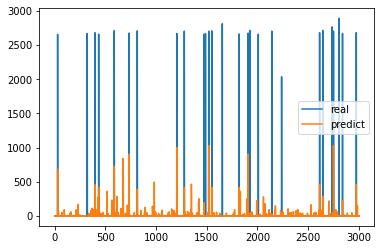

Epoch: 40; Test MAE loss on source data is: 18.984
Epoch: 40; Test MSE loss on source data is: 20778.615


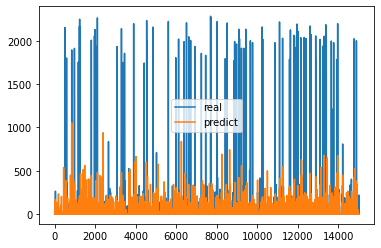

Epoch: 40; MSE loss: 5135327.815
29.10372742995309
57872.77441850461
Epoch: 41; MSE loss: 5269266.302
30.928123356793463
52257.22321255912
Epoch: 42; MSE loss: 5056283.415
31.187102787758818
50613.9361789738
Epoch: 43; MSE loss: 5005594.078
27.41190481422691
54947.661729690415
Epoch: 44; MSE loss: 4915758.900
28.028701863028818
53469.47684198211
Epoch: 45; MSE loss: 4621571.085
27.586884528186868
55080.51383502109
Epoch: 46; MSE loss: 4503662.634
26.669166119520366
56691.68793599414
Epoch: 47; MSE loss: 4550176.665
29.69149575675302
51877.9325556671
Epoch: 48; MSE loss: 4983777.350
29.74134780593213
54423.02594879197
Epoch: 49; MSE loss: 4737320.243
30.540677574867875
54565.800842145116
Epoch: 50; Test MAE loss on target data is: 30.541
Epoch: 50; Test MSE loss on target data is: 54565.801


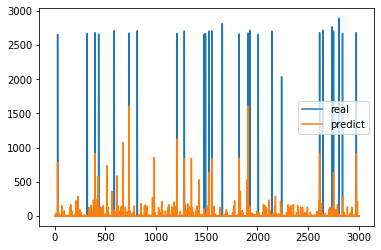

Epoch: 50; Test MAE loss on source data is: 24.826
Epoch: 50; Test MSE loss on source data is: 19878.875


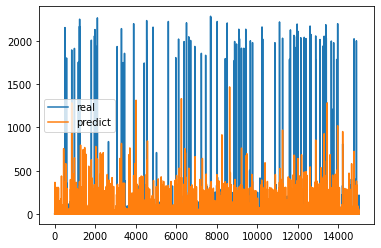

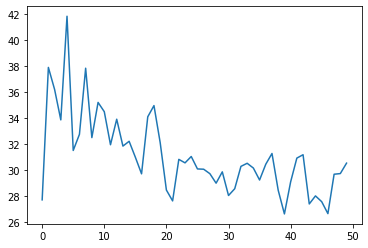

30.540677574867875
0.5326792649730163
0.8858373363508586
house instance is: 2
Epoch: 0; MSE loss: 6446106.369
29.53635067962105
43894.3996456877
Epoch: 1; MSE loss: 6010416.402
48.48334789749349
36017.35795920904
Epoch: 2; MSE loss: 5988435.380
56.07337374296709
34416.38724270095
Epoch: 3; MSE loss: 5711267.752
47.600293830792346
35784.657370738685
Epoch: 4; MSE loss: 5924571.141
48.532078284217164
35293.255794172685
Epoch: 5; MSE loss: 5630412.015
46.93534494543724
35533.753715713196
Epoch: 6; MSE loss: 5491483.089
37.83946922104235
37711.5503004957
Epoch: 7; MSE loss: 5502538.613
41.85163040994635
35999.135964184105
Epoch: 8; MSE loss: 5337793.815
40.43483423726874
36232.74730567054
Epoch: 9; MSE loss: 5138378.232
33.62383199290195
38740.82294236144
Epoch: 10; Test MAE loss on target data is: 33.624
Epoch: 10; Test MSE loss on target data is: 38740.823


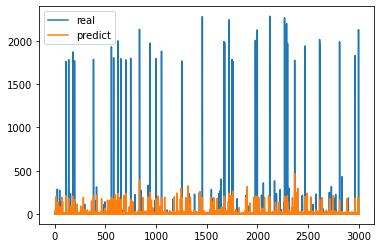

Epoch: 10; Test MAE loss on source data is: 25.908
Epoch: 10; Test MSE loss on source data is: 24394.098


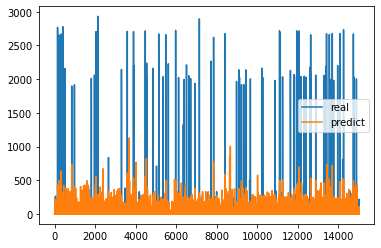

Epoch: 10; MSE loss: 5551445.609
36.27432129922981
37210.471254851465
Epoch: 11; MSE loss: 5726390.574
35.76408205249318
37153.29499840419
Epoch: 12; MSE loss: 5726064.766
40.98174195669185
34634.78655804682
Epoch: 13; MSE loss: 5315657.067
35.4461031911545
36510.28670676702
Epoch: 14; MSE loss: 5785184.625
34.14594537283129
36675.81599136926
Epoch: 15; MSE loss: 5475528.230
34.415246998293505
36195.73112865247
Epoch: 16; MSE loss: 5168583.290
31.943094357491017
37507.09684447882
Epoch: 17; MSE loss: 5998053.666
33.63094153907522
36049.72220474032
Epoch: 18; MSE loss: 5437558.271
35.763574266491254
34807.698844431216
Epoch: 19; MSE loss: 5074970.171
31.50250849052371
37143.96387622918
Epoch: 20; Test MAE loss on target data is: 31.503
Epoch: 20; Test MSE loss on target data is: 37143.964


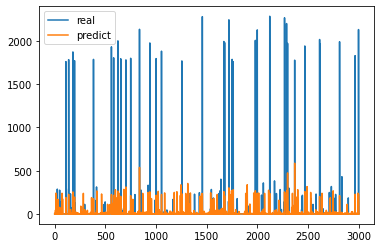

Epoch: 20; Test MAE loss on source data is: 24.713
Epoch: 20; Test MSE loss on source data is: 22288.352


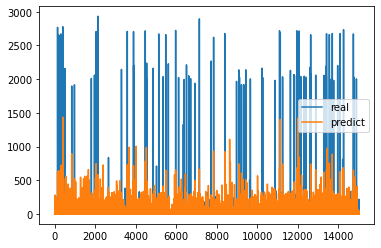

Epoch: 20; MSE loss: 5233996.589
31.250464675717364
36896.26720278052
Epoch: 21; MSE loss: 5586381.552
36.53799814446153
33757.97548208725
Epoch: 22; MSE loss: 5291454.904
33.024192682267746
34652.77665083088
Epoch: 23; MSE loss: 5203581.679
29.997453450987962
37181.760052517915
Epoch: 24; MSE loss: 5231124.497
31.407909951578286
35199.82369395278
Epoch: 25; MSE loss: 4820987.476
31.192093552061706
35093.117728369296
Epoch: 26; MSE loss: 4959808.002
32.79335138832681
33571.11850613006
Epoch: 27; MSE loss: 4940185.753
31.50339921801965
34710.984498252124
Epoch: 28; MSE loss: 5151993.721
30.515429030305217
36743.51296831013
Epoch: 29; MSE loss: 5064458.685
30.265529142992794
35575.83778806241
Epoch: 30; Test MAE loss on target data is: 30.266
Epoch: 30; Test MSE loss on target data is: 35575.838


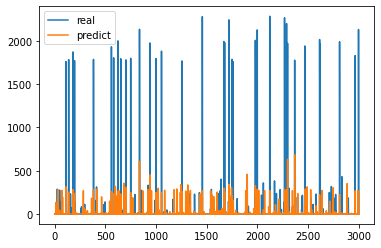

Epoch: 30; Test MAE loss on source data is: 23.860
Epoch: 30; Test MSE loss on source data is: 20417.539


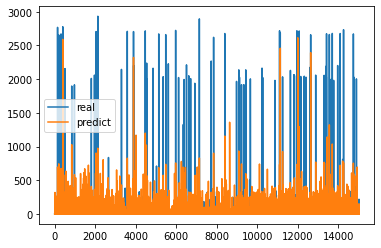

Epoch: 30; MSE loss: 5002197.169
31.184412361778687
34308.81631164129
Epoch: 31; MSE loss: 4881718.134
30.03178261221447
36439.450027557556
Epoch: 32; MSE loss: 5045099.996
30.25812455142703
35624.748806825126
Epoch: 33; MSE loss: 5207069.214
30.588401743817265
35805.21470046861
Epoch: 34; MSE loss: 4950843.911
30.232875689010964
35903.04756475814
Epoch: 35; MSE loss: 4986639.404
30.13714183181445
35604.73048450596
Epoch: 36; MSE loss: 5118626.652
30.440931537130304
35818.687826582776
Epoch: 37; MSE loss: 5103320.188
29.675755277315723
37381.439212300706
Epoch: 38; MSE loss: 5216243.018
31.047728656274025
33679.58285033384
Epoch: 39; MSE loss: 4591379.227
30.234935550572235
35495.03541846867
Epoch: 40; Test MAE loss on target data is: 30.235
Epoch: 40; Test MSE loss on target data is: 35495.035


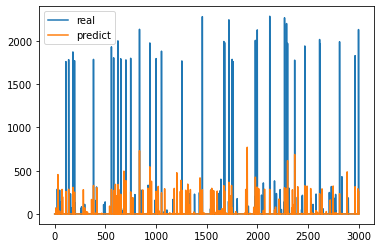

Epoch: 40; Test MAE loss on source data is: 23.180
Epoch: 40; Test MSE loss on source data is: 19340.029


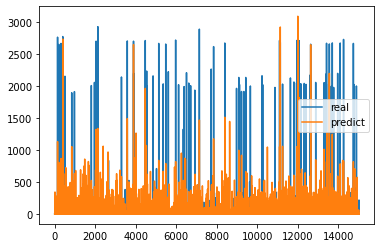

Epoch: 40; MSE loss: 4757313.983
30.910601973444344
37809.23079367209
Epoch: 41; MSE loss: 4908648.417
29.699768261708687
36053.57273164624
Epoch: 42; MSE loss: 5205730.858
30.287334317016537
36072.82014356361
Epoch: 43; MSE loss: 4505232.860
29.578595433567717
35654.30201877897
Epoch: 44; MSE loss: 4568163.061
29.996464481306933
35942.723267397545
Epoch: 45; MSE loss: 4926540.413
29.85835881310995
36355.90038886316
Epoch: 46; MSE loss: 4863397.910
30.228765661921226
34515.44779055962
Epoch: 47; MSE loss: 4790580.470
30.50450997036719
34758.982121599714
Epoch: 48; MSE loss: 4385921.271
29.275746477110566
39011.384323872335
Epoch: 49; MSE loss: 4848316.407
29.791712532427592
35172.143497835794
Epoch: 50; Test MAE loss on target data is: 29.792
Epoch: 50; Test MSE loss on target data is: 35172.143


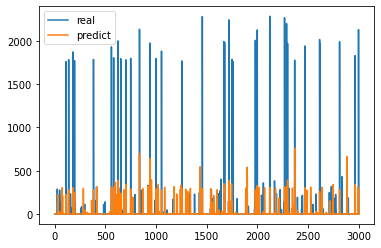

Epoch: 50; Test MAE loss on source data is: 22.463
Epoch: 50; Test MSE loss on source data is: 19415.108


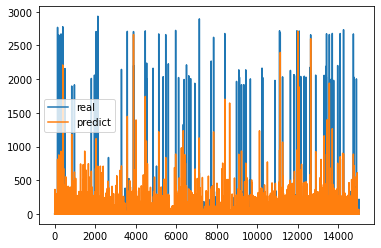

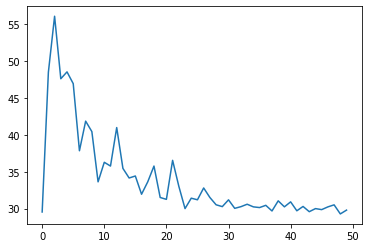

29.791712532427592
0.6838813511444817
0.8662358007146608
house instance is: 5
Epoch: 0; MSE loss: 7174707.405
22.916222294418795
30626.89702196789
Epoch: 1; MSE loss: 6047852.601
54.92069385904129
28274.994315446052
Epoch: 2; MSE loss: 6256349.321
65.14502428692286
28967.803398553853
Epoch: 3; MSE loss: 6235092.297
59.00378115445415
28422.035822805847
Epoch: 4; MSE loss: 6026941.819
79.15027447554783
31058.996745387463
Epoch: 5; MSE loss: 6100711.534
67.96555322013825
29413.351352016034
Epoch: 6; MSE loss: 5953619.786
57.73146383213834
28552.660137830946
Epoch: 7; MSE loss: 6209140.187
51.67099437979949
28199.679458284594
Epoch: 8; MSE loss: 5951646.448
58.55409350241727
28801.331321216807
Epoch: 9; MSE loss: 5851934.086
59.72919985632128
29270.737514771234
Epoch: 10; Test MAE loss on target data is: 59.729
Epoch: 10; Test MSE loss on target data is: 29270.738


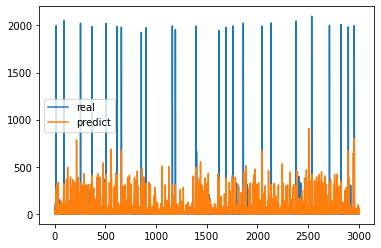

Epoch: 10; Test MAE loss on source data is: 36.896
Epoch: 10; Test MSE loss on source data is: 25017.400


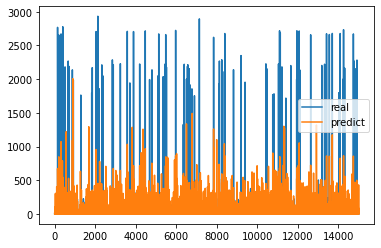

Epoch: 10; MSE loss: 5534902.795
53.44587368154514
28425.325716159055
Epoch: 11; MSE loss: 6083795.985
39.85596448909268
27944.189485799696
Epoch: 12; MSE loss: 5426561.171
46.36912520653438
28155.819255215887
Epoch: 13; MSE loss: 5750420.264
48.87356088481119
28384.605328255006
Epoch: 14; MSE loss: 5773075.916
48.69338067331799
28315.841707600794
Epoch: 15; MSE loss: 5677172.109
47.65954761739855
28345.075777291473
Epoch: 16; MSE loss: 5552483.851
42.30334656775871
28079.397374360753
Epoch: 17; MSE loss: 5577557.442
46.02633505456457
28249.342948630994
Epoch: 18; MSE loss: 5610389.689
45.1577679001777
28300.95023733056
Epoch: 19; MSE loss: 5462876.751
42.30861276919927
28161.61746544305
Epoch: 20; Test MAE loss on target data is: 42.309
Epoch: 20; Test MSE loss on target data is: 28161.617


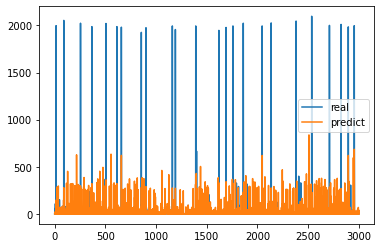

Epoch: 20; Test MAE loss on source data is: 26.758
Epoch: 20; Test MSE loss on source data is: 23530.874


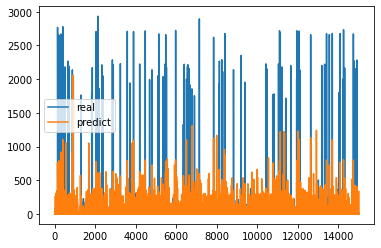

Epoch: 20; MSE loss: 5774618.112
41.463659305596714
27886.06514298786
Epoch: 21; MSE loss: 5641663.657
35.999902560314865
28164.854912169918
Epoch: 22; MSE loss: 5867999.866
43.0918734214317
28091.602384708425
Epoch: 23; MSE loss: 5319804.942
40.18062006573028
28241.47573875398
Epoch: 24; MSE loss: 5794981.703
43.544262875441945
28867.42305668502
Epoch: 25; MSE loss: 5667892.075
45.41246386390234
29058.776441096164
Epoch: 26; MSE loss: 5800934.854
36.93760605077055
28003.022417665525
Epoch: 27; MSE loss: 5632488.700
38.23497817373665
29191.737233468437
Epoch: 28; MSE loss: 5262766.218
29.348414292070423
28102.64141880445
Epoch: 29; MSE loss: 5585145.438
33.44453556387228
27769.73526967448
Epoch: 30; Test MAE loss on target data is: 33.445
Epoch: 30; Test MSE loss on target data is: 27769.735


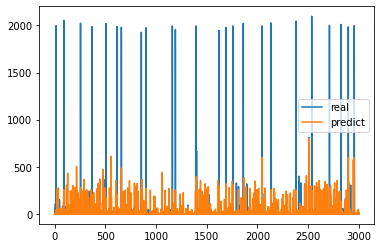

Epoch: 30; Test MAE loss on source data is: 21.706
Epoch: 30; Test MSE loss on source data is: 22731.123


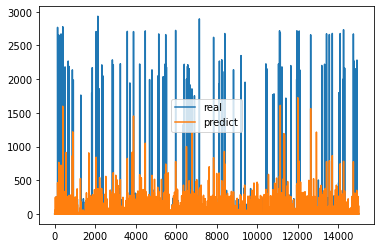

Epoch: 30; MSE loss: 5172028.138
47.89008539730556
29829.07994224369
Epoch: 31; MSE loss: 5546287.325
40.50816958424413
29587.542598184453
Epoch: 32; MSE loss: 5209481.838
40.80974592275412
28355.120136045338
Epoch: 33; MSE loss: 5662226.409
49.96594382083408
29919.681865487124
Epoch: 34; MSE loss: 5353345.787
31.501317282223432
28715.55231862976
Epoch: 35; MSE loss: 5381630.518
43.31485712722678
29570.802082803428
Epoch: 36; MSE loss: 5259780.610
32.07741740887635
28147.199286302257
Epoch: 37; MSE loss: 5463397.587
40.554682747343094
29353.482859623742
Epoch: 38; MSE loss: 5182118.557
33.76327166227145
28194.974884759147
Epoch: 39; MSE loss: 5594782.435
49.69128994296457
31927.856916376833
Epoch: 40; Test MAE loss on target data is: 49.691
Epoch: 40; Test MSE loss on target data is: 31927.857


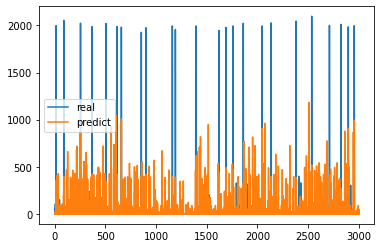

Epoch: 40; Test MAE loss on source data is: 29.386
Epoch: 40; Test MSE loss on source data is: 22197.509


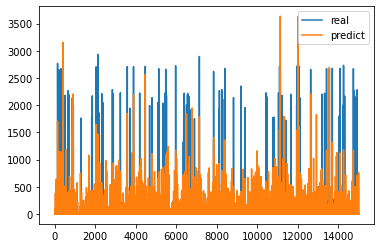

Epoch: 40; MSE loss: 5411685.663
40.25898773724166
28868.964055816577
Epoch: 41; MSE loss: 5054492.521
34.72545406631084
28983.510126978636
Epoch: 42; MSE loss: 5435454.874
43.116402028245076
29465.22351489631
Epoch: 43; MSE loss: 4810816.457
33.69264045798191
28321.623599581926
Epoch: 44; MSE loss: 4722613.537
33.856785366800274
27852.41566029439
Epoch: 45; MSE loss: 5095174.296
39.14041788008972
29063.525157070882
Epoch: 46; MSE loss: 5425119.140
31.266751152419854
27825.36873672957
Epoch: 47; MSE loss: 5310215.187
37.831018378509185
29974.894045483317
Epoch: 48; MSE loss: 5020210.086
34.732731302552786
28637.547390784715
Epoch: 49; MSE loss: 5155988.449
35.82467808460348
27919.198567123658
Epoch: 50; Test MAE loss on target data is: 35.825
Epoch: 50; Test MSE loss on target data is: 27919.199


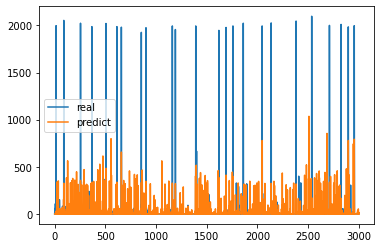

Epoch: 50; Test MAE loss on source data is: 22.959
Epoch: 50; Test MSE loss on source data is: 21349.732


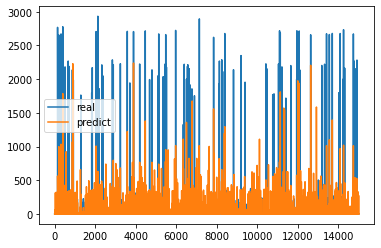

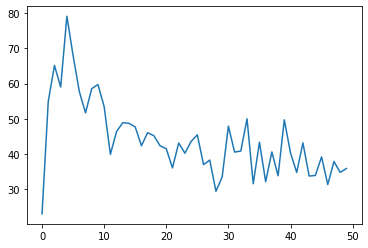

35.82467808460348
0.3180653937254201
0.9236872115072966


In [27]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,2,5]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
                loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/20
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [ ]:
# ######################################dishwasher###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM//training_data/dishwasher_house_3_training_.csv"

# trainfile2="F:/NILM/ukdale_training/dishwasher_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="F:/NILM/refit_training/dishwasher/dishwasher_house_13_training_.csv"
# trainfile4="F:/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=10
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [54]:
######################################dishwasher###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="/content/drive/MyDrive/training_data/dishwasher_house_3_training_.csv"

# trainfile2="/content/drive/MyDrive/ukdale_training/dishwasher_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="/content/drive/MyDrive/refit_training/dishwasher/dishwasher_house_13_training_.csv"
# trainfile4="/content/drive/MyDrive/refit_training/dishwasher/dishwasher_house_18_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
trainfile1="F:/NILM/training_data/dishwasher_test_.csv"
trainfile2="F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile3="F:/NILM/ukdale_training/dishwasher_house_1_training_.csv"
trainfile4="F:/NILM/ukdale_training/dishwasher_house_2_training_.csv"
trainfile5="F:/NILM/refit_training/dishwasher/dishwasher_house_13_training_.csv"
trainfile6="F:/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,2,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=10
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[15017, 15017, 15017, 15017, 15017, 15017]


house instance is: 0
Epoch: 0; MSE loss: 9868078.469
28.27408171431707
22604.197480354567
Epoch: 1; MSE loss: 8359517.355
62.534784295045164
28357.47461467667
Epoch: 2; MSE loss: 8666563.601
63.81903048402961
28673.36678424308
Epoch: 3; MSE loss: 8346024.801
56.28550481650676
26649.910380816655
Epoch: 4; MSE loss: 8396913.323
49.947945674681684
25149.436202689954
Epoch: 5; MSE loss: 8082856.194
67.86758412258047
33460.657054347306
Epoch: 6; MSE loss: 7717782.583
57.178646232491324
28838.418943566237
Epoch: 7; MSE loss: 7850596.210
49.11117565264794
26274.692108541847
Epoch: 8; MSE loss: 7999050.219
56.60535596550186
29898.835420126692
Epoch: 9; MSE loss: 7748804.025
54.88858590739346
30050.376076549594
Epoch: 10; Test MAE loss on target data is: 54.889
Epoch: 10; Test MSE loss on target data is: 30050.376


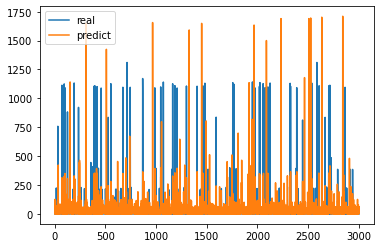

Epoch: 10; Test MAE loss on source data is: 56.458
Epoch: 10; Test MSE loss on source data is: 31519.259


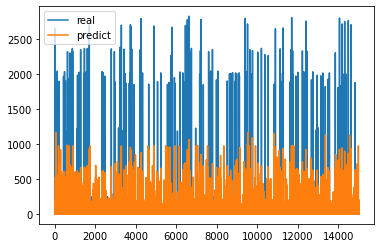

Epoch: 10; MSE loss: 8195239.212
54.68957403829984
30964.782131397504
Epoch: 11; MSE loss: 7589931.088
42.53159914257007
26307.33927174361
Epoch: 12; MSE loss: 7660746.710
58.13449223501268
36406.15923200763
Epoch: 13; MSE loss: 7888434.015
45.44822458065699
28182.370770715166
Epoch: 14; MSE loss: 7836376.421
39.484651270723056
25985.722356750957
Epoch: 15; MSE loss: 7780113.952
39.95563716367978
26771.91026136111
Epoch: 16; MSE loss: 7831383.116
36.52781692348649
25341.271025331695
Epoch: 17; MSE loss: 8393530.401
36.11606937594285
25389.229637868193
Epoch: 18; MSE loss: 7521914.940
51.60342415258506
36161.44748732163
Epoch: 19; MSE loss: 7610394.560
37.28347687575019
27458.267510279846
Epoch: 20; Test MAE loss on target data is: 37.283
Epoch: 20; Test MSE loss on target data is: 27458.268


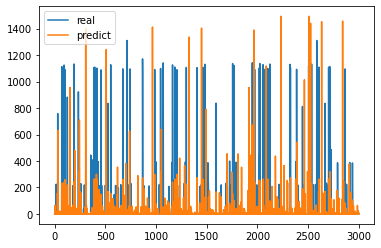

Epoch: 20; Test MAE loss on source data is: 31.267
Epoch: 20; Test MSE loss on source data is: 30790.405


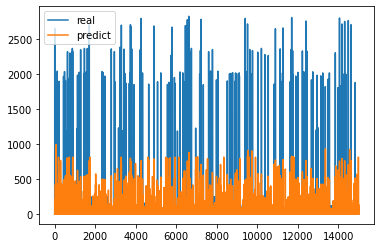

Epoch: 20; MSE loss: 7464591.712
40.20170737249397
30548.21047965159
Epoch: 21; MSE loss: 7515393.433
47.97730524025451
38067.638272251555
Epoch: 22; MSE loss: 7357484.930
38.72617181063135
30670.11911765586
Epoch: 23; MSE loss: 7148418.249
33.81793913743229
27210.32352333598
Epoch: 24; MSE loss: 7598030.529
42.09074378080081
33236.08746661287
Epoch: 25; MSE loss: 7214796.125
43.395977576467864
36011.1082621205
Epoch: 26; MSE loss: 7397114.817
38.54948472736599
32459.052948327535
Epoch: 27; MSE loss: 6845173.838
50.673069872725975
48821.40829611198
Epoch: 28; MSE loss: 7471375.227
43.61067527383764
38066.7059634619
Epoch: 29; MSE loss: 7507590.206
40.20075647102374
35926.64349266069
Epoch: 30; Test MAE loss on target data is: 40.201
Epoch: 30; Test MSE loss on target data is: 35926.643


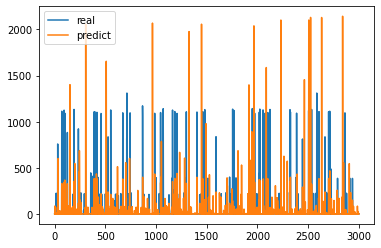

Epoch: 30; Test MAE loss on source data is: 33.538
Epoch: 30; Test MSE loss on source data is: 28493.396


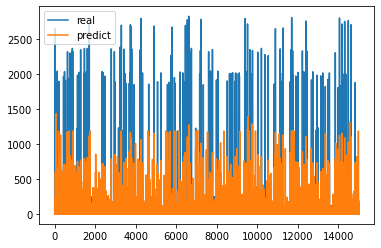

Epoch: 30; MSE loss: 7231105.352
42.65825903207342
40867.15726529738
Epoch: 31; MSE loss: 7509502.329
47.156160863356966
46093.90768866885
Epoch: 32; MSE loss: 7105324.915
42.03051867922359
38668.978193097755
Epoch: 33; MSE loss: 7055454.669
38.5496803847118
35967.02875367777
Epoch: 34; MSE loss: 6988537.747
45.94882208706139
46511.60522220196
Epoch: 35; MSE loss: 7164849.574
36.64142821318459
33082.060491837445
Epoch: 36; MSE loss: 6755021.320
39.7942690977482
39189.54782123337
Epoch: 37; MSE loss: 7110039.347
41.067276920741314
39857.281376128456
Epoch: 38; MSE loss: 6728291.183
40.91139537000783
41563.88555992932
Epoch: 39; MSE loss: 7045577.865
44.556500199095865
48972.00937147772
Epoch: 40; Test MAE loss on target data is: 44.557
Epoch: 40; Test MSE loss on target data is: 48972.009


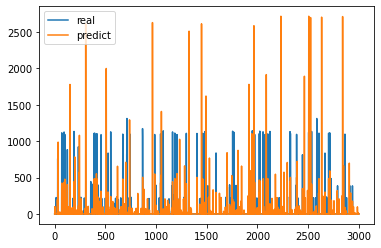

Epoch: 40; Test MAE loss on source data is: 34.795
Epoch: 40; Test MSE loss on source data is: 27619.338


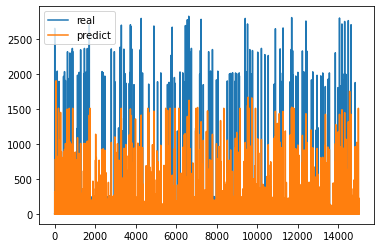

Epoch: 40; MSE loss: 6882377.593
39.518345243147465
39279.039882858575
Epoch: 41; MSE loss: 7022469.666
35.66165729742075
31130.937375914567
Epoch: 42; MSE loss: 6950043.052
36.780244370275106
34242.74200503634
Epoch: 43; MSE loss: 6731746.872
43.693643677409256
47335.15575755091
Epoch: 44; MSE loss: 7508882.362
43.575028808452636
45216.0024961064
Epoch: 45; MSE loss: 7190493.889
45.12360954741028
50461.59995100341
Epoch: 46; MSE loss: 7347606.027
43.37236739883569
46769.4794989282
Epoch: 47; MSE loss: 6979102.701
38.97827608028201
40172.26384264483
Epoch: 48; MSE loss: 7151331.904
39.735412619462345
38595.779491677924
Epoch: 49; MSE loss: 6951997.095
42.158274951216065
45317.72292840999
Epoch: 50; Test MAE loss on target data is: 42.158
Epoch: 50; Test MSE loss on target data is: 45317.723


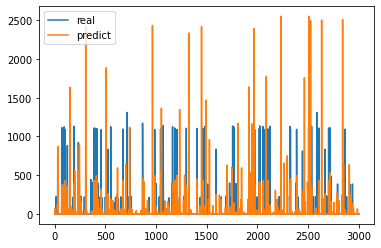

Epoch: 50; Test MAE loss on source data is: 31.343
Epoch: 50; Test MSE loss on source data is: 27393.916


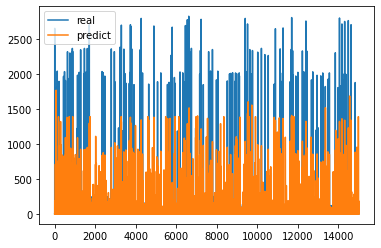

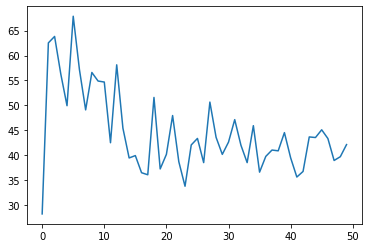

42.158274951216065
0.10122152427066243
1.384590881163536


In [58]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
                loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    #lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/400
                    loss= torch.mean(losses) + 0.5* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [ ]:
# ######################################microwave###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM//training_data/microwave_house_3_training_.csv"

# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="F:/NILM/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile4="F:/NILM/refit_training/microwave/microwave_house_17_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[4,32,32,32]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=200
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [ ]:
#  ######################################microwave###############################################################
# #trainfile4="F:/NILM/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM//training_data/microwave_house_3_training_.csv"

# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"
# # trainfile3="F:/NILM/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="F:/NILM/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile4="F:/NILM/refit_training/microwave/microwave_house_17_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=200
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     X_on=X[Y>0]
#     Y_on=Y[Y>0]
#     X_off=X[Y==0]
#     Y_off=Y[Y==0]
#     ridx = np.random.choice(X_off.shape[0], int(len(Y_on)*50))
#     X_off = X_off[ridx, :]
#     Y_on=Y_on.reshape(-1,1)
#     Y_off=Y_off.reshape(-1,1)
#     Y_off = Y_off[ridx, :]
#     X_pre=np.concatenate([X_on,X_off], axis=0)
#     Y_pre=np.concatenate([Y_on,Y_off], axis=0)
#     on.append(Y_on)
#     data_insts.append(X_pre)
#     data_labels.append(Y_pre)
#     num_insts.append(X_pre.shape[0])
#     # r_order = np.arange(num_insts[i])
#     # np.random.shuffle(r_order)
#     # data_insts[i] = data_insts[i][r_order, :]
#     # data_labels[i] = data_labels[i][r_order,:]
# print(num_insts)
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [177]:
# ######################################microwave###############################################################
#trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="/content/drive/MyDrive/training_data/microwave_house_3_training_.csv"

# trainfile2="/content/drive/MyDrive/ukdale_training/microwave_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="/content/drive/MyDrive/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile4="/content/drive/MyDrive/refit_training/microwave/microwave_house_17_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]

trainfile1="F:/NILM/training_data/microwave_test_.csv"
trainfile2="F:/NILM/training_data/microwave_house_2_training_.csv"
trainfile3="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
trainfile4="F:/NILM/ukdale_training/microwave_house_2_training_.csv"
trainfile5="F:/NILM/refit_training/microwave/microwave_house_10_training_.csv"
trainfile6="F:/NILM/refit_training/microwave/microwave_house_17_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,1,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=200
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    X_on=X[Y>0]
    Y_on=Y[Y>0]
    X_off=X[Y==0]
    Y_off=Y[Y==0]
    ridx = np.random.choice(X_off.shape[0], int(len(Y_on)*50))
    X_off = X_off[ridx, :]
    Y_on=Y_on.reshape(-1,1)
    Y_off=Y_off.reshape(-1,1)
    Y_off = Y_off[ridx, :]
    X_pre=np.concatenate([X_on,X_off], axis=0)
    Y_pre=np.concatenate([Y_on,Y_off], axis=0)
    on.append(Y_on)
    data_insts.append(X_pre)
    data_labels.append(Y_pre)
    num_insts.append(X_pre.shape[0])
    # r_order = np.arange(num_insts[i])
    # np.random.shuffle(r_order)
    # data_insts[i] = data_insts[i][r_order, :]
    # data_labels[i] = data_labels[i][r_order,:]
print(num_insts)
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[13311, 5508, 51816, 4335, 11475, 10302]
[4335, 4335, 4335, 4335, 4335, 4335]


house instance is: 0
Epoch: 0; MSE loss: 2493014.510
24.081457183988153
32875.21688279259
Epoch: 1; MSE loss: 2180314.998
42.5726004176326
29852.29175082737
Epoch: 2; MSE loss: 2073615.771
34.19799525529484
29539.212146844948
Epoch: 3; MSE loss: 2183183.373
36.64731135077829
29045.542130782815
Epoch: 4; MSE loss: 1973010.172
32.356007034825545
29251.460311719653
Epoch: 5; MSE loss: 1846273.385
32.13244681521643
30629.032663502134
Epoch: 6; MSE loss: 1991501.499
29.088244960627417
30172.780618550387
Epoch: 7; MSE loss: 1933550.551
33.9283031887165
30958.635439134425
Epoch: 8; MSE loss: 1805795.530
31.579035640068668
30481.866651585053
Epoch: 9; MSE loss: 1935860.835
34.82543846328343
29803.58121455994
Epoch: 10; Test MAE loss on target data is: 34.825
Epoch: 10; Test MSE loss on target data is: 29803.581


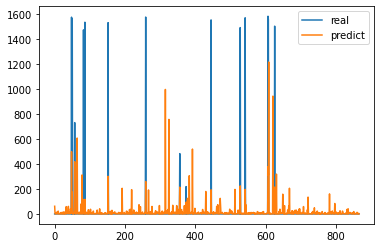

Epoch: 10; Test MAE loss on source data is: 40.094
Epoch: 10; Test MSE loss on source data is: 28029.152


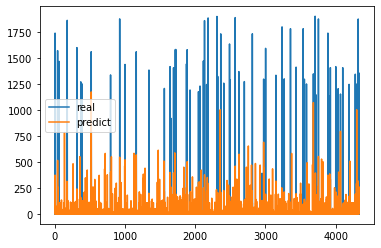

Epoch: 10; MSE loss: 1925945.183
32.33513838434159
29908.53180970541
Epoch: 11; MSE loss: 1749723.699
30.3726221503291
30170.733352995714
Epoch: 12; MSE loss: 1865344.239
30.23432118619403
29728.75994062796
Epoch: 13; MSE loss: 1980306.041
34.68447091690236
29732.640725123816
Epoch: 14; MSE loss: 1824179.535
31.06991899177942
29306.054831609654
Epoch: 15; MSE loss: 1963560.711
34.322464662592935
29440.54044036526
Epoch: 16; MSE loss: 1794370.002
30.890125129953198
29302.631275663018
Epoch: 17; MSE loss: 1904168.394
31.86044664691127
29392.261629513217
Epoch: 18; MSE loss: 1712105.090
33.59659718202698
29580.068399072043
Epoch: 19; MSE loss: 1964457.641
32.028711000022
29176.64824856156
Epoch: 20; Test MAE loss on target data is: 32.029
Epoch: 20; Test MSE loss on target data is: 29176.648


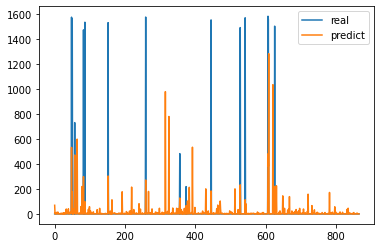

Epoch: 20; Test MAE loss on source data is: 36.537
Epoch: 20; Test MSE loss on source data is: 27534.224


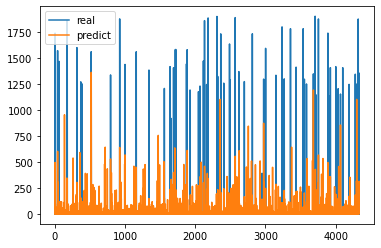

Epoch: 20; MSE loss: 1709546.883
32.08173235705691
28969.195285779813
Epoch: 21; MSE loss: 1751346.161
31.129047452843462
29142.66562535302
Epoch: 22; MSE loss: 1995800.388
30.693038358814622
28817.225119331983
Epoch: 23; MSE loss: 1656195.135
35.0461386178145
28872.612759577834
Epoch: 24; MSE loss: 1865377.237
31.744243676757197
28682.579612402977
Epoch: 25; MSE loss: 1827765.908
28.321417212258183
28774.510168059544
Epoch: 26; MSE loss: 1803247.677
32.80817953353087
29788.70599692116
Epoch: 27; MSE loss: 1798895.361
29.93587669209491
28823.699736858744
Epoch: 28; MSE loss: 1779056.283
30.21380539432953
28430.815425032994
Epoch: 29; MSE loss: 1768986.123
30.577109676089336
28415.957270891035
Epoch: 30; Test MAE loss on target data is: 30.577
Epoch: 30; Test MSE loss on target data is: 28415.957


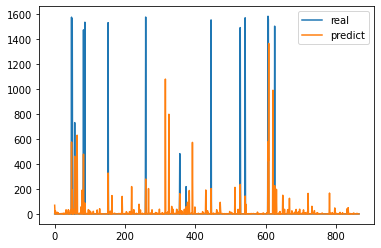

Epoch: 30; Test MAE loss on source data is: 35.632
Epoch: 30; Test MSE loss on source data is: 27337.334


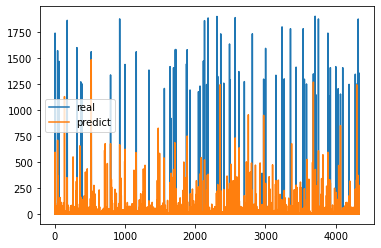

Epoch: 30; MSE loss: 1740793.111
31.346073082473843
28231.117248978615
Epoch: 31; MSE loss: 1858181.367
31.107534793946392
28076.426932838367
Epoch: 32; MSE loss: 1846769.521
31.84437083702009
28508.670762116315
Epoch: 33; MSE loss: 1936461.818
32.81210308988901
27987.105288346367
Epoch: 34; MSE loss: 1793922.051
33.812013206093276
28085.196836434134
Epoch: 35; MSE loss: 1951659.203
30.087052762748655
28094.55192526233
Epoch: 36; MSE loss: 1716375.254
28.032209950560645
27766.61429519196
Epoch: 37; MSE loss: 1800500.179
32.1505248292755
27980.043413429594
Epoch: 38; MSE loss: 1729544.792
29.76480298822188
27683.386077175805
Epoch: 39; MSE loss: 1847423.598
28.368026997415676
27404.098389365216
Epoch: 40; Test MAE loss on target data is: 28.368
Epoch: 40; Test MSE loss on target data is: 27404.098


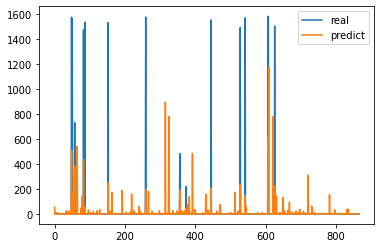

Epoch: 40; Test MAE loss on source data is: 33.127
Epoch: 40; Test MSE loss on source data is: 26708.066


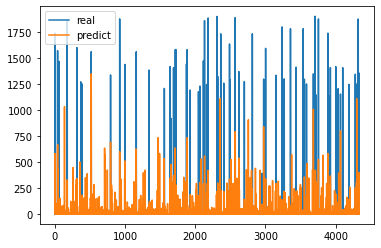

Epoch: 40; MSE loss: 1768182.778
30.360837961501606
27567.800913328505
Epoch: 41; MSE loss: 1816335.100
29.53679967901796
27652.35912913042
Epoch: 42; MSE loss: 1758188.219
31.97888994602195
27638.242537762737
Epoch: 43; MSE loss: 1826671.674
30.14123224548105
27506.584843709694
Epoch: 44; MSE loss: 1794128.303
29.16104960738782
27059.51186613036
Epoch: 45; MSE loss: 1849618.247
29.84465316769276
26619.200925177287
Epoch: 46; MSE loss: 1630471.754
27.324161130967898
26554.264465196597
Epoch: 47; MSE loss: 1691479.864
30.396721062636786
26482.760077140316
Epoch: 48; MSE loss: 1752651.001
30.479395070989423
26927.187054446396
Epoch: 49; MSE loss: 1743806.387
30.70911579441798
27329.910857256476
Epoch: 50; Test MAE loss on target data is: 30.709
Epoch: 50; Test MSE loss on target data is: 27329.911


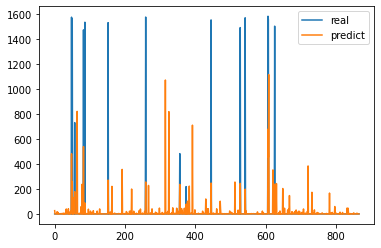

Epoch: 50; Test MAE loss on source data is: 34.717
Epoch: 50; Test MSE loss on source data is: 25648.962


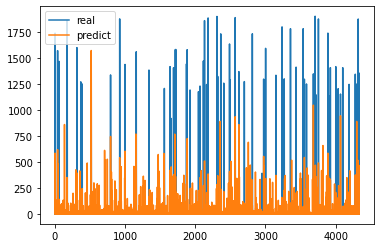

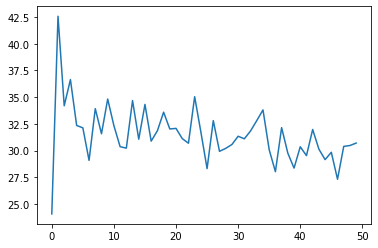

30.70911579441798
0.2213533954254228
0.8964329352979066
house instance is: 2
Epoch: 0; MSE loss: 2277481.005
36.03360283531188
51843.30297819403
Epoch: 1; MSE loss: 1981313.845
46.09024889603034
44831.728275759204
Epoch: 2; MSE loss: 1886728.256
51.580754713684904
40497.77276266793
Epoch: 3; MSE loss: 1865522.688
40.8779035266854
41800.508552662504
Epoch: 4; MSE loss: 1806577.864
40.38559606063986
40924.41767145935
Epoch: 5; MSE loss: 1600008.572
36.92341360704159
44914.63538743181
Epoch: 6; MSE loss: 1801955.824
47.37654117800321
38606.76523773876
Epoch: 7; MSE loss: 1830074.523
38.583179088496316
41195.7839972605
Epoch: 8; MSE loss: 1921052.966
43.748574836377266
39008.52086104276
Epoch: 9; MSE loss: 1863033.050
38.99196688739546
42063.603922943
Epoch: 10; Test MAE loss on target data is: 38.992
Epoch: 10; Test MSE loss on target data is: 42063.604


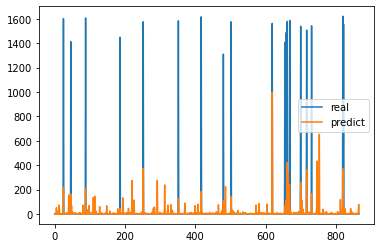

Epoch: 10; Test MAE loss on source data is: 29.831
Epoch: 10; Test MSE loss on source data is: 24736.396


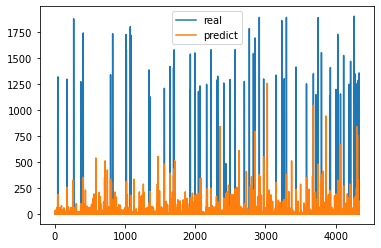

Epoch: 10; MSE loss: 1792030.241
40.74720832485718
40771.59481019238
Epoch: 11; MSE loss: 1832034.765
42.427344131664796
39109.72477524926
Epoch: 12; MSE loss: 1701024.537
39.28650923114111
40008.6720349714
Epoch: 13; MSE loss: 1799379.399
38.44097835435226
40369.69195852959
Epoch: 14; MSE loss: 1767579.156
41.671596556102735
39921.54132889851
Epoch: 15; MSE loss: 1735377.072
42.4077915704778
39648.2537384258
Epoch: 16; MSE loss: 1908594.457
40.197743775681815
40570.39004519653
Epoch: 17; MSE loss: 1784886.583
41.34819947867606
38655.14638818505
Epoch: 18; MSE loss: 1779513.953
38.701139932900084
40421.96152664229
Epoch: 19; MSE loss: 1955143.393
42.682670498131465
38979.695441446514
Epoch: 20; Test MAE loss on target data is: 42.683
Epoch: 20; Test MSE loss on target data is: 38979.695


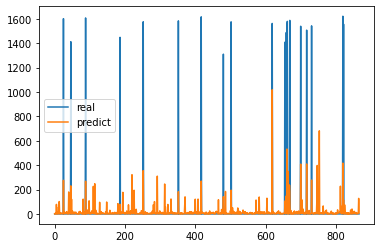

Epoch: 20; Test MAE loss on source data is: 34.851
Epoch: 20; Test MSE loss on source data is: 24324.844


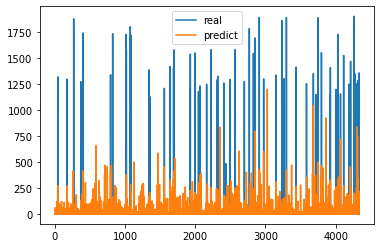

Epoch: 20; MSE loss: 1735809.476
40.025273038660885
40694.53395782517
Epoch: 21; MSE loss: 1817958.818
40.77833816457235
37929.21201884784
Epoch: 22; MSE loss: 1616601.957
35.43913414948453
43469.78438912254
Epoch: 23; MSE loss: 1834895.417
43.71361730664522
37403.42975043459
Epoch: 24; MSE loss: 1702570.000
38.64459193194115
40463.146716973824
Epoch: 25; MSE loss: 1688429.333
40.26060896667608
38050.51126003239
Epoch: 26; MSE loss: 1871486.230
37.551212568300095
39270.49057487533
Epoch: 27; MSE loss: 1791318.007
38.4610033852393
39949.397979026195
Epoch: 28; MSE loss: 1757707.345
44.75475520667681
36897.38101125155
Epoch: 29; MSE loss: 1800828.636
38.06795854244334
38344.096382481264
Epoch: 30; Test MAE loss on target data is: 38.068
Epoch: 30; Test MSE loss on target data is: 38344.096


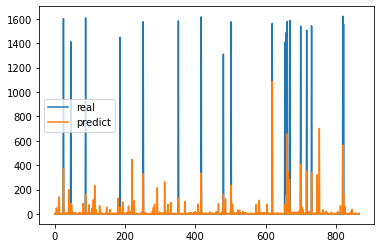

Epoch: 30; Test MAE loss on source data is: 30.340
Epoch: 30; Test MSE loss on source data is: 23420.796


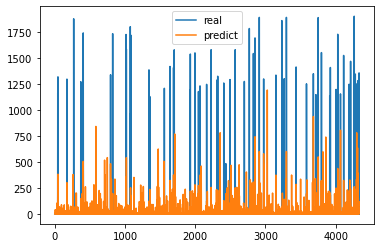

Epoch: 30; MSE loss: 1834689.032
40.216273687883024
35338.91035862115
Epoch: 31; MSE loss: 1760255.764
36.32491282941269
39002.06190820358
Epoch: 32; MSE loss: 1670504.270
40.274312482564575
34873.41285787391
Epoch: 33; MSE loss: 1877241.155
37.741139893936726
37202.717023415
Epoch: 34; MSE loss: 1806349.658
40.231770166794256
36717.43383135446
Epoch: 35; MSE loss: 1637884.320
36.81556273100956
37263.68946684811
Epoch: 36; MSE loss: 1715253.203
36.39443606865241
37618.22848822593
Epoch: 37; MSE loss: 1747033.057
39.87789764436609
37424.51482640047
Epoch: 38; MSE loss: 1736600.202
39.42074376535457
36720.53361870472
Epoch: 39; MSE loss: 1736880.220
37.317909638035395
36618.33083156874
Epoch: 40; Test MAE loss on target data is: 37.318
Epoch: 40; Test MSE loss on target data is: 36618.331


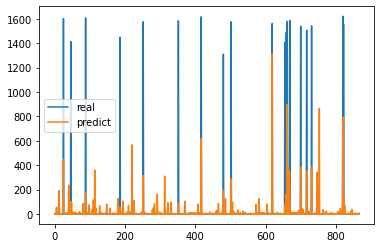

Epoch: 40; Test MAE loss on source data is: 30.244
Epoch: 40; Test MSE loss on source data is: 22387.123


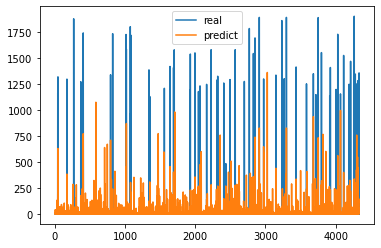

Epoch: 40; MSE loss: 1712187.254
38.69453091157177
36551.071131069875
Epoch: 41; MSE loss: 1621681.216
37.91451300140105
38420.09071332648
Epoch: 42; MSE loss: 1752906.363
39.81443209898891
35499.46180596925
Epoch: 43; MSE loss: 1879886.337
36.22605698545396
38366.5390530625
Epoch: 44; MSE loss: 1651443.761
38.484458724064744
39755.16978520377
Epoch: 45; MSE loss: 1841951.601
39.788462473859425
35775.62634115551
Epoch: 46; MSE loss: 1610785.632
38.445526596257565
36537.74666990419
Epoch: 47; MSE loss: 1569284.394
36.8488243774628
37491.283537482836
Epoch: 48; MSE loss: 1557887.231
36.885490969657006
36680.829574419564
Epoch: 49; MSE loss: 1550269.555
37.286218027789424
35677.663036859565
Epoch: 50; Test MAE loss on target data is: 37.286
Epoch: 50; Test MSE loss on target data is: 35677.663


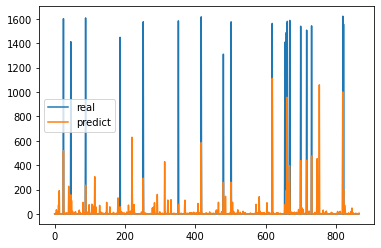

Epoch: 50; Test MAE loss on source data is: 30.064
Epoch: 50; Test MSE loss on source data is: 21414.383


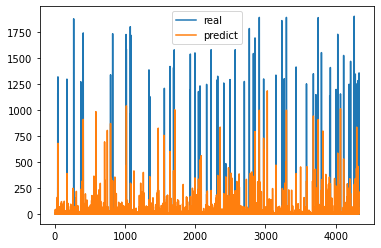

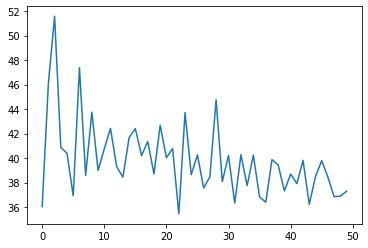

37.286218027789424
0.4502575080507093
0.8100126488989714
house instance is: 5
Epoch: 0; MSE loss: 2332997.218
23.414195439218616
26455.44711321972
Epoch: 1; MSE loss: 2086286.147
56.171017918254506
30044.934882449932
Epoch: 2; MSE loss: 2075144.061
36.3090653918198
25332.286996525843
Epoch: 3; MSE loss: 2000345.576
65.44500869627711
35361.15000556783
Epoch: 4; MSE loss: 1971651.050
48.76585603166788
29089.354193985506
Epoch: 5; MSE loss: 1885934.971
57.92677088890218
36638.20059085346
Epoch: 6; MSE loss: 1838876.974
49.08976510910461
33704.65841763396
Epoch: 7; MSE loss: 1713544.435
53.06162893055426
37759.1226506491
Epoch: 8; MSE loss: 1931534.406
49.24707365561934
34307.58162766656
Epoch: 9; MSE loss: 1805881.795
47.87500676935304
32345.541010149518
Epoch: 10; Test MAE loss on target data is: 47.875
Epoch: 10; Test MSE loss on target data is: 32345.541


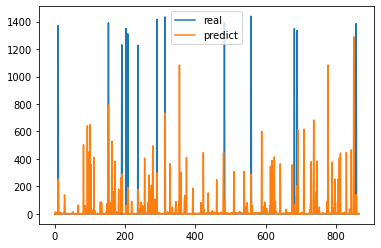

Epoch: 10; Test MAE loss on source data is: 34.370
Epoch: 10; Test MSE loss on source data is: 26583.449


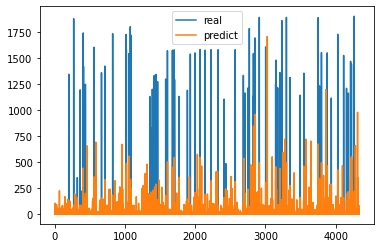

Epoch: 10; MSE loss: 1902608.355
52.21571078324302
33970.61554584273
Epoch: 11; MSE loss: 1899177.437
54.596019021627484
36039.30347469104
Epoch: 12; MSE loss: 1815825.477
55.016108020963934
37470.25330476875
Epoch: 13; MSE loss: 1877167.550
61.33899376200213
42791.74516333501
Epoch: 14; MSE loss: 1951225.795
43.36585913622599
30915.667340004475
Epoch: 15; MSE loss: 1878779.204
42.820862002737364
28578.836686930492
Epoch: 16; MSE loss: 2104522.141
66.38646249149978
39353.54640690421
Epoch: 17; MSE loss: 1839814.741
41.32962120761676
29418.50510837069
Epoch: 18; MSE loss: 1899404.995
47.94356757744442
32360.54748987133
Epoch: 19; MSE loss: 1845705.078
50.72321597057703
32721.99476028489
Epoch: 20; Test MAE loss on target data is: 50.723
Epoch: 20; Test MSE loss on target data is: 32721.995


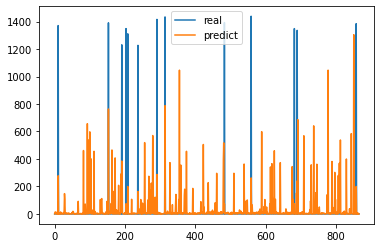

Epoch: 20; Test MAE loss on source data is: 37.021
Epoch: 20; Test MSE loss on source data is: 26224.650


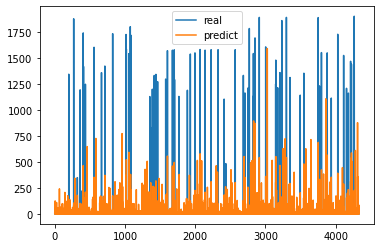

Epoch: 20; MSE loss: 1830509.567
56.16136421792579
35830.44073235428
Epoch: 21; MSE loss: 1917591.594
50.555633166471914
32809.50804591203
Epoch: 22; MSE loss: 1889628.019
51.45121003076597
33368.364435174626
Epoch: 23; MSE loss: 1859250.823
56.00162871333211
37931.843439327764
Epoch: 24; MSE loss: 1933377.051
53.32426792669358
38558.405735493674
Epoch: 25; MSE loss: 1936597.531
44.46709381824203
29916.766926460157
Epoch: 26; MSE loss: 1944466.067
58.893670464965766
34494.003752995595
Epoch: 27; MSE loss: 1771479.657
49.13352488146315
32156.38970330797
Epoch: 28; MSE loss: 1832222.522
53.644510621331726
37102.94900735877
Epoch: 29; MSE loss: 1976915.168
46.648787295675675
32590.23661333004
Epoch: 30; Test MAE loss on target data is: 46.649
Epoch: 30; Test MSE loss on target data is: 32590.237


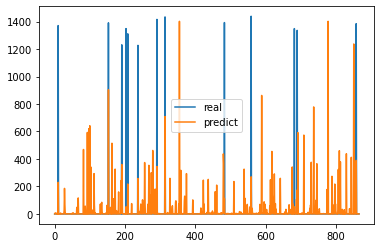

Epoch: 30; Test MAE loss on source data is: 32.600
Epoch: 30; Test MSE loss on source data is: 25469.176


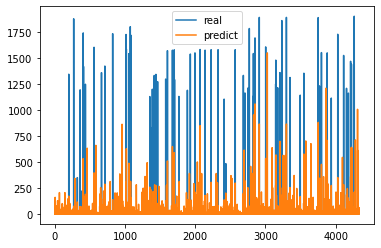

Epoch: 30; MSE loss: 1913535.930
68.65441091020936
46977.43124823019
Epoch: 31; MSE loss: 1802895.684
42.00302431324009
31475.146924703655
Epoch: 32; MSE loss: 1775127.107
51.14432872079889
36787.41020294152
Epoch: 33; MSE loss: 1925621.106
56.57165136415567
37596.96403537993
Epoch: 34; MSE loss: 1755180.372
43.269397060604895
29818.504848885077
Epoch: 35; MSE loss: 1812343.435
50.049267335615475
31963.294139553665
Epoch: 36; MSE loss: 1816886.434
52.95348129589046
33473.65216041124
Epoch: 37; MSE loss: 1655601.460
46.76152607111954
32734.101015375494
Epoch: 38; MSE loss: 2027489.715
51.990280501097615
35302.68590570178
Epoch: 39; MSE loss: 1709251.967
53.85658372172091
35919.48118221095
Epoch: 40; Test MAE loss on target data is: 53.857
Epoch: 40; Test MSE loss on target data is: 35919.481


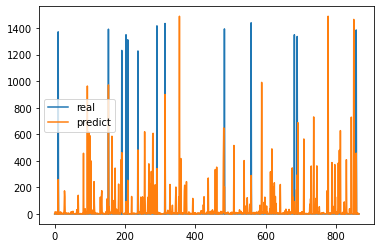

Epoch: 40; Test MAE loss on source data is: 38.920
Epoch: 40; Test MSE loss on source data is: 24418.766


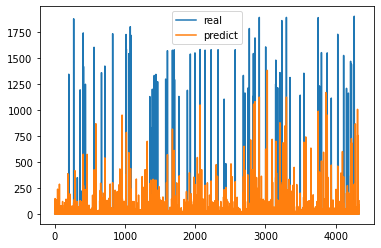

Epoch: 40; MSE loss: 1625850.194
47.60739604315818
34555.117861525774
Epoch: 41; MSE loss: 1669748.220
53.506302703979756
36731.57650710143
Epoch: 42; MSE loss: 1805854.635
50.895838788241115
33686.67173262921
Epoch: 43; MSE loss: 1886266.022
49.21479394302124
33399.60714752164
Epoch: 44; MSE loss: 1563857.877
45.55368928855334
31908.635326034462
Epoch: 45; MSE loss: 1756295.452
45.94589000266376
33573.82790314376
Epoch: 46; MSE loss: 1674975.069
46.462526296932495
33495.195147357255
Epoch: 47; MSE loss: 1737306.603
49.20664832149788
35069.22450317728
Epoch: 48; MSE loss: 1645686.087
40.79174743218921
31127.161393431008
Epoch: 49; MSE loss: 1625830.252
53.542077706213675
37677.112304700866
Epoch: 50; Test MAE loss on target data is: 53.542
Epoch: 50; Test MSE loss on target data is: 37677.112


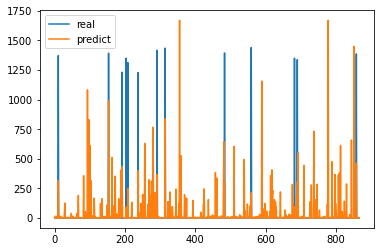

Epoch: 50; Test MAE loss on source data is: 37.935
Epoch: 50; Test MSE loss on source data is: 23668.494


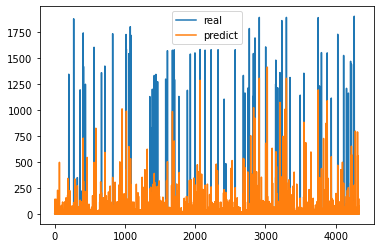

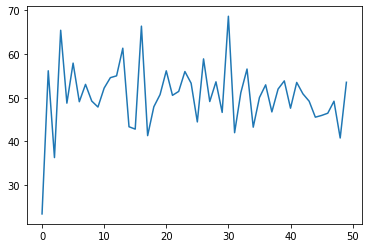

53.542077706213675
1.205442342048548
1.167399298070998


In [183]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.0001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,2,5]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 2
Epoch: 0; MSE loss: 2485088.131
25.287878972239742
34220.656330636164
Epoch: 1; MSE loss: 2138102.219
46.44303764631454
30232.849641690318
Epoch: 2; MSE loss: 2254554.856
46.05829262128476
29818.36687928549
Epoch: 3; MSE loss: 2016139.728
39.12569494457806
30513.90417567496
Epoch: 4; MSE loss: 2183781.557
39.31552577150219
30545.23487181179
Epoch: 5; MSE loss: 2172132.914
32.00291303628647
29452.445373781906
Epoch: 6; MSE loss: 2121390.941
37.6956517151992
28557.6762461592
Epoch: 7; MSE loss: 2217145.237
33.58915200320662
29490.53658086344
Epoch: 8; MSE loss: 1970203.725
33.639694239432906
29712.784110141933
Epoch: 9; MSE loss: 2080664.277
36.527996977274505
28512.937328943324
Epoch: 10; Test MAE loss on target data is: 36.528
Epoch: 10; Test MSE loss on target data is: 28512.937


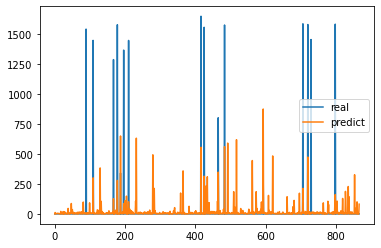

Epoch: 10; Test MAE loss on source data is: 41.900
Epoch: 10; Test MSE loss on source data is: 31315.108


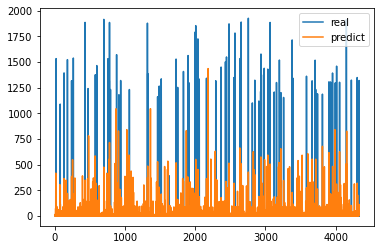

Epoch: 10; MSE loss: 2183055.321
35.98885392756207
28149.83497643663
Epoch: 11; MSE loss: 2114617.234
34.76942531678142
28925.50280816689
Epoch: 12; MSE loss: 2062517.104
31.670206489748264
29374.197473822333
Epoch: 13; MSE loss: 2149807.742
40.9421360943243
29280.62565112307
Epoch: 14; MSE loss: 2096167.352
33.555443597815696
28221.370179581532
Epoch: 15; MSE loss: 2111977.218
39.555132478647444
30118.78797509995
Epoch: 16; MSE loss: 2089272.543
35.426505472332735
29564.469128311288
Epoch: 17; MSE loss: 2212376.155
40.516637312895014
28354.668137935547
Epoch: 18; MSE loss: 2059871.306
32.974992501980175
27953.570213539548
Epoch: 19; MSE loss: 1954308.585
36.271065136765785
29081.426975321243
Epoch: 20; Test MAE loss on target data is: 36.271
Epoch: 20; Test MSE loss on target data is: 29081.427


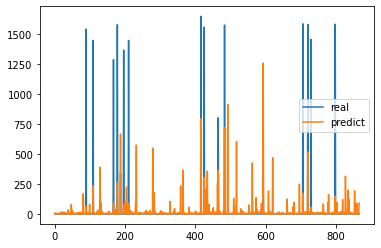

Epoch: 20; Test MAE loss on source data is: 40.441
Epoch: 20; Test MSE loss on source data is: 30079.921


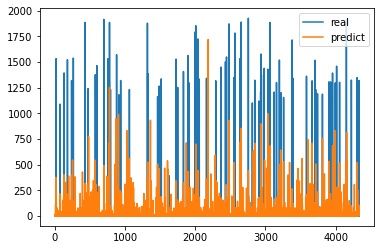

Epoch: 20; MSE loss: 2142524.040
39.636018636010185
29481.915464770027
Epoch: 21; MSE loss: 1971893.435
32.71432923983606
27337.77285668465
Epoch: 22; MSE loss: 1895151.883
33.52670027500162
27929.61046416877
Epoch: 23; MSE loss: 2064035.995
36.50429041617074
28997.60772387666
Epoch: 24; MSE loss: 2142069.860
36.59263740719705
28752.384282527637
Epoch: 25; MSE loss: 1837279.466
34.883077280151184
28141.47072783987
Epoch: 26; MSE loss: 2183334.960
39.149302639380835
28250.94807492608
Epoch: 27; MSE loss: 1960888.712
33.01343074566636
28423.467369531678
Epoch: 28; MSE loss: 2118710.341
37.27343326051652
27864.00256636998
Epoch: 29; MSE loss: 1924771.215
34.949280406321556
28175.280206339194
Epoch: 30; Test MAE loss on target data is: 34.949
Epoch: 30; Test MSE loss on target data is: 28175.280


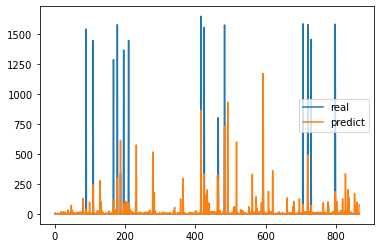

Epoch: 30; Test MAE loss on source data is: 38.993
Epoch: 30; Test MSE loss on source data is: 28997.784


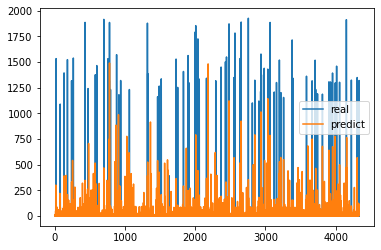

Epoch: 30; MSE loss: 1949889.040
32.912891624864905
28176.82146829925
Epoch: 31; MSE loss: 2092119.500
39.82189465885619
27379.429060031704
Epoch: 32; MSE loss: 2137124.515
36.427540477208424
28559.980914556993
Epoch: 33; MSE loss: 2073272.185
31.87454354301559
27147.549536593637
Epoch: 34; MSE loss: 2095861.027
36.68063341960904
27547.57619638177
Epoch: 35; MSE loss: 1990712.622
31.206158432495084
28224.836821820118
Epoch: 36; MSE loss: 1941864.918
38.954749206502115
28307.552638581157
Epoch: 37; MSE loss: 1957224.269
36.66566443292912
28297.35728466478
Epoch: 38; MSE loss: 1920945.299
33.28134979085939
30188.312774580347
Epoch: 39; MSE loss: 2010252.653
39.32486491512632
26797.6986239217
Epoch: 40; Test MAE loss on target data is: 39.325
Epoch: 40; Test MSE loss on target data is: 26797.699


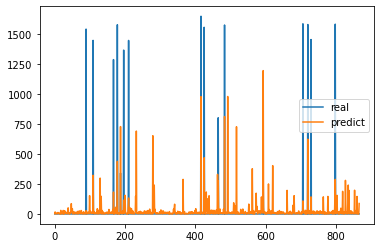

Epoch: 40; Test MAE loss on source data is: 43.891
Epoch: 40; Test MSE loss on source data is: 28872.169


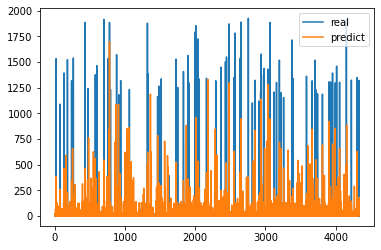

Epoch: 40; MSE loss: 1890149.723
35.263528661523125
28701.980694804784
Epoch: 41; MSE loss: 1905229.273
32.895687785055465
30201.036687008916
Epoch: 42; MSE loss: 1991727.767
36.06355661838697
26048.05785920098
Epoch: 43; MSE loss: 1973967.569
32.65764797430361
26931.9034388732
Epoch: 44; MSE loss: 1836367.135
33.888330152019805
29883.90781293309
Epoch: 45; MSE loss: 1906950.231
37.637457427703005
29287.345913122655
Epoch: 46; MSE loss: 1845436.448
35.19613478516659
27617.93538458042
Epoch: 47; MSE loss: 1996986.532
34.122153629390944
27348.38415131642
Epoch: 48; MSE loss: 1895731.616
38.393599537460105
28280.339151758537
Epoch: 49; MSE loss: 1899020.423
29.073053605622487
28274.177546590687
Epoch: 50; Test MAE loss on target data is: 29.073
Epoch: 50; Test MSE loss on target data is: 28274.178


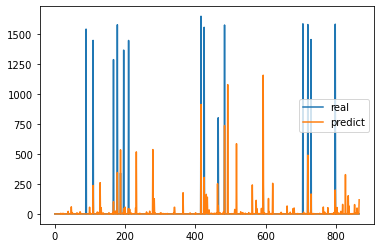

Epoch: 50; Test MAE loss on source data is: 31.735
Epoch: 50; Test MSE loss on source data is: 27870.990


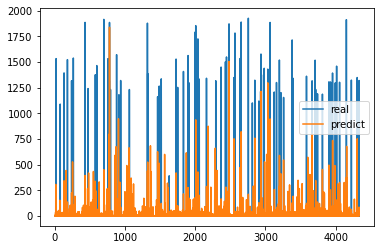

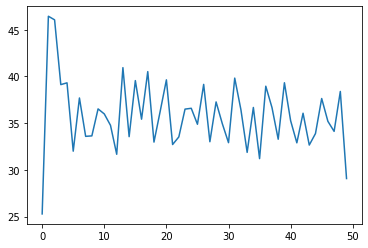

29.073053605622487
0.3964837247943121
0.8956237781906059


In [176]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [2]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 2437078.329
29.060040840434368
40147.95669753062
Epoch: 1; MSE loss: 2221432.746
47.74146843891518
33971.36658495408
Epoch: 2; MSE loss: 2106620.874
43.937067934136834
32514.096592064383
Epoch: 3; MSE loss: 1896230.527
36.90940357317596
30818.567297820056
Epoch: 4; MSE loss: 1929096.869
35.17118419554501
29527.92989285799
Epoch: 5; MSE loss: 2027747.499
30.947567349720334
30592.09461154333
Epoch: 6; MSE loss: 1996271.688
33.49173280536793
30075.95075481483
Epoch: 7; MSE loss: 2069691.954
32.766859703049526
30090.45811699269
Epoch: 8; MSE loss: 1877096.087
32.33106402221384
29937.644530942503
Epoch: 9; MSE loss: 1838516.393
32.888380033609636
29914.063958418763
Epoch: 10; Test MAE loss on target data is: 32.888
Epoch: 10; Test MSE loss on target data is: 29914.064


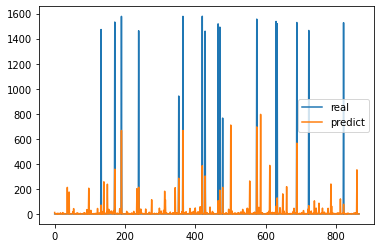

Epoch: 10; Test MAE loss on source data is: 38.939
Epoch: 10; Test MSE loss on source data is: 28181.718


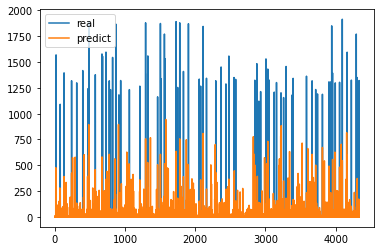

Epoch: 10; MSE loss: 1941507.992
35.07651755250689
29080.732833509977
Epoch: 11; MSE loss: 1913800.743
31.048797704010607
30395.616142212995
Epoch: 12; MSE loss: 1996821.055
30.9528089688246
30358.003781448846
Epoch: 13; MSE loss: 2039629.326
37.485699885272375
28530.536849220793
Epoch: 14; MSE loss: 2034090.322
30.335407351601866
29466.976445854423
Epoch: 15; MSE loss: 1834560.446
32.67935803052223
28590.254354863537
Epoch: 16; MSE loss: 1975052.362
38.03081904506394
28242.57274887027
Epoch: 17; MSE loss: 2000698.525
33.29593242163477
29524.924694986046
Epoch: 18; MSE loss: 2072436.501
34.69115958391176
27680.538590691573
Epoch: 19; MSE loss: 1802084.215
29.76891240535998
29095.74873778782
Epoch: 20; Test MAE loss on target data is: 29.769
Epoch: 20; Test MSE loss on target data is: 29095.749


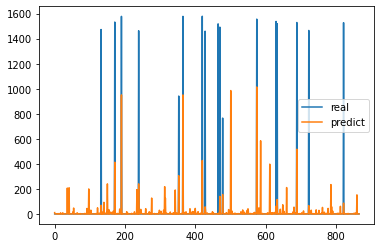

Epoch: 20; Test MAE loss on source data is: 35.956
Epoch: 20; Test MSE loss on source data is: 27303.880


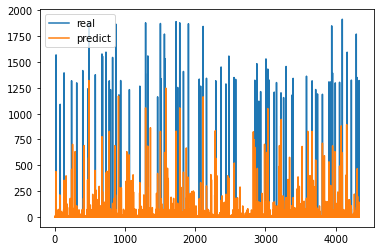

Epoch: 20; MSE loss: 1848331.464
34.07753466236412
28653.96019670571
Epoch: 21; MSE loss: 1814860.227
31.030192043361573
29241.450004860537
Epoch: 22; MSE loss: 1835846.242
32.97067265997983
27954.13911207169
Epoch: 23; MSE loss: 1741704.837
30.632534772011578
28366.559367948605
Epoch: 24; MSE loss: 1830364.557
34.572330488367896
28183.14251459521
Epoch: 25; MSE loss: 1753464.401
30.471134336211964
28280.03538331938
Epoch: 26; MSE loss: 1963562.005
30.350043656985516
28132.3194065901
Epoch: 27; MSE loss: 1898650.108
35.118558907849156
26968.847679965394
Epoch: 28; MSE loss: 2062440.736
28.82163283284947
29389.623609301885
Epoch: 29; MSE loss: 1850671.843
36.22315651561631
27946.90373265193
Epoch: 30; Test MAE loss on target data is: 36.223
Epoch: 30; Test MSE loss on target data is: 27946.904


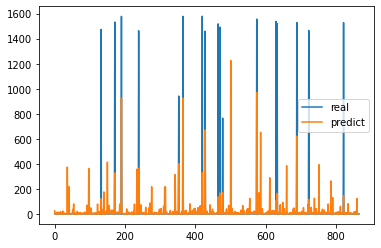

Epoch: 30; Test MAE loss on source data is: 44.478
Epoch: 30; Test MSE loss on source data is: 27081.961


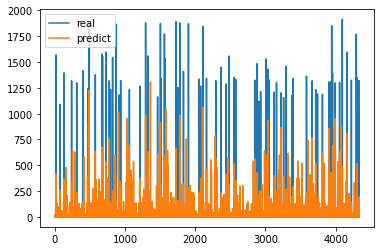

Epoch: 30; MSE loss: 1741806.462
30.55059909508612
28451.900246891197
Epoch: 31; MSE loss: 1875833.927
30.266838156535464
26212.600750899113
Epoch: 32; MSE loss: 1837321.931
29.01344718880234
26416.06908250615
Epoch: 33; MSE loss: 1849688.226
30.05215492033246
26984.65829865894
Epoch: 34; MSE loss: 1826756.510
32.676961901166926
27782.827489866093
Epoch: 35; MSE loss: 1702855.999
30.678876135322117
28732.271080327148
Epoch: 36; MSE loss: 1804656.824
29.165768707860714
27794.237227728907
Epoch: 37; MSE loss: 1708662.992
31.536627818908727
27442.5808434338
Epoch: 38; MSE loss: 1691030.575
29.23679483079941
28522.370776171854
Epoch: 39; MSE loss: 1796580.385
27.914634614843433
28315.801447144862
Epoch: 40; Test MAE loss on target data is: 27.915
Epoch: 40; Test MSE loss on target data is: 28315.801


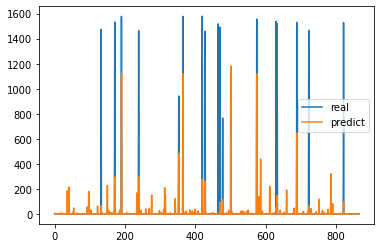

Epoch: 40; Test MAE loss on source data is: 32.358
Epoch: 40; Test MSE loss on source data is: 25514.328


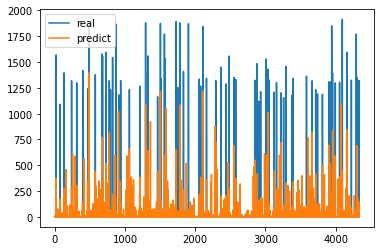

Epoch: 40; MSE loss: 1728996.027
29.64659197871695
26790.809674192882
Epoch: 41; MSE loss: 1774652.942
28.37814791685329
27272.012034882366
Epoch: 42; MSE loss: 1807497.722
30.877906581277358
28171.163679838224
Epoch: 43; MSE loss: 1851231.025
33.73753800135291
26408.753856092397
Epoch: 44; MSE loss: 1771031.684
26.93551419402076
27809.58199321368
Epoch: 45; MSE loss: 1644107.500
30.840222285821984
27153.916772880322
Epoch: 46; MSE loss: 1778735.761
32.17922209049849
26429.068322748375
Epoch: 47; MSE loss: 1622819.883
34.18589730552186
27045.07134151566
Epoch: 48; MSE loss: 1782037.777
29.04123639919491
29023.5059880418
Epoch: 49; MSE loss: 1749692.164
27.745702799749072
27626.887950442284
Epoch: 50; Test MAE loss on target data is: 27.746
Epoch: 50; Test MSE loss on target data is: 27626.888


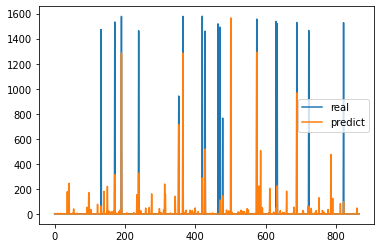

Epoch: 50; Test MAE loss on source data is: 32.665
Epoch: 50; Test MSE loss on source data is: 24563.225


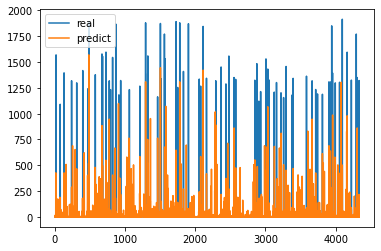

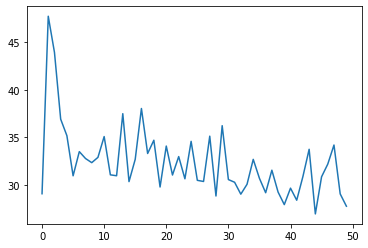

27.745702799749072
0.3875677200183561
0.8136824918324226
house instance is: 3
Epoch: 0; MSE loss: 2971825.446
23.727717707812303
28873.184594367624
Epoch: 1; MSE loss: 2479274.973
37.20197205360648
25655.6334078529
Epoch: 2; MSE loss: 2385710.312
36.97355209375198
24830.945125628856
Epoch: 3; MSE loss: 2294049.412
31.2275368147578
23990.319354972286
Epoch: 4; MSE loss: 2243467.563
28.85141711606888
23539.87870325366
Epoch: 5; MSE loss: 2067135.035
27.79456736011411
23475.738834145533
Epoch: 6; MSE loss: 2401964.719
30.498298069552412
23064.273291576326
Epoch: 7; MSE loss: 2111561.898
26.942593487346976
23948.365014210918
Epoch: 8; MSE loss: 2170194.831
33.551243769475434
22949.462223506263
Epoch: 9; MSE loss: 2112493.689
27.514656932287632
23123.325651689658
Epoch: 10; Test MAE loss on target data is: 27.515
Epoch: 10; Test MSE loss on target data is: 23123.326


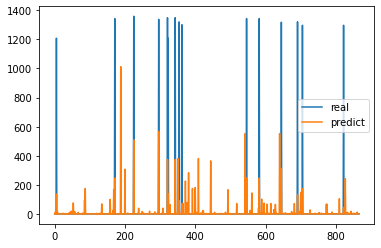

Epoch: 10; Test MAE loss on source data is: 40.397
Epoch: 10; Test MSE loss on source data is: 33327.915


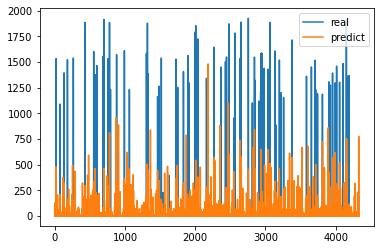

Epoch: 10; MSE loss: 2347464.072
28.08191714196916
22825.74849790314
Epoch: 11; MSE loss: 2322721.384
31.739197182455104
22615.337217141812
Epoch: 12; MSE loss: 2324391.322
28.789758659948646
22880.751059870905
Epoch: 13; MSE loss: 2118769.331
28.030291598872417
22685.03197307571
Epoch: 14; MSE loss: 2179272.428
28.96455458098337
22639.99745917571
Epoch: 15; MSE loss: 2213752.839
28.433448944257997
22783.04792490689
Epoch: 16; MSE loss: 2109615.056
30.13101002451939
22386.90809185333
Epoch: 17; MSE loss: 2137232.162
28.051495870689173
22374.615073617468
Epoch: 18; MSE loss: 2329371.818
30.40470233670465
22214.541214415935
Epoch: 19; MSE loss: 2114972.286
26.25518964600106
22273.66017271545
Epoch: 20; Test MAE loss on target data is: 26.255
Epoch: 20; Test MSE loss on target data is: 22273.660


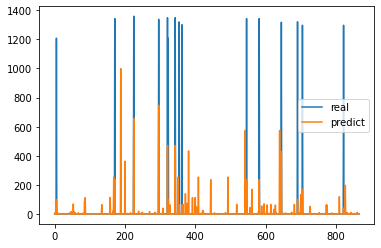

Epoch: 20; Test MAE loss on source data is: 37.992
Epoch: 20; Test MSE loss on source data is: 32322.091


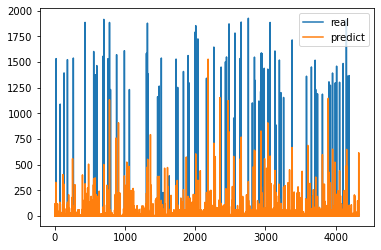

Epoch: 20; MSE loss: 2294657.651
30.158076402940708
21804.630228888625
Epoch: 21; MSE loss: 2253615.661
28.26920087023229
21859.9336374269
Epoch: 22; MSE loss: 2038383.149
29.044528907158487
21603.974659110583
Epoch: 23; MSE loss: 2239112.886
27.839552636540816
21520.114704743137
Epoch: 24; MSE loss: 2372574.471
30.949171359611046
21353.91767251603
Epoch: 25; MSE loss: 2065197.594
26.294953375040727
21635.43712000646
Epoch: 26; MSE loss: 2158220.113
29.71446522356214
22020.51526135463
Epoch: 27; MSE loss: 2110564.064
28.822740867364434
21403.338781588325
Epoch: 28; MSE loss: 2030904.831
29.3076973002245
21278.324875399107
Epoch: 29; MSE loss: 1984510.569
29.297791539170408
20812.623733196193
Epoch: 30; Test MAE loss on target data is: 29.298
Epoch: 30; Test MSE loss on target data is: 20812.624


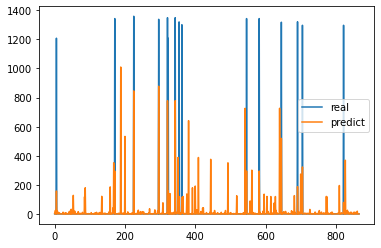

Epoch: 30; Test MAE loss on source data is: 44.713
Epoch: 30; Test MSE loss on source data is: 32245.133


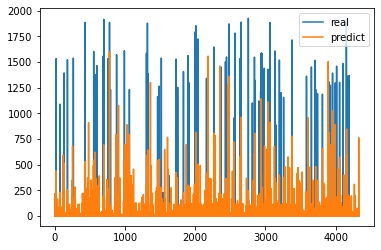

Epoch: 30; MSE loss: 2048884.673
26.06169181739892
21084.305180960666
Epoch: 31; MSE loss: 2030405.686
33.52014185113546
20946.91988952837
Epoch: 32; MSE loss: 1912819.359
25.871966831394683
21019.871857669103
Epoch: 33; MSE loss: 2283467.081
28.248988867093914
21577.637193680424
Epoch: 34; MSE loss: 2029516.582
33.729679727387605
21534.798741058104
Epoch: 35; MSE loss: 2234281.211
25.927915673389293
21050.264215200667
Epoch: 36; MSE loss: 2119838.858
31.166875571390612
21534.55658496043
Epoch: 37; MSE loss: 2036722.853
28.23691001195018
21652.327945368394
Epoch: 38; MSE loss: 2048773.611
30.95652019829761
21850.52924624753
Epoch: 39; MSE loss: 2078106.895
27.103997910745452
21553.915325694885
Epoch: 40; Test MAE loss on target data is: 27.104
Epoch: 40; Test MSE loss on target data is: 21553.915


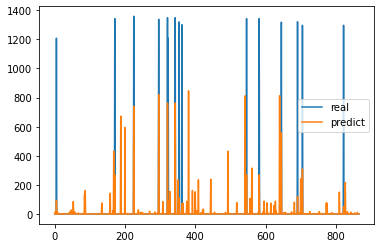

Epoch: 40; Test MAE loss on source data is: 38.374
Epoch: 40; Test MSE loss on source data is: 30480.717


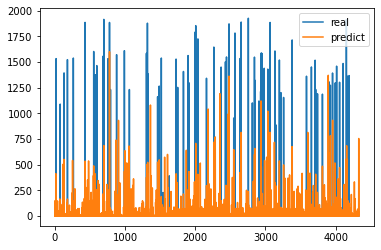

Epoch: 40; MSE loss: 2041862.250
30.691175606389635
22293.110599496962
Epoch: 41; MSE loss: 1913548.003
26.463957468797524
21456.78910086003
Epoch: 42; MSE loss: 2002618.985
31.397186971070823
22012.24797460625
Epoch: 43; MSE loss: 2209120.242
27.0582720388711
21782.40165696287
Epoch: 44; MSE loss: 2083825.014
29.300533394371143
21685.34707244179
Epoch: 45; MSE loss: 1957222.146
28.06113446985974
21592.60715580395
Epoch: 46; MSE loss: 1984577.772
27.166911189909488
21930.270047016355
Epoch: 47; MSE loss: 2031096.030
27.587816273516438
22461.46331125797
Epoch: 48; MSE loss: 2040624.302
30.91563544071343
21911.206992843054
Epoch: 49; MSE loss: 2146466.665
27.325547035740563
21465.6893661013
Epoch: 50; Test MAE loss on target data is: 27.326
Epoch: 50; Test MSE loss on target data is: 21465.689


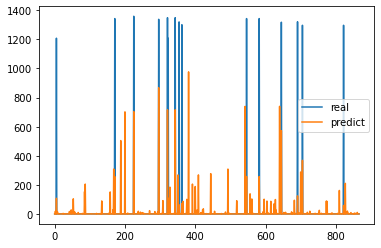

Epoch: 50; Test MAE loss on source data is: 39.096
Epoch: 50; Test MSE loss on source data is: 29858.824


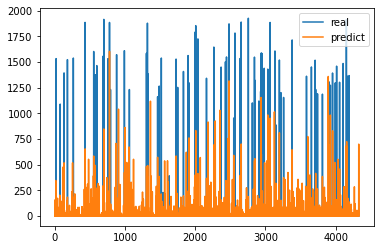

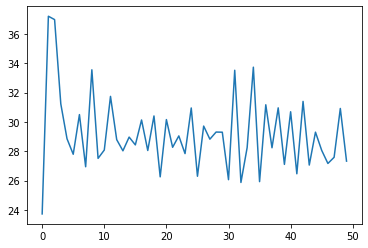

27.325547035740563
0.2643236108995354
0.847901541749071
house instance is: 5
Epoch: 0; MSE loss: 2820066.881
31.01281416244405
36883.105977104075
Epoch: 1; MSE loss: 2403186.422
54.97894495465248
31992.430962260107
Epoch: 2; MSE loss: 2371923.571
53.79110354468476
31270.406299720005
Epoch: 3; MSE loss: 2100183.846
49.176906601956595
32152.726072730162
Epoch: 4; MSE loss: 2127320.100
47.53409914297805
34406.94029127324
Epoch: 5; MSE loss: 1992351.962
43.351970737058814
34462.63521864982
Epoch: 6; MSE loss: 2347290.771
47.79550788543835
34654.8985943334
Epoch: 7; MSE loss: 2214764.491
54.28906648746136
36430.356630018396
Epoch: 8; MSE loss: 2159444.646
47.833047277297325
34984.35783129315
Epoch: 9; MSE loss: 2088108.982
47.29493814236737
36089.71464322075
Epoch: 10; Test MAE loss on target data is: 47.295
Epoch: 10; Test MSE loss on target data is: 36089.715


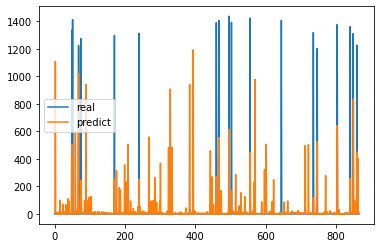

Epoch: 10; Test MAE loss on source data is: 40.459
Epoch: 10; Test MSE loss on source data is: 32411.442


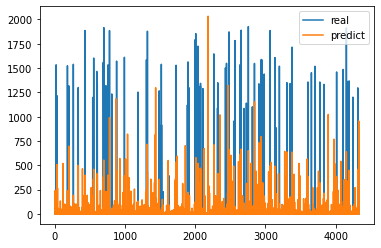

Epoch: 10; MSE loss: 2115931.269
48.919249423799954
36004.24374093893
Epoch: 11; MSE loss: 2140180.701
49.4129736026735
35862.38165606859
Epoch: 12; MSE loss: 2119162.369
54.411475189093814
37889.1912075617
Epoch: 13; MSE loss: 2199549.603
46.65800048038793
35055.30005437486
Epoch: 14; MSE loss: 2094632.693
57.48986124614685
39215.412030356514
Epoch: 15; MSE loss: 2146747.636
49.02983859103203
39103.02090673302
Epoch: 16; MSE loss: 1952089.224
46.954645656498265
35507.031694018544
Epoch: 17; MSE loss: 2087710.395
58.24267650950773
39408.85821765505
Epoch: 18; MSE loss: 2190381.596
43.65983778406676
37127.06049453713
Epoch: 19; MSE loss: 2122655.902
48.07118437889503
36591.12242759142
Epoch: 20; Test MAE loss on target data is: 48.071
Epoch: 20; Test MSE loss on target data is: 36591.122


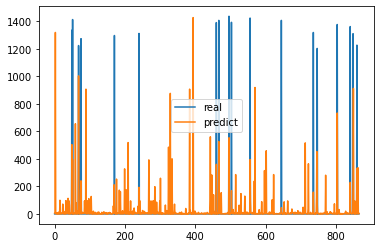

Epoch: 20; Test MAE loss on source data is: 39.869
Epoch: 20; Test MSE loss on source data is: 31335.179


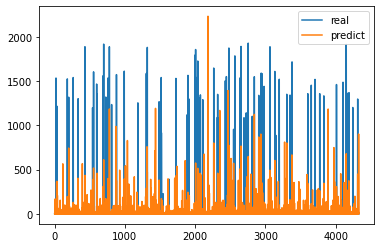

Epoch: 20; MSE loss: 2140706.685
51.43583934113057
34951.912391712896
Epoch: 21; MSE loss: 2107516.004
50.38919023076134
36735.87707939032
Epoch: 22; MSE loss: 2049533.445
45.25762860267396
33698.89960065927
Epoch: 23; MSE loss: 2123986.978
54.27533123863919
35919.264239346565
Epoch: 24; MSE loss: 2012035.617
49.11481899005708
35695.99494257744
Epoch: 25; MSE loss: 2035065.776
54.10355651355859
40294.04981862608
Epoch: 26; MSE loss: 2306775.423
45.99568479725792
35231.8803429296
Epoch: 27; MSE loss: 2106525.719
62.22442787448256
40198.63336618449
Epoch: 28; MSE loss: 1986714.176
48.260737206072534
40954.2991180318
Epoch: 29; MSE loss: 2076638.992
44.65798842367064
35538.9394106754
Epoch: 30; Test MAE loss on target data is: 44.658
Epoch: 30; Test MSE loss on target data is: 35538.939


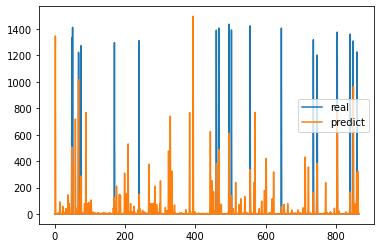

Epoch: 30; Test MAE loss on source data is: 36.543
Epoch: 30; Test MSE loss on source data is: 30544.690


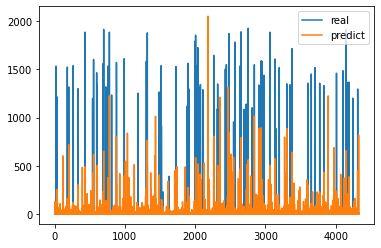

Epoch: 30; MSE loss: 2073780.910
58.781818604532894
38379.07246142154
Epoch: 31; MSE loss: 2055498.600
47.166838552875845
34363.21059023281
Epoch: 32; MSE loss: 2040134.346
52.200329963470175
36450.19116169604
Epoch: 33; MSE loss: 1888483.991
49.526178565760375
35791.58413647822
Epoch: 34; MSE loss: 2134474.083
48.99429577127617
36297.326761857825
Epoch: 35; MSE loss: 2188283.985
49.83784381401722
35506.40150336526
Epoch: 36; MSE loss: 1985272.328
54.22844616492787
39296.888958802396
Epoch: 37; MSE loss: 1960413.694
44.1879555226584
35067.61939482389
Epoch: 38; MSE loss: 2189277.394
53.00218711692019
36887.03288288803
Epoch: 39; MSE loss: 2088516.585
50.840729777264
34763.829150245314
Epoch: 40; Test MAE loss on target data is: 50.841
Epoch: 40; Test MSE loss on target data is: 34763.829


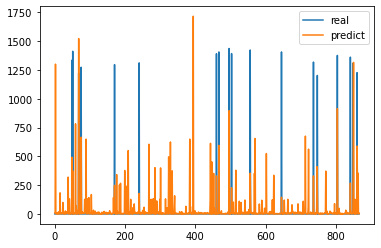

Epoch: 40; Test MAE loss on source data is: 43.758
Epoch: 40; Test MSE loss on source data is: 30070.936


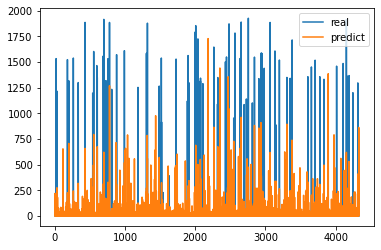

Epoch: 40; MSE loss: 1975124.665
47.88517421300522
34506.745046238866
Epoch: 41; MSE loss: 1843984.892
47.56029793159497
39817.634988728845
Epoch: 42; MSE loss: 2061680.486
49.32557809018157
37600.20859042834
Epoch: 43; MSE loss: 2020208.760
53.36407010201386
36505.99170108331
Epoch: 44; MSE loss: 1919073.690
46.251120978434635
35954.95007099373
Epoch: 45; MSE loss: 2038768.109
46.86221515603531
34529.14967522667
Epoch: 46; MSE loss: 1959040.152
50.38690088962386
37701.96358195903
Epoch: 47; MSE loss: 1996499.580
47.59389486319827
35509.86202836007
Epoch: 48; MSE loss: 2089774.464
49.51120778830612
35730.31075382932
Epoch: 49; MSE loss: 1890881.923
47.05696973268205
38533.268404565344
Epoch: 50; Test MAE loss on target data is: 47.057
Epoch: 50; Test MSE loss on target data is: 38533.268


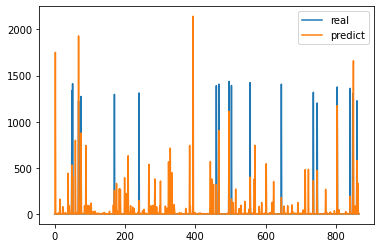

Epoch: 50; Test MAE loss on source data is: 38.517
Epoch: 50; Test MSE loss on source data is: 30119.841


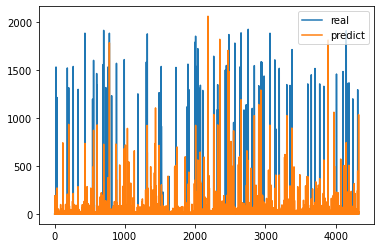

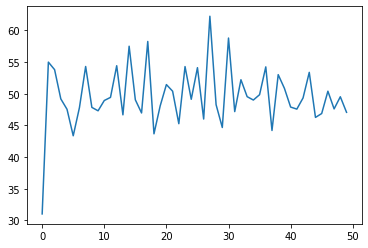

47.05696973268205
0.38795849134866084
0.9936630605957293


In [175]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,3,5]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/300
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 1484074.163
28.328534044646993
37824.24288690767
Epoch: 1; MSE loss: 1568453.166
60.64222631667488
36431.92293133467
Epoch: 2; MSE loss: 1478501.769
42.32820329790826
34385.00589732577
Epoch: 3; MSE loss: 1423179.976
45.92123257472497
36915.07172674108
Epoch: 4; MSE loss: 1318254.551
41.40919046938624
39725.17099299379
Epoch: 5; MSE loss: 1373448.553
37.05928930781039
40179.14514255974
Epoch: 6; MSE loss: 1317020.389
38.46848686794747
39521.01919716685
Epoch: 7; MSE loss: 1196203.158
41.00183784296373
40893.42632993992
Epoch: 8; MSE loss: 1254721.454
38.42282495778246
39768.73460591233
Epoch: 9; MSE loss: 1409633.330
37.91913974804874
38894.61414522816
Epoch: 10; Test MAE loss on target data is: 37.919
Epoch: 10; Test MSE loss on target data is: 38894.614


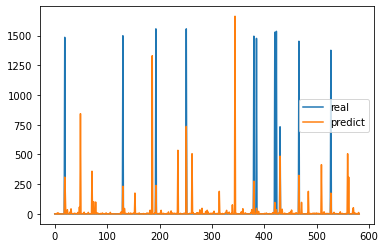

Epoch: 10; Test MAE loss on source data is: 41.164
Epoch: 10; Test MSE loss on source data is: 34097.190


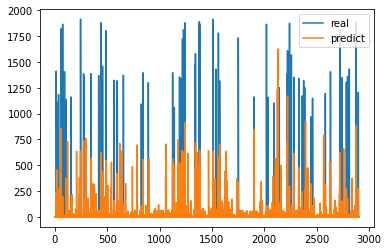

Epoch: 10; MSE loss: 1221377.192
39.1316288774065
40155.944040334936
Epoch: 11; MSE loss: 1280973.327
37.01107131606576
38763.99277459134
Epoch: 12; MSE loss: 1258853.216
40.96217574027472
39550.412714442384
Epoch: 13; MSE loss: 1293548.466
40.29104861240719
40593.95221964752
Epoch: 14; MSE loss: 1229159.001
38.20524666692639
40311.94475379099
Epoch: 15; MSE loss: 1267397.389
38.68785307593516
39510.65010019812
Epoch: 16; MSE loss: 1309767.809
43.46623686188672
40313.30382546714
Epoch: 17; MSE loss: 1368057.555
38.42975571585813
38758.941984222
Epoch: 18; MSE loss: 1283721.610
45.262933633101404
41759.06679996212
Epoch: 19; MSE loss: 1332105.026
42.45043250524736
42207.69704463301
Epoch: 20; Test MAE loss on target data is: 42.450
Epoch: 20; Test MSE loss on target data is: 42207.697


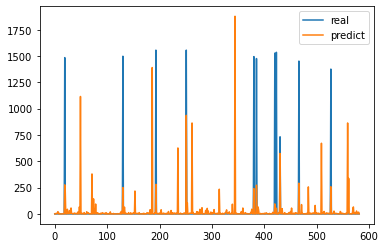

Epoch: 20; Test MAE loss on source data is: 44.237
Epoch: 20; Test MSE loss on source data is: 31717.532


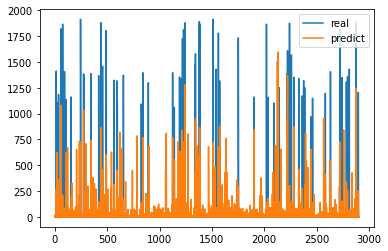

Epoch: 20; MSE loss: 1347306.219
41.2758852323162
41239.15374423211
Epoch: 21; MSE loss: 1265441.018
41.78383277494883
40408.79684271186
Epoch: 22; MSE loss: 1178181.370
37.73571835668226
38980.861294333554
Epoch: 23; MSE loss: 1179407.568
41.882272275155124
40314.39221172362
Epoch: 24; MSE loss: 1250549.715
41.30521164121365
40384.00650746054
Epoch: 25; MSE loss: 1188664.413
37.620738852295474
39079.46742025184
Epoch: 26; MSE loss: 1294944.722
39.42188950801505
41491.952378228285
Epoch: 27; MSE loss: 1306338.434
40.285141345503966
41042.116021250535
Epoch: 28; MSE loss: 1306337.314
37.22239642845758
37806.94217067139
Epoch: 29; MSE loss: 1150384.411
39.78536367053134
38989.662360529146
Epoch: 30; Test MAE loss on target data is: 39.785
Epoch: 30; Test MSE loss on target data is: 38989.662


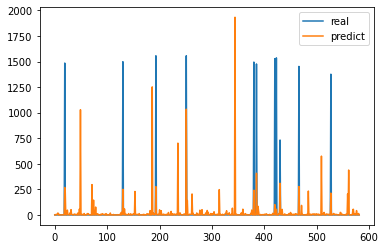

Epoch: 30; Test MAE loss on source data is: 42.837
Epoch: 30; Test MSE loss on source data is: 30780.443


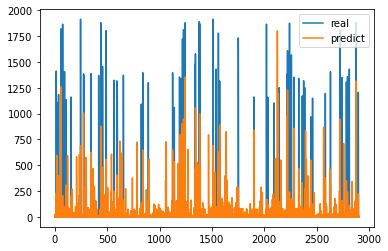

Epoch: 30; MSE loss: 1232359.715
39.05963746783455
37440.63247638997
Epoch: 31; MSE loss: 1204215.744
42.99651287373994
39442.824395236814
Epoch: 32; MSE loss: 1351174.487
39.1025474005318
39490.782166381156
Epoch: 33; MSE loss: 1145874.460
38.365498392029004
39431.35700542607
Epoch: 34; MSE loss: 1188973.901
37.875283383917946
38903.645705267394
Epoch: 35; MSE loss: 1129322.840
38.65790903473215
37822.74827167424
Epoch: 36; MSE loss: 1177929.981
39.66905472429527
37131.80123624317
Epoch: 37; MSE loss: 1326672.605
43.11032994142077
39310.19093403581
Epoch: 38; MSE loss: 1305156.709
35.71740907908152
35880.049428136685
Epoch: 39; MSE loss: 1157945.177
40.996752633850804
38604.38854156001
Epoch: 40; Test MAE loss on target data is: 40.997
Epoch: 40; Test MSE loss on target data is: 38604.389


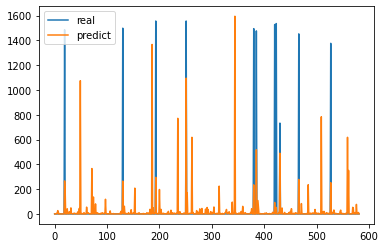

Epoch: 40; Test MAE loss on source data is: 40.766
Epoch: 40; Test MSE loss on source data is: 29019.626


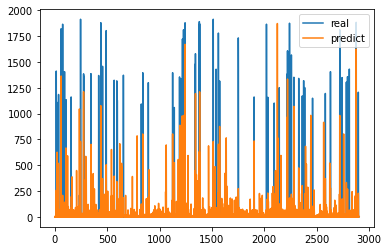

Epoch: 40; MSE loss: 1175023.269
35.98900882349929
35964.1625198658
Epoch: 41; MSE loss: 1151353.257
39.41568895990087
38279.519633943564
Epoch: 42; MSE loss: 1211458.896
45.16682366176774
41056.47012923017
Epoch: 43; MSE loss: 1130793.026
38.489310378829636
39530.95555302898
Epoch: 44; MSE loss: 1131450.807
39.69096669057845
38442.53073819239
Epoch: 45; MSE loss: 1137706.532
35.01778776809266
36907.179784162574
Epoch: 46; MSE loss: 1268724.323
40.635846921718034
39004.94849558434
Epoch: 47; MSE loss: 1130848.792
37.65949238896933
38896.920492520025
Epoch: 48; MSE loss: 1069401.782
35.500158674784544
37892.95873970353
Epoch: 49; MSE loss: 1250686.466
41.33142263473002
39676.8040204362
Epoch: 50; Test MAE loss on target data is: 41.331
Epoch: 50; Test MSE loss on target data is: 39676.804


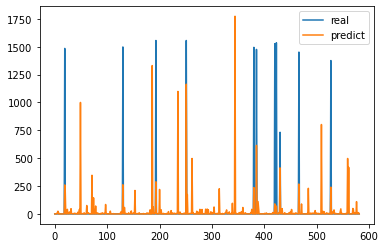

Epoch: 50; Test MAE loss on source data is: 40.398
Epoch: 50; Test MSE loss on source data is: 28275.110


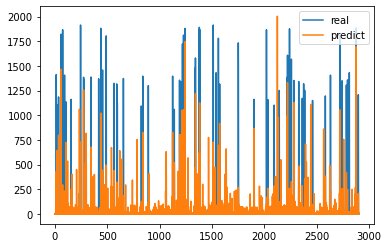

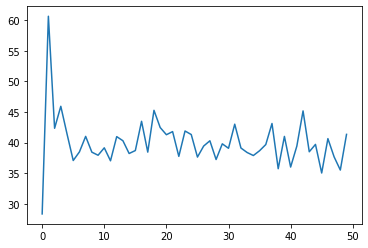

41.33142263473002
0.03131355219022882
1.003461521053846
house instance is: 2
Epoch: 0; MSE loss: 1806505.642
25.334495856116217
35385.65221840508
Epoch: 1; MSE loss: 1574856.972
59.437445853584
29591.472673022217
Epoch: 2; MSE loss: 1808567.250
32.91041340162382
31970.61865124129
Epoch: 3; MSE loss: 1658498.197
45.99953239767002
28900.14483873728
Epoch: 4; MSE loss: 1433213.229
38.25610890687536
28927.873166596586
Epoch: 5; MSE loss: 1435788.818
27.74844294579066
29899.5263178697
Epoch: 6; MSE loss: 1497506.538
31.5884043838688
27104.690250455675
Epoch: 7; MSE loss: 1408543.913
30.06381608029072
26621.3350329572
Epoch: 8; MSE loss: 1532067.150
33.6190017630535
26244.307875089333
Epoch: 9; MSE loss: 1430270.020
36.13380892600391
26765.96989201753
Epoch: 10; Test MAE loss on target data is: 36.134
Epoch: 10; Test MSE loss on target data is: 26765.970


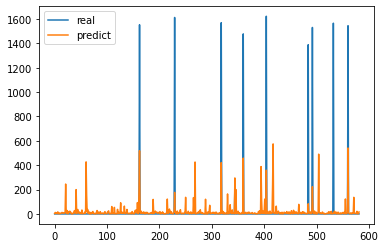

Epoch: 10; Test MAE loss on source data is: 49.021
Epoch: 10; Test MSE loss on source data is: 39163.786


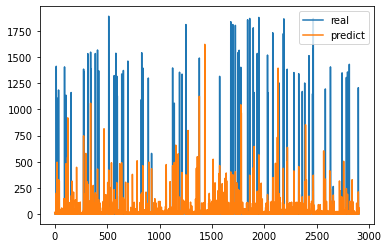

Epoch: 10; MSE loss: 1444477.936
31.50210189187573
28269.584271869033
Epoch: 11; MSE loss: 1631763.457
33.967781993051624
27478.194526866635
Epoch: 12; MSE loss: 1545279.486
37.942443571767136
25973.3538866982
Epoch: 13; MSE loss: 1385250.726
33.50573095782977
26007.16125396236
Epoch: 14; MSE loss: 1480342.969
31.86577762804183
25812.760772177968
Epoch: 15; MSE loss: 1465013.107
30.174792507605762
26709.86421265947
Epoch: 16; MSE loss: 1498478.918
33.826455754797614
26568.84369191451
Epoch: 17; MSE loss: 1534818.894
33.14773930019709
26959.461998839863
Epoch: 18; MSE loss: 1457648.525
32.74427537540057
27524.800884975262
Epoch: 19; MSE loss: 1389852.679
37.09752537640407
26803.83787007251
Epoch: 20; Test MAE loss on target data is: 37.098
Epoch: 20; Test MSE loss on target data is: 26803.838


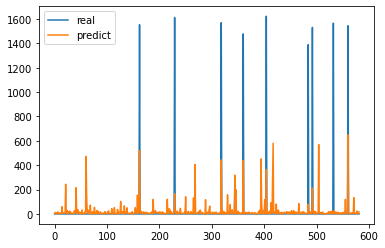

Epoch: 20; Test MAE loss on source data is: 49.570
Epoch: 20; Test MSE loss on source data is: 38224.220


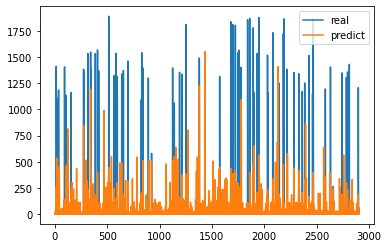

Epoch: 20; MSE loss: 1429930.656
33.8572037036105
27540.294299208705
Epoch: 21; MSE loss: 1488642.822
32.96481857226067
27464.158843329034
Epoch: 22; MSE loss: 1326995.788
33.2979771872003
26678.43490432332
Epoch: 23; MSE loss: 1602007.470
31.98854755109682
26460.693619143905
Epoch: 24; MSE loss: 1457528.135
29.783390904427907
27253.641899801754
Epoch: 25; MSE loss: 1440153.354
32.68199355570004
27526.52451110063
Epoch: 26; MSE loss: 1393803.110
33.831823040836866
27872.843458771476
Epoch: 27; MSE loss: 1431268.589
33.186466683227174
27800.164432826732
Epoch: 28; MSE loss: 1510989.584
39.045384171556464
27474.934071440028
Epoch: 29; MSE loss: 1528460.039
38.72391007263918
28177.109618593073
Epoch: 30; Test MAE loss on target data is: 38.724
Epoch: 30; Test MSE loss on target data is: 28177.110


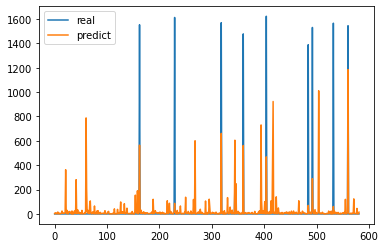

Epoch: 30; Test MAE loss on source data is: 49.222
Epoch: 30; Test MSE loss on source data is: 36515.013


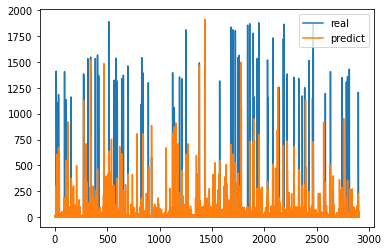

Epoch: 30; MSE loss: 1687818.357
31.387209030860376
29054.156427816062
Epoch: 31; MSE loss: 1504913.048
39.15377832648322
28707.846829459886
Epoch: 32; MSE loss: 1356927.494
32.88557265312939
29269.97831768406
Epoch: 33; MSE loss: 1402170.918
33.01810370324199
29507.44037682472
Epoch: 34; MSE loss: 1325589.350
40.080725234155494
29449.004711359714
Epoch: 35; MSE loss: 1363830.055
33.494889642851255
29717.483180416653
Epoch: 36; MSE loss: 1445717.373
32.689009474468804
29762.26703286011
Epoch: 37; MSE loss: 1372634.680
35.214826603628104
29248.341507448305
Epoch: 38; MSE loss: 1275957.602
33.19837422843037
29292.323595202026
Epoch: 39; MSE loss: 1417556.383
33.80485269143102
29969.67872572374
Epoch: 40; Test MAE loss on target data is: 33.805
Epoch: 40; Test MSE loss on target data is: 29969.679


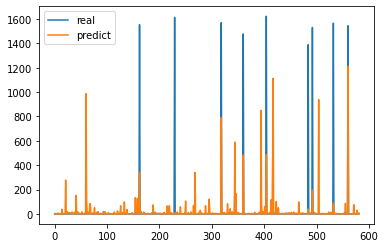

Epoch: 40; Test MAE loss on source data is: 43.277
Epoch: 40; Test MSE loss on source data is: 35180.808


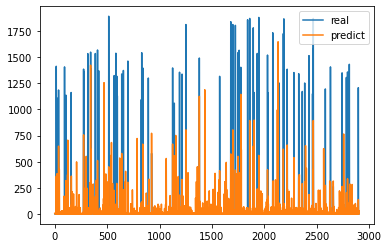

Epoch: 40; MSE loss: 1392519.453
33.268587504171116
30849.984754781843
Epoch: 41; MSE loss: 1353833.948
33.138997113786616
30702.307374963806
Epoch: 42; MSE loss: 1316932.729
40.6065086419102
30676.243365091177
Epoch: 43; MSE loss: 1308952.016
35.299603983171004
32513.966532747487
Epoch: 44; MSE loss: 1458018.118
32.90318066657511
33226.42020883238
Epoch: 45; MSE loss: 1354673.417
38.77985128729614
31797.211243710626
Epoch: 46; MSE loss: 1326440.854
35.37701094501309
30781.07493965272
Epoch: 47; MSE loss: 1321534.271
32.66374843006896
31382.3348374705
Epoch: 48; MSE loss: 1403979.150
36.25926038904493
32517.25276480407
Epoch: 49; MSE loss: 1292330.363
38.86660299173643
32451.66412898011
Epoch: 50; Test MAE loss on target data is: 38.867
Epoch: 50; Test MSE loss on target data is: 32451.664


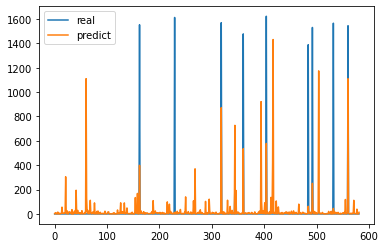

Epoch: 50; Test MAE loss on source data is: 46.491
Epoch: 50; Test MSE loss on source data is: 33516.427


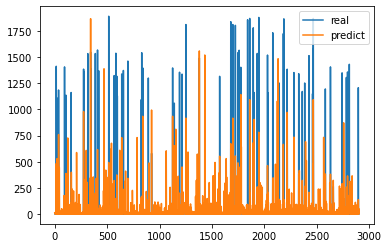

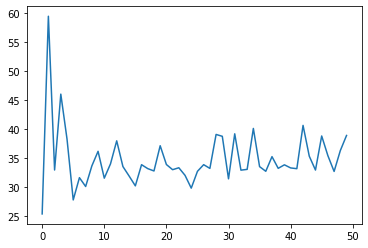

38.86660299173643
0.1837485421544629
0.9381163850389685
house instance is: 4
Epoch: 0; MSE loss: 1956784.772
25.634050612109057
24152.894689155703
Epoch: 1; MSE loss: 1917611.021
130.1958743419844
42442.90588117032
Epoch: 2; MSE loss: 1627718.386
61.66377482627266
23571.46425318401
Epoch: 3; MSE loss: 1721992.191
51.25600807281704
22975.09874959311
Epoch: 4; MSE loss: 1761739.759
108.77839443282163
35552.64788059213
Epoch: 5; MSE loss: 1617076.540
93.88889500283703
31532.50188746588
Epoch: 6; MSE loss: 1632365.668
58.531308426480116
24523.421991013958
Epoch: 7; MSE loss: 1540959.308
67.94928530544759
27629.856095077073
Epoch: 8; MSE loss: 1597236.012
65.8640442554074
29382.570090390076
Epoch: 9; MSE loss: 1450587.625
57.42504637611588
28795.46252129256
Epoch: 10; Test MAE loss on target data is: 57.425
Epoch: 10; Test MSE loss on target data is: 28795.463


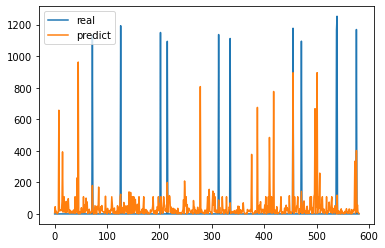

Epoch: 10; Test MAE loss on source data is: 45.085
Epoch: 10; Test MSE loss on source data is: 39317.843


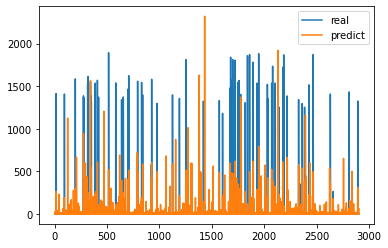

Epoch: 10; MSE loss: 1449059.932
53.37907181877348
28454.01676570695
Epoch: 11; MSE loss: 1593996.423
59.25425383663669
30485.52188085072
Epoch: 12; MSE loss: 1584223.762
50.15933552384696
28899.802374877945
Epoch: 13; MSE loss: 1477838.164
38.95737252771355
26430.76618194484
Epoch: 14; MSE loss: 1561042.729
44.66367673949371
26829.614888921642
Epoch: 15; MSE loss: 1547567.751
67.12797201305781
32127.34624501045
Epoch: 16; MSE loss: 1560675.211
64.16791381219664
31189.328803476943
Epoch: 17; MSE loss: 1530775.057
47.723997097327995
26963.73477904368
Epoch: 18; MSE loss: 1421346.075
49.45718757075632
27052.74456105739
Epoch: 19; MSE loss: 1341175.312
56.121529502941364
27931.18188948165
Epoch: 20; Test MAE loss on target data is: 56.122
Epoch: 20; Test MSE loss on target data is: 27931.182


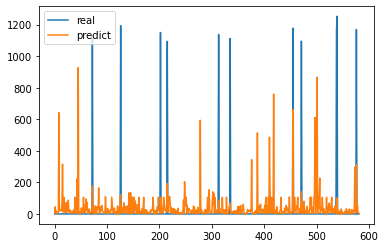

Epoch: 20; Test MAE loss on source data is: 44.233
Epoch: 20; Test MSE loss on source data is: 38632.437


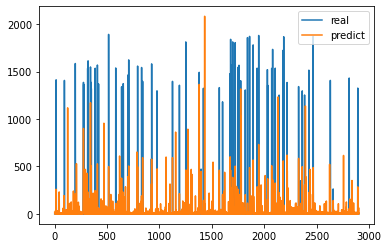

Epoch: 20; MSE loss: 1331475.701
56.064958578225266
27743.180430777946
Epoch: 21; MSE loss: 1454750.615
64.71043449041156
30575.73431915252
Epoch: 22; MSE loss: 1460974.698
59.49612746698161
29582.84103777165
Epoch: 23; MSE loss: 1543192.181
60.23745085457756
29761.808510126782
Epoch: 24; MSE loss: 1347303.861
63.66555836192521
30957.67102284229
Epoch: 25; MSE loss: 1436749.121
52.47548559461032
29493.231091761685
Epoch: 26; MSE loss: 1315024.581
66.0538003029897
35584.72715125538
Epoch: 27; MSE loss: 1416474.730
55.4245004557854
30777.38385060461
Epoch: 28; MSE loss: 1517055.301
44.68923117905292
26118.84294422422
Epoch: 29; MSE loss: 1308844.834
59.51473568671757
27681.77915781266
Epoch: 30; Test MAE loss on target data is: 59.515
Epoch: 30; Test MSE loss on target data is: 27681.779


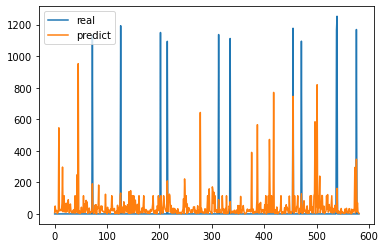

Epoch: 30; Test MAE loss on source data is: 45.426
Epoch: 30; Test MSE loss on source data is: 37841.280


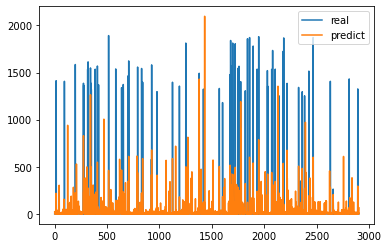

Epoch: 30; MSE loss: 1539761.201
87.76108545945682
37249.434574775274
Epoch: 31; MSE loss: 1483808.526
62.52202267611969
30155.450070944382
Epoch: 32; MSE loss: 1323304.640
46.78616579995519
26995.729124942787
Epoch: 33; MSE loss: 1521251.696
55.81599975438769
29355.673686842227
Epoch: 34; MSE loss: 1446811.287
68.05554777936837
32172.927452621458
Epoch: 35; MSE loss: 1519511.813
66.00167752582183
30042.433573810184
Epoch: 36; MSE loss: 1369707.072
66.80777172329499
29674.113974238328
Epoch: 37; MSE loss: 1334553.923
69.01953387792987
31101.324181877782
Epoch: 38; MSE loss: 1516060.023
69.99438449689202
33150.75608264237
Epoch: 39; MSE loss: 1455837.490
61.2344468018853
30264.626536789237
Epoch: 40; Test MAE loss on target data is: 61.234
Epoch: 40; Test MSE loss on target data is: 30264.627


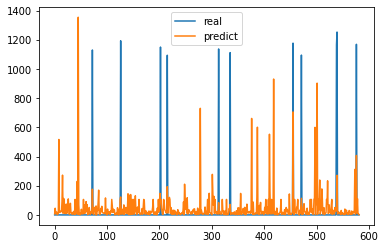

Epoch: 40; Test MAE loss on source data is: 44.871
Epoch: 40; Test MSE loss on source data is: 35454.122


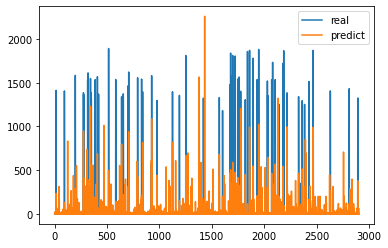

Epoch: 40; MSE loss: 1385672.801
63.58329832052038
31071.753809392976
Epoch: 41; MSE loss: 1375255.198
74.52702328306702
35293.33224495471
Epoch: 42; MSE loss: 1265916.979
58.47540847050775
31422.374826764913
Epoch: 43; MSE loss: 1132123.937
58.95207178077414
35111.69063468839
Epoch: 44; MSE loss: 1208907.182
56.685659570696274
35091.55487370221
Epoch: 45; MSE loss: 1461498.977
55.38409275113512
31461.576623209527
Epoch: 46; MSE loss: 1313352.613
74.20482275739978
34944.96928426593
Epoch: 47; MSE loss: 1261440.201
75.64980593907464
35336.13632579518
Epoch: 48; MSE loss: 1242507.671
56.38345707794235
30959.57160042138
Epoch: 49; MSE loss: 1291563.861
57.17209260474212
31817.808271326932
Epoch: 50; Test MAE loss on target data is: 57.172
Epoch: 50; Test MSE loss on target data is: 31817.808


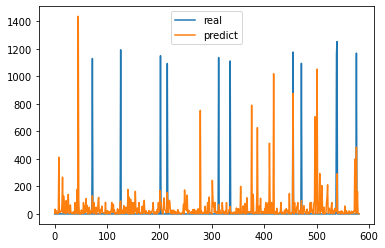

Epoch: 50; Test MAE loss on source data is: 40.890
Epoch: 50; Test MSE loss on source data is: 33685.707


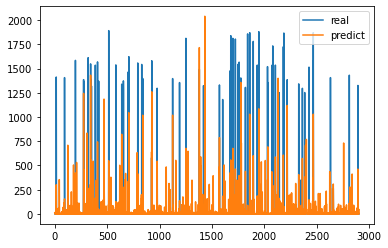

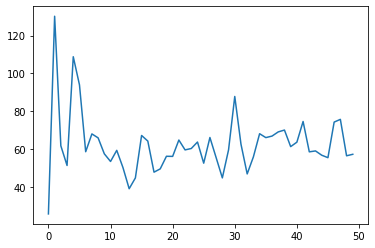

57.17209260474212
0.9973042067686968
1.1250845895921542


In [62]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,2,4]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/400
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 2437077.984
29.06011953485019
40147.912156634666
Epoch: 1; MSE loss: 2221408.614
47.745482181870265
33970.28973812673
Epoch: 2; MSE loss: 2106556.483
43.92785381004021
32514.0752103198
Epoch: 3; MSE loss: 1896107.937
36.91622469807098
30812.858271560137
Epoch: 4; MSE loss: 1928954.512
35.14638588544854
29525.651861588958
Epoch: 5; MSE loss: 2027862.383
30.934572229743534
30591.895558531833
Epoch: 6; MSE loss: 1996436.770
33.51633138845072
30078.064476353404
Epoch: 7; MSE loss: 2069771.523
32.82567970483911
30081.66551792235
Epoch: 8; MSE loss: 1877239.863
32.28752153833647
29959.535051695322
Epoch: 9; MSE loss: 1838968.189
32.871122706634225
29917.462337347857
Epoch: 10; Test MAE loss on target data is: 32.871
Epoch: 10; Test MSE loss on target data is: 29917.462


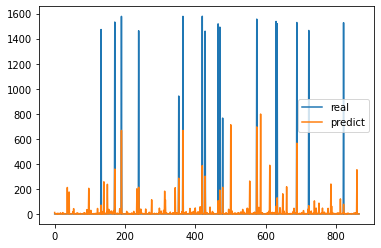

Epoch: 10; Test MAE loss on source data is: 38.921
Epoch: 10; Test MSE loss on source data is: 28188.074


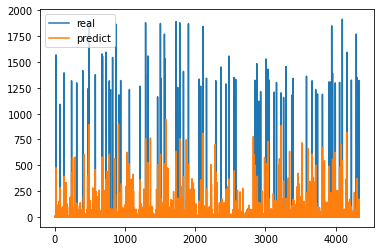

Epoch: 10; MSE loss: 1940970.162
35.07535208633649
29088.641398620337
Epoch: 11; MSE loss: 1912881.084
31.12753206622092
30390.62431504096
Epoch: 12; MSE loss: 1996249.800
30.949418437641345
30374.93276885211
Epoch: 13; MSE loss: 2038422.804
37.44252196091819
28525.883055598228
Epoch: 14; MSE loss: 2033001.769
30.293112227442915
29480.562440125253
Epoch: 15; MSE loss: 1832955.936
32.819695849207925
28564.596597568987
Epoch: 16; MSE loss: 1974110.442
37.94384068218001
28249.375503758565
Epoch: 17; MSE loss: 1999265.881
33.218680391399644
29494.827341283963
Epoch: 18; MSE loss: 2070326.886
34.70850818727333
27674.24138032597
Epoch: 19; MSE loss: 1801242.624
29.85050283934096
29083.050289567538
Epoch: 20; Test MAE loss on target data is: 29.851
Epoch: 20; Test MSE loss on target data is: 29083.050


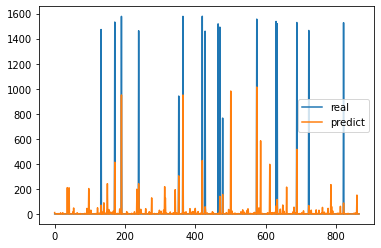

Epoch: 20; Test MAE loss on source data is: 36.061
Epoch: 20; Test MSE loss on source data is: 27300.072


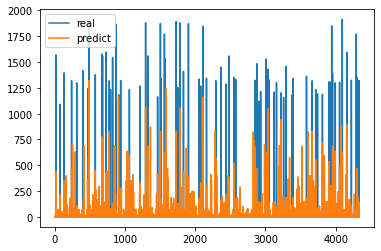

Epoch: 20; MSE loss: 1846939.006
34.2074997233272
28614.138568123893
Epoch: 21; MSE loss: 1813389.443
30.842966888881918
29269.167088803184
Epoch: 22; MSE loss: 1835021.000
33.15066663915723
27879.933485368896
Epoch: 23; MSE loss: 1740389.756
30.5071563888889
28358.49594534838
Epoch: 24; MSE loss: 1829323.947
34.80162701902282
28063.065622018712
Epoch: 25; MSE loss: 1753308.247
30.46401478175714
28276.172996866455
Epoch: 26; MSE loss: 1964580.618
29.964725785741567
28150.714123368944
Epoch: 27; MSE loss: 1897690.852
35.28125187759572
26883.341670839432
Epoch: 28; MSE loss: 2063315.123
28.791189545285356
29443.004754216065
Epoch: 29; MSE loss: 1848635.051
36.36673796794355
27878.460200450954
Epoch: 30; Test MAE loss on target data is: 36.367
Epoch: 30; Test MSE loss on target data is: 27878.460


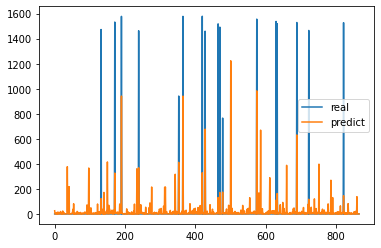

Epoch: 30; Test MAE loss on source data is: 44.786
Epoch: 30; Test MSE loss on source data is: 27060.511


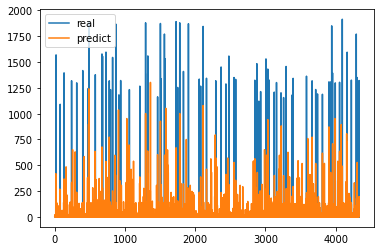

Epoch: 30; MSE loss: 1741433.358
30.059688468561472
28499.11447256757
Epoch: 31; MSE loss: 1876372.367
30.59093263357418
26099.70631648343
Epoch: 32; MSE loss: 1835838.755
29.052025504754006
26416.246223201426
Epoch: 33; MSE loss: 1849404.129
29.807821148931293
27011.701116922373
Epoch: 34; MSE loss: 1825963.283
32.80842400004931
27715.149128309058
Epoch: 35; MSE loss: 1702493.419
30.52315166955137
28782.474783019232
Epoch: 36; MSE loss: 1804990.600
29.389585322376035
27777.9195950746
Epoch: 37; MSE loss: 1707950.011
31.23929744559279
27447.84363116059
Epoch: 38; MSE loss: 1690609.161
29.01075176667796
28506.027628585416
Epoch: 39; MSE loss: 1795966.356
28.409361255828898
28243.530133440243
Epoch: 40; Test MAE loss on target data is: 28.409
Epoch: 40; Test MSE loss on target data is: 28243.530


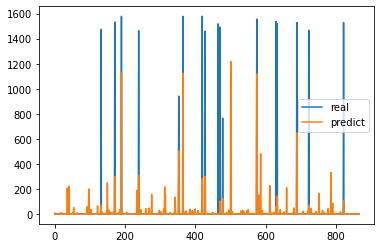

Epoch: 40; Test MAE loss on source data is: 33.197
Epoch: 40; Test MSE loss on source data is: 25554.931


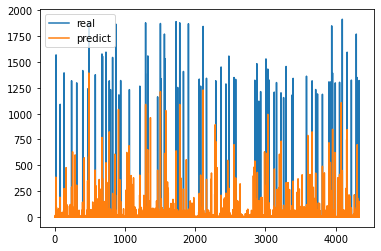

Epoch: 40; MSE loss: 1727527.863
29.734869561535163
26967.411663056933
Epoch: 41; MSE loss: 1776379.089
28.279066310346884
27435.488204890746
Epoch: 42; MSE loss: 1807211.889
30.593740742483888
28282.940696430953
Epoch: 43; MSE loss: 1855348.778
34.227102651212455
26348.811048977146
Epoch: 44; MSE loss: 1773013.164
26.74722154017413
27706.63555908165
Epoch: 45; MSE loss: 1643802.631
30.92259920895048
26926.767505836207
Epoch: 46; MSE loss: 1782647.758
32.684978635287756
26433.15504556963
Epoch: 47; MSE loss: 1619878.651
32.904583727371595
26785.85590758379
Epoch: 48; MSE loss: 1777844.459
29.045684323827665
28706.423877758418
Epoch: 49; MSE loss: 1746134.128
28.331840983174114
27636.12683570963
Epoch: 50; Test MAE loss on target data is: 28.332
Epoch: 50; Test MSE loss on target data is: 27636.127


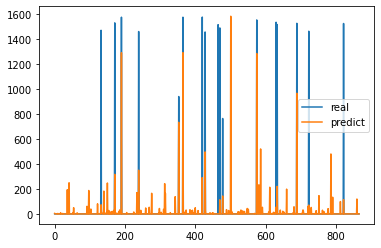

Epoch: 50; Test MAE loss on source data is: 33.526
Epoch: 50; Test MSE loss on source data is: 24616.767


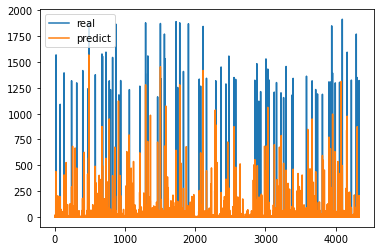

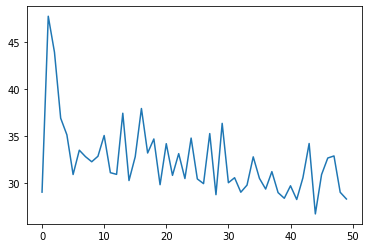

28.331840983174114
0.35983908130226394
0.8138185348570507
house instance is: 2
Epoch: 0; MSE loss: 2839850.835
25.439516917406017
33925.2496437485
Epoch: 1; MSE loss: 2406917.945
49.311390042167496
29787.741494749363
Epoch: 2; MSE loss: 2183929.049
41.151788332848675
29439.1093058217
Epoch: 3; MSE loss: 2144094.696
35.48702982251104
29738.534210483842
Epoch: 4; MSE loss: 2211225.062
33.10976724577326
30625.807441662306
Epoch: 5; MSE loss: 1987708.774
35.877019484378096
30654.04012375429
Epoch: 6; MSE loss: 2378989.221
39.482831196058136
29369.686326223826
Epoch: 7; MSE loss: 2109207.628
31.621820267079336
29229.84827800333
Epoch: 8; MSE loss: 2122544.624
41.47227975959012
29050.467672380393
Epoch: 9; MSE loss: 2023026.996
32.93449454579283
30646.481331602357
Epoch: 10; Test MAE loss on target data is: 32.934
Epoch: 10; Test MSE loss on target data is: 30646.481


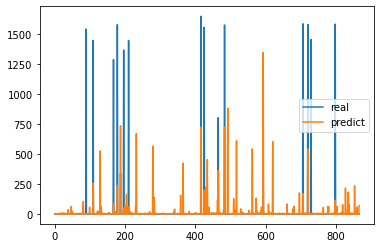

Epoch: 10; Test MAE loss on source data is: 36.300
Epoch: 10; Test MSE loss on source data is: 30809.128


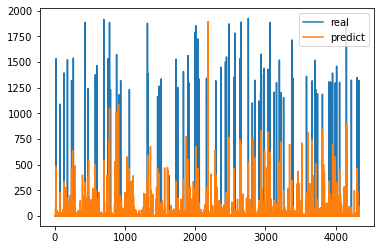

Epoch: 10; MSE loss: 2221198.276
34.240307346746896
29051.79803759362
Epoch: 11; MSE loss: 2221647.229
42.18243027084014
27917.17420679117
Epoch: 12; MSE loss: 2211043.691
33.54423916999856
27863.589680546724
Epoch: 13; MSE loss: 2022898.294
33.18337103586983
28589.849637310996
Epoch: 14; MSE loss: 2080076.967
34.84738857751538
28811.917502634147
Epoch: 15; MSE loss: 2077934.187
36.519327683763144
29009.762187473527
Epoch: 16; MSE loss: 1929604.208
35.406076875305814
29388.748797108026
Epoch: 17; MSE loss: 2064091.274
37.46368018162653
28160.27953254812
Epoch: 18; MSE loss: 2082415.163
35.69721122995242
29848.843047613995
Epoch: 19; MSE loss: 1957262.520
32.66782390649378
29772.529238864772
Epoch: 20; Test MAE loss on target data is: 32.668
Epoch: 20; Test MSE loss on target data is: 29772.529


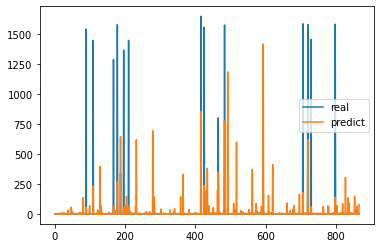

Epoch: 20; Test MAE loss on source data is: 35.747
Epoch: 20; Test MSE loss on source data is: 29705.217


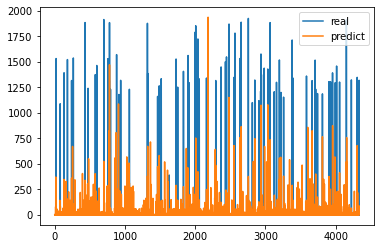

Epoch: 20; MSE loss: 2251274.422
36.213813115151936
27424.363027583604
Epoch: 21; MSE loss: 2241702.550
36.71641510479461
27022.0452261649
Epoch: 22; MSE loss: 1928350.838
34.865289255738205
29582.911752980606
Epoch: 23; MSE loss: 2153365.739
38.09371022060041
31246.233851813475
Epoch: 24; MSE loss: 2240628.191
38.81159948444181
28647.228664399394
Epoch: 25; MSE loss: 1858076.581
29.63283066843414
29094.362086474364
Epoch: 26; MSE loss: 2056265.931
37.53245698627527
31014.317128204315
Epoch: 27; MSE loss: 2130674.842
38.067747852832696
28306.52863724471
Epoch: 28; MSE loss: 1970764.355
35.80393808535295
28912.08759712097
Epoch: 29; MSE loss: 1947552.500
37.66993660479784
31074.292035518265
Epoch: 30; Test MAE loss on target data is: 37.670
Epoch: 30; Test MSE loss on target data is: 31074.292


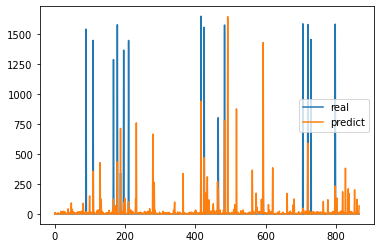

Epoch: 30; Test MAE loss on source data is: 40.235
Epoch: 30; Test MSE loss on source data is: 29190.408


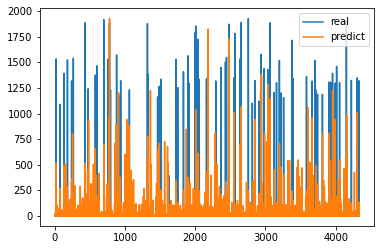

Epoch: 30; MSE loss: 1966444.172
33.106368537158666
29984.772070564777
Epoch: 31; MSE loss: 1944829.198
41.17085252465485
29218.23552821226
Epoch: 32; MSE loss: 1729341.580
31.42949858651579
32560.032850242027
Epoch: 33; MSE loss: 2149633.606
37.55443337450562
29635.424476693814
Epoch: 34; MSE loss: 1870884.104
38.90614102178413
30044.073809293262
Epoch: 35; MSE loss: 2011692.664
33.982618800023914
31128.801951188187
Epoch: 36; MSE loss: 1928959.155
38.17955510353083
30730.23035568037
Epoch: 37; MSE loss: 1874485.294
36.53490176679612
30044.933231846015
Epoch: 38; MSE loss: 1972150.537
38.10506878456803
29160.526578281446
Epoch: 39; MSE loss: 1950004.247
32.64205540679696
30324.046398901926
Epoch: 40; Test MAE loss on target data is: 32.642
Epoch: 40; Test MSE loss on target data is: 30324.046


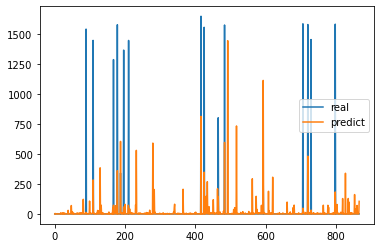

Epoch: 40; Test MAE loss on source data is: 34.644
Epoch: 40; Test MSE loss on source data is: 27781.218


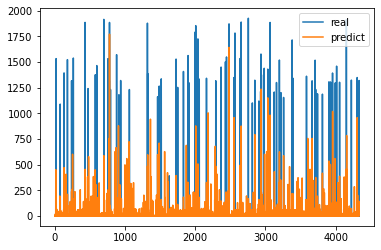

Epoch: 40; MSE loss: 1982485.253
41.93056884541197
32764.885216636045
Epoch: 41; MSE loss: 1943170.994
31.42316768077796
29388.100860917304
Epoch: 42; MSE loss: 1884652.990
41.33725336780976
30167.917827511494
Epoch: 43; MSE loss: 2100966.792
32.30861342659665
32038.973012241302
Epoch: 44; MSE loss: 1983091.062
36.19549286464334
29603.462501744893
Epoch: 45; MSE loss: 1951876.600
36.3157186485234
30049.28847584255
Epoch: 46; MSE loss: 1929912.143
30.427478428109364
31402.50303392573
Epoch: 47; MSE loss: 1970696.219
39.02233085593138
30086.919807967188
Epoch: 48; MSE loss: 1868847.880
35.74375777744883
29806.792222139815
Epoch: 49; MSE loss: 1987318.349
39.09159748757209
31500.093735729548
Epoch: 50; Test MAE loss on target data is: 39.092
Epoch: 50; Test MSE loss on target data is: 31500.094


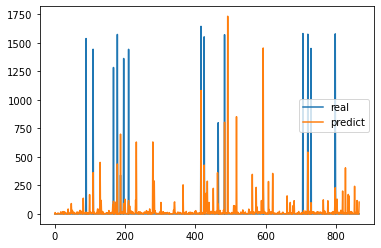

Epoch: 50; Test MAE loss on source data is: 40.519
Epoch: 50; Test MSE loss on source data is: 27631.651


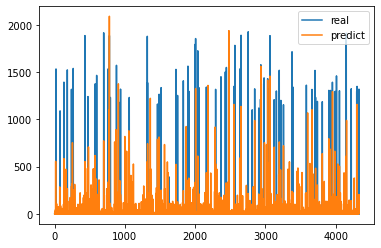

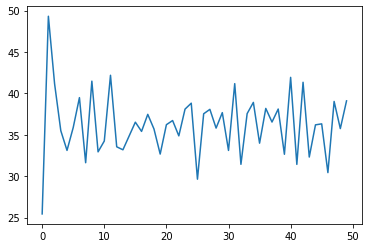

39.09159748757209
0.08901891764160365
0.9453367641619085
house instance is: 5
Epoch: 0; MSE loss: 2820066.844
31.012703813930422
36883.193268322175
Epoch: 1; MSE loss: 2403201.253
54.979631878512954
31992.42006261841
Epoch: 2; MSE loss: 2371931.783
53.78361738375909
31268.41051224098
Epoch: 3; MSE loss: 2100158.647
49.17998282204789
32151.58750635118
Epoch: 4; MSE loss: 2127353.514
47.53277918240947
34405.61556953398
Epoch: 5; MSE loss: 1992487.786
43.31684568835231
34463.995078979286
Epoch: 6; MSE loss: 2347884.846
47.73769856634901
34664.818719947005
Epoch: 7; MSE loss: 2214622.208
54.19275249234447
36449.17117054598
Epoch: 8; MSE loss: 2159407.459
47.974959169919444
34963.49151502084
Epoch: 9; MSE loss: 2088239.383
47.30001168616004
36055.631520880226
Epoch: 10; Test MAE loss on target data is: 47.300
Epoch: 10; Test MSE loss on target data is: 36055.632


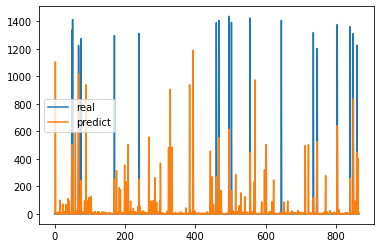

Epoch: 10; Test MAE loss on source data is: 40.475
Epoch: 10; Test MSE loss on source data is: 32406.680


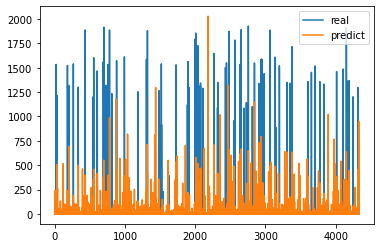

Epoch: 10; MSE loss: 2115042.145
48.8884417848133
36026.108211362494
Epoch: 11; MSE loss: 2139558.549
49.36317918701645
35905.56052559941
Epoch: 12; MSE loss: 2118715.986
54.461410219255825
37878.533153278084
Epoch: 13; MSE loss: 2198190.159
46.782147786977475
35040.4466875305
Epoch: 14; MSE loss: 2093801.970
57.33752726246587
39211.612063792854
Epoch: 15; MSE loss: 2146048.107
49.0003200285083
39105.84476816409
Epoch: 16; MSE loss: 1951138.477
47.000484082960895
35515.87983442908
Epoch: 17; MSE loss: 2087058.684
58.21722125546897
39471.41454362747
Epoch: 18; MSE loss: 2189620.535
43.59722455806231
37091.915248025645
Epoch: 19; MSE loss: 2122241.202
48.13019939224346
36562.41966586224
Epoch: 20; Test MAE loss on target data is: 48.130
Epoch: 20; Test MSE loss on target data is: 36562.420


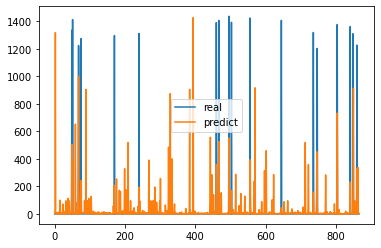

Epoch: 20; Test MAE loss on source data is: 39.957
Epoch: 20; Test MSE loss on source data is: 31334.878


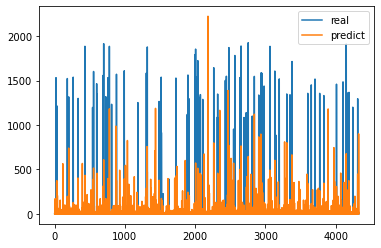

Epoch: 20; MSE loss: 2140514.438
51.39823009276542
34948.64324182653
Epoch: 21; MSE loss: 2107647.016
50.54121034610651
36832.11779913273
Epoch: 22; MSE loss: 2048221.358
45.3225445803228
33731.5760553892
Epoch: 23; MSE loss: 2122863.826
54.35139399735126
35931.80115298426
Epoch: 24; MSE loss: 2011794.622
49.17369934274561
35687.05754571995
Epoch: 25; MSE loss: 2033939.086
54.11598274869696
40343.74947965805
Epoch: 26; MSE loss: 2306113.398
46.10991801572867
35270.0884831903
Epoch: 27; MSE loss: 2105627.664
62.390650816156494
40281.82249210084
Epoch: 28; MSE loss: 1985508.818
48.37940790040812
40943.142218917244
Epoch: 29; MSE loss: 2074655.828
44.5457172438947
35495.81011104039
Epoch: 30; Test MAE loss on target data is: 44.546
Epoch: 30; Test MSE loss on target data is: 35495.810


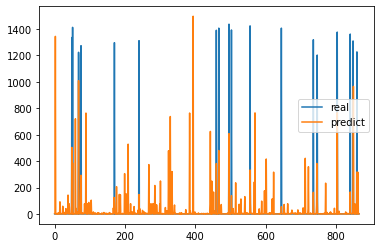

Epoch: 30; Test MAE loss on source data is: 36.429
Epoch: 30; Test MSE loss on source data is: 30532.111


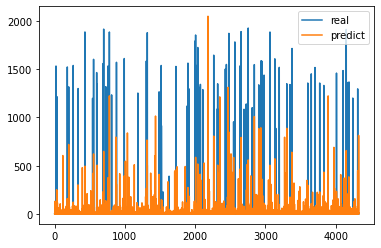

Epoch: 30; MSE loss: 2072797.206
58.81055184142533
38421.29754260162
Epoch: 31; MSE loss: 2053344.281
47.2012688360438
34309.6459073943
Epoch: 32; MSE loss: 2038185.367
52.28421061009065
36467.30897169351
Epoch: 33; MSE loss: 1885670.770
49.61079926140856
35827.396845385345
Epoch: 34; MSE loss: 2131113.523
49.01475286356366
36405.035111946134
Epoch: 35; MSE loss: 2184768.629
49.905866820143906
35507.51718522209
Epoch: 36; MSE loss: 1983474.597
54.305666489399876
39333.27382788709
Epoch: 37; MSE loss: 1957868.046
44.22732108681664
35159.88979696365
Epoch: 38; MSE loss: 2189025.735
53.15866664083161
36989.682452418165
Epoch: 39; MSE loss: 2086613.948
50.9410568681538
34880.83917326692
Epoch: 40; Test MAE loss on target data is: 50.941
Epoch: 40; Test MSE loss on target data is: 34880.839


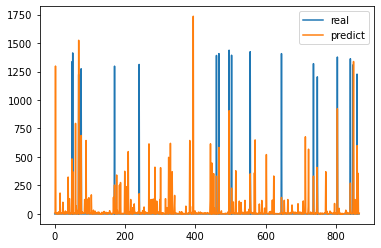

Epoch: 40; Test MAE loss on source data is: 43.807
Epoch: 40; Test MSE loss on source data is: 30085.761


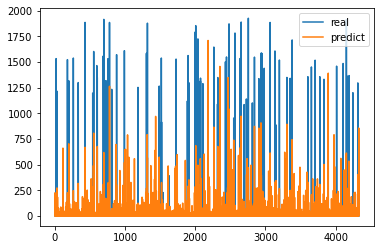

Epoch: 40; MSE loss: 1973325.120
48.00814254450877
34768.85501227994
Epoch: 41; MSE loss: 1841548.625
47.36837184727579
39937.283325360375
Epoch: 42; MSE loss: 2060221.382
50.124284936950865
37656.368986456844
Epoch: 43; MSE loss: 2021438.400
52.87432088257021
36668.37051283542
Epoch: 44; MSE loss: 1920154.250
46.35975051592206
36152.05911156719
Epoch: 45; MSE loss: 2039101.965
46.8571848790736
34511.91560390842
Epoch: 46; MSE loss: 1958227.637
50.49548030683326
37878.291554908836
Epoch: 47; MSE loss: 1996308.866
47.48424289252656
35733.801620838705
Epoch: 48; MSE loss: 2089196.521
49.85688329983456
35921.59493426131
Epoch: 49; MSE loss: 1890421.025
47.21502010189341
38763.44464823034
Epoch: 50; Test MAE loss on target data is: 47.215
Epoch: 50; Test MSE loss on target data is: 38763.445


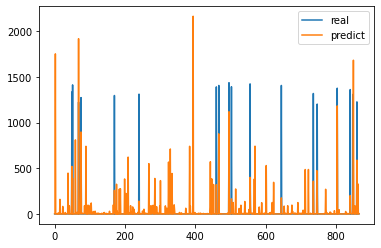

Epoch: 50; Test MAE loss on source data is: 38.718
Epoch: 50; Test MSE loss on source data is: 30167.685


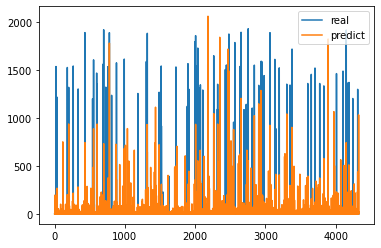

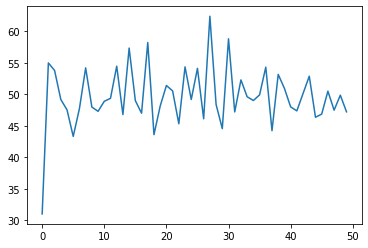

47.21502010189341
0.3933402711938058
0.9966264361239756


In [64]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,2,5]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 2437077.935
29.060080482825345
40147.95588984844
Epoch: 1; MSE loss: 2221405.111
47.74694429645626
33970.068553018806
Epoch: 2; MSE loss: 2106552.050
43.9302251553453
32513.84854604755
Epoch: 3; MSE loss: 1896135.874
36.9160943598827
30813.655550014766
Epoch: 4; MSE loss: 1928947.788
35.1553522123619
29525.62690217517
Epoch: 5; MSE loss: 2027916.241
30.92885846583841
30592.188270402534
Epoch: 6; MSE loss: 1996337.017
33.512512176883035
30072.281716812355
Epoch: 7; MSE loss: 2069815.730
32.81170051384206
30088.369120742143
Epoch: 8; MSE loss: 1877331.895
32.34096865912613
29943.884009292015
Epoch: 9; MSE loss: 1838898.332
32.86139830776771
29921.30047578272
Epoch: 10; Test MAE loss on target data is: 32.861
Epoch: 10; Test MSE loss on target data is: 29921.300


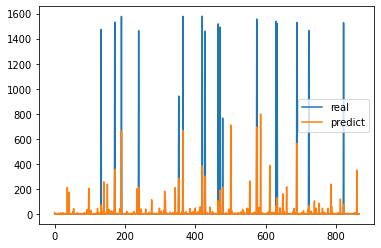

Epoch: 10; Test MAE loss on source data is: 38.903
Epoch: 10; Test MSE loss on source data is: 28186.904


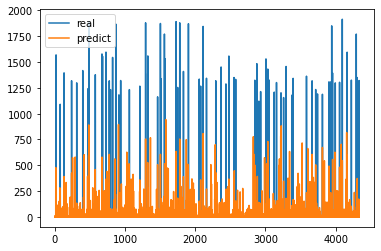

Epoch: 10; MSE loss: 1942989.910
35.09494152604984
29082.127354037475
Epoch: 11; MSE loss: 1915014.802
31.08120617713358
30399.72938085197
Epoch: 12; MSE loss: 1997826.259
31.001628887617795
30350.033867335787
Epoch: 13; MSE loss: 2041017.433
37.33564152313351
28546.65692555171
Epoch: 14; MSE loss: 2035679.518
30.3248148097097
29488.10289644146
Epoch: 15; MSE loss: 1835252.092
32.83726350682752
28570.70189784495
Epoch: 16; MSE loss: 1974925.198
37.92908955132535
28258.14839972861
Epoch: 17; MSE loss: 2001268.658
33.214004021889885
29507.82743378225
Epoch: 18; MSE loss: 2074160.019
34.38726277470658
27707.86549563207
Epoch: 19; MSE loss: 1802167.851
29.954685144633434
29095.058376710695
Epoch: 20; Test MAE loss on target data is: 29.955
Epoch: 20; Test MSE loss on target data is: 29095.058


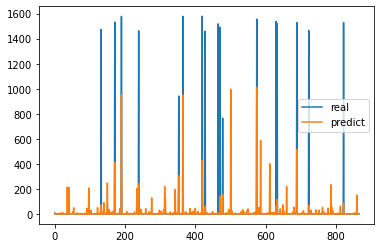

Epoch: 20; Test MAE loss on source data is: 36.196
Epoch: 20; Test MSE loss on source data is: 27314.924


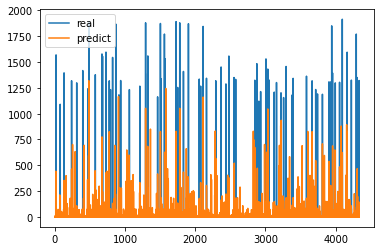

Epoch: 20; MSE loss: 1849287.956
34.02787010521212
28649.462056113516
Epoch: 21; MSE loss: 1817786.581
30.931807136246903
29229.92464562261
Epoch: 22; MSE loss: 1837255.527
32.94842429942051
27916.072603191886
Epoch: 23; MSE loss: 1742943.828
30.506656792732397
28385.040864963812
Epoch: 24; MSE loss: 1830300.053
34.49114467242288
28073.810156255033
Epoch: 25; MSE loss: 1755431.713
30.383841461766266
28351.523777259128
Epoch: 26; MSE loss: 1963754.019
30.371154722793086
28077.909295849717
Epoch: 27; MSE loss: 1899407.064
35.095384544434054
27004.427072668575
Epoch: 28; MSE loss: 2063977.852
28.761018921501908
29405.043041736524
Epoch: 29; MSE loss: 1852330.302
36.10344435208431
27952.86606671967
Epoch: 30; Test MAE loss on target data is: 36.103
Epoch: 30; Test MSE loss on target data is: 27952.866


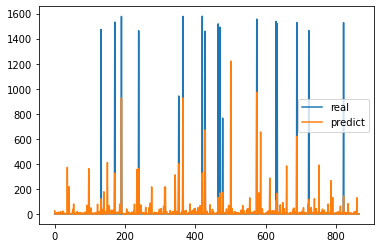

Epoch: 30; Test MAE loss on source data is: 44.271
Epoch: 30; Test MSE loss on source data is: 27052.068


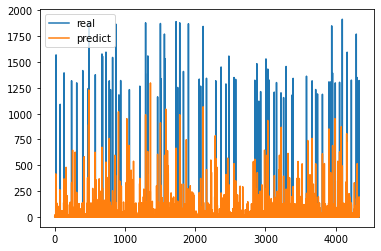

Epoch: 30; MSE loss: 1741277.090
30.469479155678393
28401.594532673866
Epoch: 31; MSE loss: 1874279.402
30.046220548588444
26221.09686585769
Epoch: 32; MSE loss: 1837698.951
29.308754672555224
26265.619340403595
Epoch: 33; MSE loss: 1849749.743
29.76461678347201
27056.99063327356
Epoch: 34; MSE loss: 1826109.425
32.46192914180483
27770.817999779792
Epoch: 35; MSE loss: 1702908.791
30.994288485094415
28675.211870326173
Epoch: 36; MSE loss: 1803559.300
29.079132873517693
27856.1035484152
Epoch: 37; MSE loss: 1709388.621
31.42772362362314
27558.988122644078
Epoch: 38; MSE loss: 1690542.604
29.275931455169168
28603.309597616008
Epoch: 39; MSE loss: 1797265.646
27.909943261154794
28351.636441643048
Epoch: 40; Test MAE loss on target data is: 27.910
Epoch: 40; Test MSE loss on target data is: 28351.636


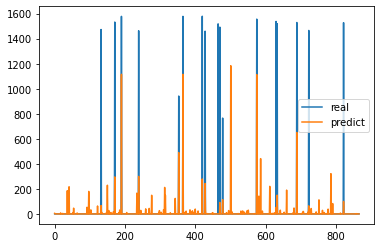

Epoch: 40; Test MAE loss on source data is: 32.334
Epoch: 40; Test MSE loss on source data is: 25539.240


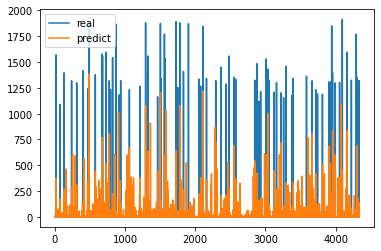

Epoch: 40; MSE loss: 1728551.763
29.69946430944929
26806.584643030816
Epoch: 41; MSE loss: 1777370.201
28.206604131485626
27323.6450013785
Epoch: 42; MSE loss: 1809505.005
30.73449546367901
28265.08561235239
Epoch: 43; MSE loss: 1855401.371
33.652976060223864
26427.43237200221
Epoch: 44; MSE loss: 1771732.501
26.796923651792873
27722.55641849777
Epoch: 45; MSE loss: 1645171.265
31.038097944929163
26883.242532381024
Epoch: 46; MSE loss: 1782860.954
32.157463200768454
26331.484692192415
Epoch: 47; MSE loss: 1623403.994
34.0217650318572
27007.29080097393
Epoch: 48; MSE loss: 1782151.343
28.887091597849384
28975.40890371358
Epoch: 49; MSE loss: 1749988.938
27.867946712272254
27602.26114249562
Epoch: 50; Test MAE loss on target data is: 27.868
Epoch: 50; Test MSE loss on target data is: 27602.261


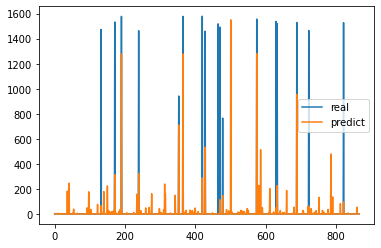

Epoch: 50; Test MAE loss on source data is: 32.751
Epoch: 50; Test MSE loss on source data is: 24586.895


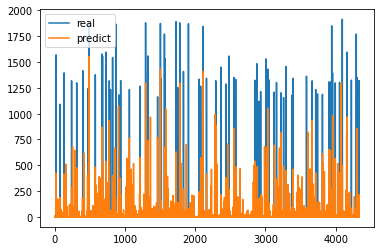

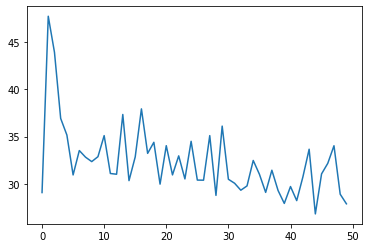

27.867946712272254
0.38517039153324495
0.8133197497443966
house instance is: 1
Epoch: 0; MSE loss: 2469306.158
33.47032809076685
59197.41269489775
Epoch: 1; MSE loss: 2186135.905
42.09995122688154
52387.79588463179
Epoch: 2; MSE loss: 2017930.091
42.25816193731163
49086.573904018915
Epoch: 3; MSE loss: 2005483.893
38.188275535165204
45778.33692515172
Epoch: 4; MSE loss: 2061103.704
33.38275082876296
47482.064476343825
Epoch: 5; MSE loss: 1967407.771
37.5064159341039
43803.39992113267
Epoch: 6; MSE loss: 2186401.865
36.20107122500646
45462.29627588879
Epoch: 7; MSE loss: 2167884.017
37.53523385206216
45224.27068350423
Epoch: 8; MSE loss: 1992265.121
35.65542681191528
45429.907265065194
Epoch: 9; MSE loss: 1966291.193
35.770773023666266
42464.51124050719
Epoch: 10; Test MAE loss on target data is: 35.771
Epoch: 10; Test MSE loss on target data is: 42464.511


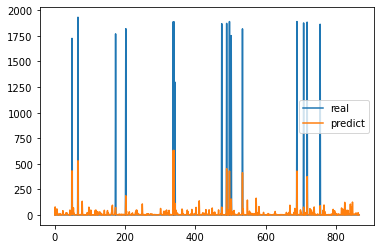

Epoch: 10; Test MAE loss on source data is: 41.003
Epoch: 10; Test MSE loss on source data is: 29602.086


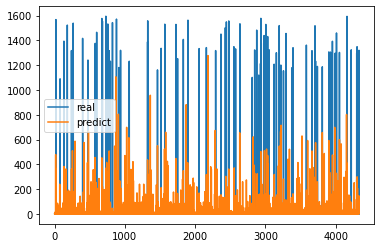

Epoch: 10; MSE loss: 2019509.579
33.854471163996784
45257.48817755696
Epoch: 11; MSE loss: 2120813.339
38.348396071335614
44887.41515611786
Epoch: 12; MSE loss: 1965890.103
34.61082385965794
47244.54752514704
Epoch: 13; MSE loss: 2112049.522
37.13302983603412
44773.06153678012
Epoch: 14; MSE loss: 1934856.089
34.72345207406294
44405.936981354294
Epoch: 15; MSE loss: 1976108.246
34.40635792161984
43506.0819489155
Epoch: 16; MSE loss: 1916691.865
35.406386581111676
41908.522200800144
Epoch: 17; MSE loss: 1928038.528
36.147480572326415
42465.64529417703
Epoch: 18; MSE loss: 1979413.026
33.742774730402886
41559.89742145365
Epoch: 19; MSE loss: 1895058.375
33.581241035710065
40923.28408608078
Epoch: 20; Test MAE loss on target data is: 33.581
Epoch: 20; Test MSE loss on target data is: 40923.284


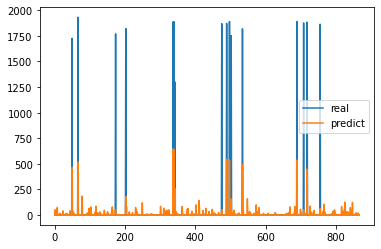

Epoch: 20; Test MAE loss on source data is: 37.840
Epoch: 20; Test MSE loss on source data is: 28958.696


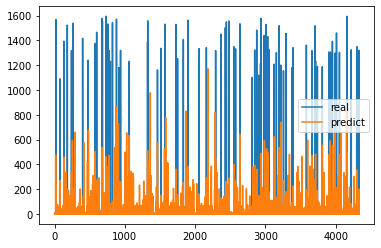

Epoch: 20; MSE loss: 2092272.076
34.29500315749859
42943.31600869471
Epoch: 21; MSE loss: 2083095.425
37.14494176772135
42589.21516054541
Epoch: 22; MSE loss: 1873226.390
35.691128742885056
42613.33669994899
Epoch: 23; MSE loss: 2051809.554
34.97140437979301
39279.565551972824
Epoch: 24; MSE loss: 2129921.727
35.35500359453435
38591.84561024549
Epoch: 25; MSE loss: 1796924.698
32.76031141367521
44121.68001939262
Epoch: 26; MSE loss: 2040132.514
40.97985032800068
37084.115147862874
Epoch: 27; MSE loss: 2087598.108
33.35832806806675
41161.1415947707
Epoch: 28; MSE loss: 1869730.581
34.51001753499362
40640.40115695039
Epoch: 29; MSE loss: 1988337.404
35.715753331779
42212.24314802861
Epoch: 30; Test MAE loss on target data is: 35.716
Epoch: 30; Test MSE loss on target data is: 42212.243


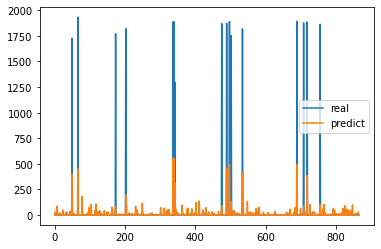

Epoch: 30; Test MAE loss on source data is: 40.560
Epoch: 30; Test MSE loss on source data is: 28719.322


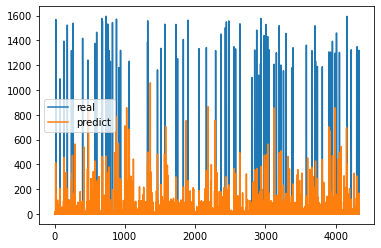

Epoch: 30; MSE loss: 1818161.115
34.367045993209516
40072.05441462224
Epoch: 31; MSE loss: 1901037.356
35.31919514754216
38623.32523208653
Epoch: 32; MSE loss: 1678995.724
32.579072970457254
40886.139632032224
Epoch: 33; MSE loss: 2015514.429
35.96598174870128
39499.005286661624
Epoch: 34; MSE loss: 1776608.529
34.663965436395415
41915.265777826535
Epoch: 35; MSE loss: 2036623.573
33.492499013547025
40899.20065245693
Epoch: 36; MSE loss: 1985172.204
35.55191971496841
37065.04771175182
Epoch: 37; MSE loss: 1807317.866
33.889957070319134
39519.4212273371
Epoch: 38; MSE loss: 1904320.536
36.27904412887993
38564.670684973964
Epoch: 39; MSE loss: 2007877.409
34.46559964604489
40232.912764032044
Epoch: 40; Test MAE loss on target data is: 34.466
Epoch: 40; Test MSE loss on target data is: 40232.913


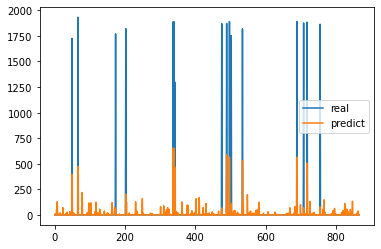

Epoch: 40; Test MAE loss on source data is: 37.881
Epoch: 40; Test MSE loss on source data is: 27997.142


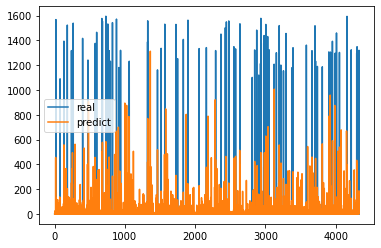

Epoch: 40; MSE loss: 1816536.905
33.95216670341328
36012.50825235842
Epoch: 41; MSE loss: 1875724.448
32.80457097960808
39123.04563549827
Epoch: 42; MSE loss: 1846839.809
36.769670487819425
37619.19626245796
Epoch: 43; MSE loss: 2106070.528
32.45235869288731
36196.316014345146
Epoch: 44; MSE loss: 1835418.700
34.587698724815496
39671.05854842494
Epoch: 45; MSE loss: 1850954.088
34.12740381062317
40743.23888247607
Epoch: 46; MSE loss: 1880848.133
32.41940153222882
38304.21146381922
Epoch: 47; MSE loss: 1956124.725
34.00027636189682
35536.59609725316
Epoch: 48; MSE loss: 1836258.946
35.58737057006872
38890.94564699866
Epoch: 49; MSE loss: 1882348.128
32.1342312700929
36788.44515782424
Epoch: 50; Test MAE loss on target data is: 32.134
Epoch: 50; Test MSE loss on target data is: 36788.445


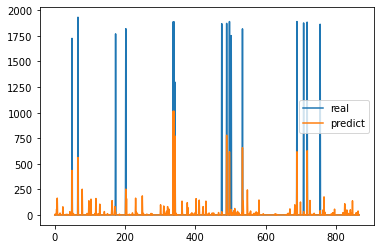

Epoch: 50; Test MAE loss on source data is: 34.648
Epoch: 50; Test MSE loss on source data is: 26591.977


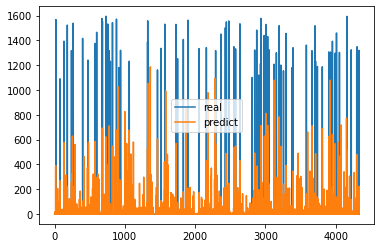

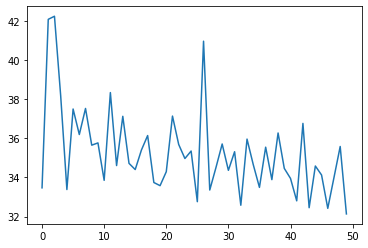

32.1342312700929
0.5219111134688015
0.7755257165609735


In [66]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,1]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/200
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 3
Epoch: 0; MSE loss: 2637111.895
29.523101239876592
36507.55012087017
Epoch: 1; MSE loss: 2721851.778
42.33550667721507
30284.21930447938
Epoch: 2; MSE loss: 2451012.124
36.241299989517785
26798.20928600606
Epoch: 3; MSE loss: 2047430.749
28.882516885268682
25472.710510617915
Epoch: 4; MSE loss: 2270398.362
31.443617593131812
23481.74022586707
Epoch: 5; MSE loss: 2075139.451
30.284780674894375
26406.848457270666
Epoch: 6; MSE loss: 2169025.739
33.65562673289041
25731.900345163504
Epoch: 7; MSE loss: 2167421.392
32.48539726820913
24471.707616080934
Epoch: 8; MSE loss: 2101817.715
29.75743504629751
24915.366833150085
Epoch: 9; MSE loss: 2060480.115
32.333904475634306
24009.431234414948
Epoch: 10; Test MAE loss on target data is: 32.334
Epoch: 10; Test MSE loss on target data is: 24009.431


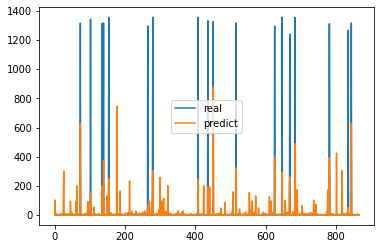

Epoch: 10; Test MAE loss on source data is: 43.861
Epoch: 10; Test MSE loss on source data is: 31209.610


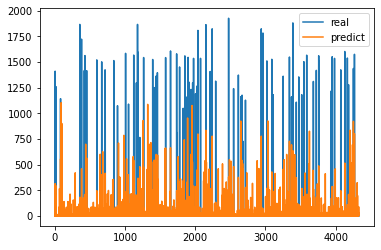

Epoch: 10; MSE loss: 2272362.262
29.52158523271786
24770.898845825912
Epoch: 11; MSE loss: 2266083.839
30.7626252823317
25283.56559063274
Epoch: 12; MSE loss: 2199699.472
35.34022512387768
24832.95877271526
Epoch: 13; MSE loss: 2084222.449
32.71658217834122
23856.868143543583
Epoch: 14; MSE loss: 2199493.999
29.500414672557955
25669.033644568248
Epoch: 15; MSE loss: 2157238.920
32.768866489537174
25346.67692535397
Epoch: 16; MSE loss: 2185712.090
32.9016054429999
24663.921133647775
Epoch: 17; MSE loss: 2252299.801
32.09190264983143
24758.72683116471
Epoch: 18; MSE loss: 2047356.300
30.908565743494407
25342.4592252852
Epoch: 19; MSE loss: 2216378.944
32.63930334600662
25122.049011425184
Epoch: 20; Test MAE loss on target data is: 32.639
Epoch: 20; Test MSE loss on target data is: 25122.049


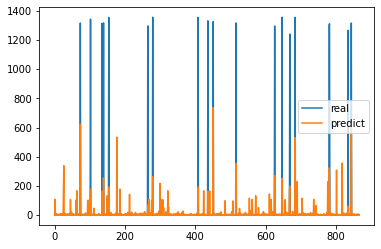

Epoch: 20; Test MAE loss on source data is: 43.660
Epoch: 20; Test MSE loss on source data is: 30490.934


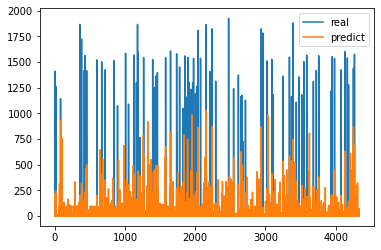

Epoch: 20; MSE loss: 2232690.427
32.34924047708408
25629.701399325277
Epoch: 21; MSE loss: 2016700.915
33.50607083309678
23940.543280025886
Epoch: 22; MSE loss: 2036439.287
31.315854985274445
25165.89445089656
Epoch: 23; MSE loss: 2181824.697
33.1920566957749
23313.632736302035
Epoch: 24; MSE loss: 2205110.905
33.28766082743701
24538.846415771637
Epoch: 25; MSE loss: 2045656.376
34.20172089799452
22294.88731050054
Epoch: 26; MSE loss: 2118333.747
28.869074681488048
26730.314554272154
Epoch: 27; MSE loss: 1980853.659
32.205051201522444
24560.41019193693
Epoch: 28; MSE loss: 2126117.621
31.786049035289718
24214.462142000328
Epoch: 29; MSE loss: 2145967.850
31.6605503613531
22853.657515047675
Epoch: 30; Test MAE loss on target data is: 31.661
Epoch: 30; Test MSE loss on target data is: 22853.658


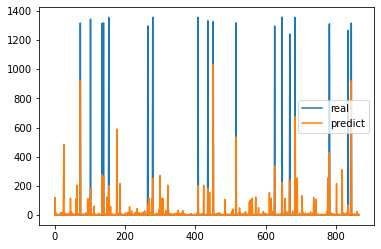

Epoch: 30; Test MAE loss on source data is: 44.424
Epoch: 30; Test MSE loss on source data is: 29538.876


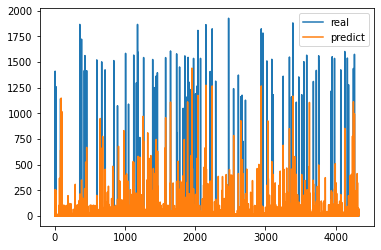

Epoch: 30; MSE loss: 1962380.401
27.988427146620438
24670.851278142964
Epoch: 31; MSE loss: 2185993.349
27.124435523303596
25825.182934411252
Epoch: 32; MSE loss: 1909656.010
33.73640598482404
24003.236644356093
Epoch: 33; MSE loss: 2066747.602
30.27020588301062
23752.92993253021
Epoch: 34; MSE loss: 1894945.096
28.40191993177487
24811.658801918762
Epoch: 35; MSE loss: 2153730.174
34.440766121861294
22894.829858045177
Epoch: 36; MSE loss: 1864013.494
28.632528620700093
26313.66715648376
Epoch: 37; MSE loss: 2014545.953
28.09987458728486
23250.201093732063
Epoch: 38; MSE loss: 2069578.731
28.090352999813415
23357.91961560273
Epoch: 39; MSE loss: 1972751.175
28.59434899442852
23234.11370361395
Epoch: 40; Test MAE loss on target data is: 28.594
Epoch: 40; Test MSE loss on target data is: 23234.114


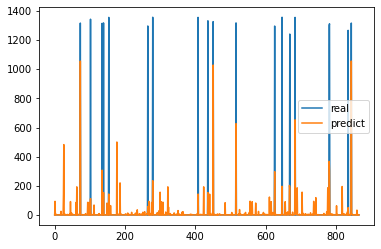

Epoch: 40; Test MAE loss on source data is: 40.099
Epoch: 40; Test MSE loss on source data is: 28909.035


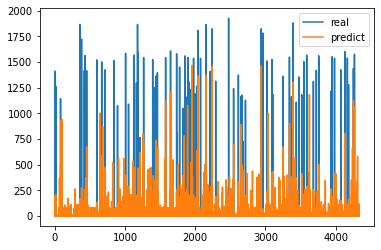

Epoch: 40; MSE loss: 1978029.666
30.265747174094276
23067.727752519702
Epoch: 41; MSE loss: 2014006.938
30.570279753295384
22118.504011153233
Epoch: 42; MSE loss: 2032664.630
26.304752987836334
23215.418182175894
Epoch: 43; MSE loss: 1814062.580
27.3100240809033
24819.651736980704
Epoch: 44; MSE loss: 2069964.696
31.571054964699066
21762.258757194915
Epoch: 45; MSE loss: 1891045.486
24.485739993913295
22926.130780007068
Epoch: 46; MSE loss: 2116723.680
28.39823329135896
24001.177349679696
Epoch: 47; MSE loss: 1931347.186
28.909054498466414
23771.85970013957
Epoch: 48; MSE loss: 1867395.615
27.791840634870557
20675.231187640013
Epoch: 49; MSE loss: 1890882.321
26.111545042535493
22493.13975541141
Epoch: 50; Test MAE loss on target data is: 26.112
Epoch: 50; Test MSE loss on target data is: 22493.140


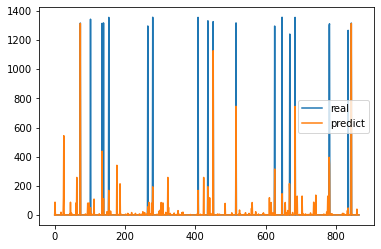

Epoch: 50; Test MAE loss on source data is: 37.994
Epoch: 50; Test MSE loss on source data is: 27917.811


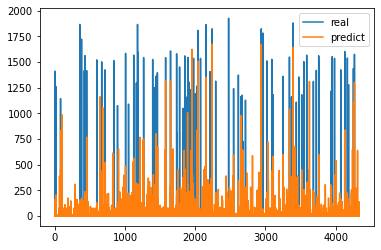

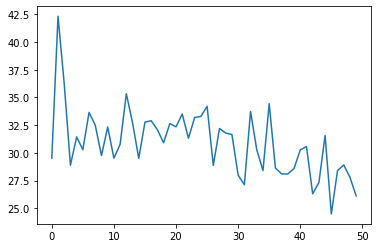

26.111545042535493
0.45898266207394856
0.7671492820680402


In [68]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 10
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [3]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/200
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 2437078.028
29.060125193286865
40147.90819003083
Epoch: 1; MSE loss: 2221407.942
47.744407042293815
33970.37759446644
Epoch: 2; MSE loss: 2106562.658
43.9328135638299
32513.635594303392
Epoch: 3; MSE loss: 1896132.083
36.91130253441434
30814.216109804267
Epoch: 4; MSE loss: 1928953.552
35.14812772540696
29525.998029368042
Epoch: 5; MSE loss: 2027875.651
30.923016793148822
30593.55855319189
Epoch: 6; MSE loss: 1996270.659
33.490208471423784
30071.748560114313
Epoch: 7; MSE loss: 2069820.812
32.812643586815845
30088.00307781289
Epoch: 8; MSE loss: 1877163.688
32.398604506044514
29939.363842386232
Epoch: 9; MSE loss: 1838899.499
32.860645725910636
29919.693018099115
Epoch: 10; Test MAE loss on target data is: 32.861
Epoch: 10; Test MSE loss on target data is: 29919.693


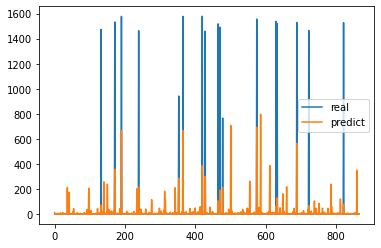

Epoch: 10; Test MAE loss on source data is: 38.900
Epoch: 10; Test MSE loss on source data is: 28183.519


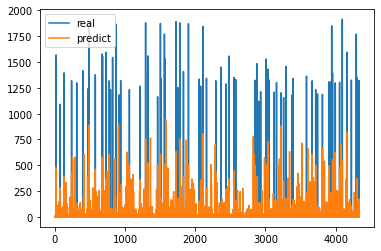

Epoch: 10; MSE loss: 4156457.541
39.2315229532398
29298.881274021736
Epoch: 11; MSE loss: 4120705.680
43.79796443871011
29662.47184548601
Epoch: 12; MSE loss: 4296164.887
39.849958906485135
29521.340580527223
Epoch: 13; MSE loss: 4264999.305
42.72085322535649
29609.574393239127
Epoch: 14; MSE loss: 4361148.258
45.28957802455576
29378.824503920474
Epoch: 15; MSE loss: 4031895.982
37.85474197258002
29545.638519049833
Epoch: 16; MSE loss: 4284126.631
50.764875976856466
29956.848888011067
Epoch: 17; MSE loss: 4396957.395
46.50171397007237
30105.63448918023
Epoch: 18; MSE loss: 4494314.977
45.66996206215668
29483.81279672222
Epoch: 19; MSE loss: 3948677.652
38.900926230533315
29092.476482604572
Epoch: 20; Test MAE loss on target data is: 38.901
Epoch: 20; Test MSE loss on target data is: 29092.476


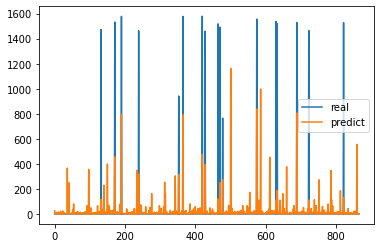

Epoch: 20; Test MAE loss on source data is: 48.359
Epoch: 20; Test MSE loss on source data is: 28566.778


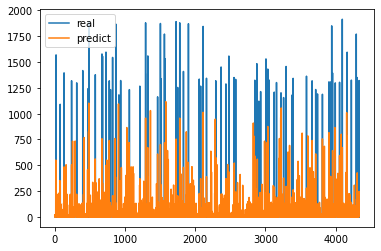

Epoch: 20; MSE loss: 3954473.568
36.32608366262537
29790.818741899806
Epoch: 21; MSE loss: 4238328.047
39.5777560260916
29865.792524505385
Epoch: 22; MSE loss: 4134569.398
40.5444386720898
30158.709530669872
Epoch: 23; MSE loss: 4061369.822
48.8019532177803
30167.844874535152
Epoch: 24; MSE loss: 4170693.721
32.854247274764546
30624.88890711114
Epoch: 25; MSE loss: 3844375.604
41.90107204030658
29121.699899339932
Epoch: 26; MSE loss: 4311706.695
39.637125937505
30023.009451699312
Epoch: 27; MSE loss: 4292326.729
49.35749975176294
30645.86856897059
Epoch: 28; MSE loss: 4380808.773
42.625734167570954
30186.26283021724
Epoch: 29; MSE loss: 4065035.959
40.872323301013864
30370.807720096178
Epoch: 30; Test MAE loss on target data is: 40.872
Epoch: 30; Test MSE loss on target data is: 30370.808


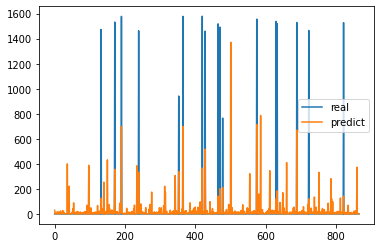

Epoch: 30; Test MAE loss on source data is: 49.250
Epoch: 30; Test MSE loss on source data is: 28243.510


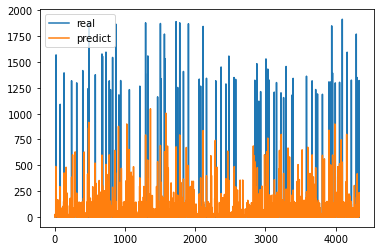

Epoch: 30; MSE loss: 3857699.455
40.73972338594436
30133.682389373396
Epoch: 31; MSE loss: 4025783.910
46.14910104422214
29905.94244680611
Epoch: 32; MSE loss: 4037306.947
37.79063861830871
29651.034594880883
Epoch: 33; MSE loss: 4187785.205
47.40404327492194
29918.6689231297
Epoch: 34; MSE loss: 4181268.283
36.582797436188905
30777.176893124866
Epoch: 35; MSE loss: 3955864.438
53.783176969285655
31249.116362811706
Epoch: 36; MSE loss: 4080019.672
39.50258303877941
30363.745515482282
Epoch: 37; MSE loss: 3965074.531
38.41944077668815
30421.686320268956
Epoch: 38; MSE loss: 3958727.330
38.18355340822713
30886.505398923502
Epoch: 39; MSE loss: 4225619.070
46.99400041430905
31509.0540379542
Epoch: 40; Test MAE loss on target data is: 46.994
Epoch: 40; Test MSE loss on target data is: 31509.054


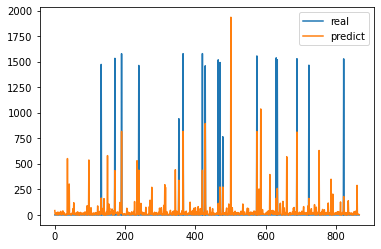

Epoch: 40; Test MAE loss on source data is: 58.720
Epoch: 40; Test MSE loss on source data is: 30115.911


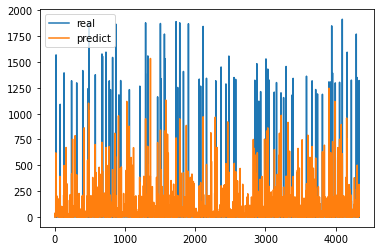

Epoch: 40; MSE loss: 4049603.205
38.974520646783304
30022.042698483532
Epoch: 41; MSE loss: 3975106.818
37.64632596527554
29300.42140552797
Epoch: 42; MSE loss: 4046259.809
41.16321304845468
29218.459205713058
Epoch: 43; MSE loss: 4081812.646
42.91843078787532
29635.92198450298
Epoch: 44; MSE loss: 4017490.590
39.709183150681106
29131.468479023948
Epoch: 45; MSE loss: 3917200.428
38.98952054552897
29938.870272172433
Epoch: 46; MSE loss: 4042188.365
41.84569131252125
30313.321067266097
Epoch: 47; MSE loss: 3797257.645
42.91596785576578
29353.63327227285
Epoch: 48; MSE loss: 4158409.895
38.682392860834746
29608.51302162444
Epoch: 49; MSE loss: 3906250.941
37.01359511581018
30054.04159801727
Epoch: 50; Test MAE loss on target data is: 37.014
Epoch: 50; Test MSE loss on target data is: 30054.042


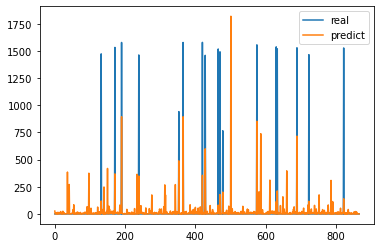

Epoch: 50; Test MAE loss on source data is: 45.504
Epoch: 50; Test MSE loss on source data is: 27047.982


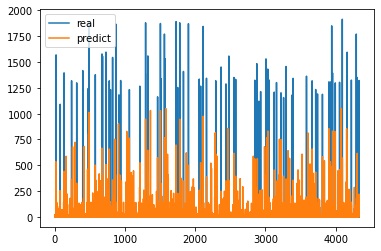

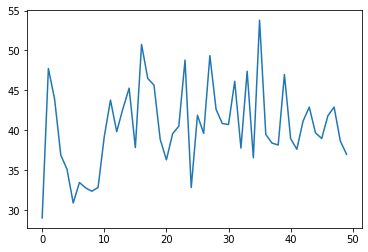

37.01359511581018
0.14618927506118704
0.8486730862961127
house instance is: 2
Epoch: 0; MSE loss: 2839850.935
25.439461007048273
33925.314106216916
Epoch: 1; MSE loss: 2406910.172
49.30758689321586
29788.975190587793
Epoch: 2; MSE loss: 2183864.995
41.16040858942607
29438.90150372589
Epoch: 3; MSE loss: 2144038.929
35.47788487018581
29741.021894365636
Epoch: 4; MSE loss: 2211209.694
33.122258485665476
30629.370129985888
Epoch: 5; MSE loss: 1987670.151
35.88136185127318
30648.439467665514
Epoch: 6; MSE loss: 2378909.693
39.41367112275432
29376.682997002856
Epoch: 7; MSE loss: 2109552.658
31.630147178009615
29238.177533350623
Epoch: 8; MSE loss: 2122273.245
41.47522888686229
29071.493530190364
Epoch: 9; MSE loss: 2023351.684
33.02190103431285
30619.098444845724
Epoch: 10; Test MAE loss on target data is: 33.022
Epoch: 10; Test MSE loss on target data is: 30619.098


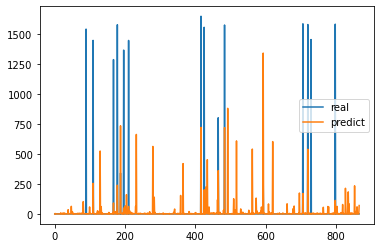

Epoch: 10; Test MAE loss on source data is: 36.416
Epoch: 10; Test MSE loss on source data is: 30802.055


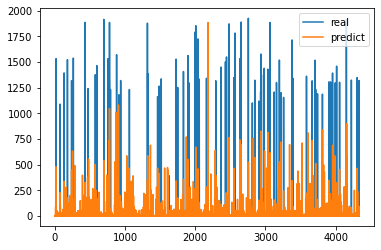

Epoch: 10; MSE loss: 4792972.986
43.070449245567275
28815.061974216103
Epoch: 11; MSE loss: 4778974.832
59.11431790443165
28837.964177815415
Epoch: 12; MSE loss: 4700472.258
47.51095734390558
28235.56351135121
Epoch: 13; MSE loss: 4631238.084
47.5926377287923
28608.980391409368
Epoch: 14; MSE loss: 4624587.461
42.864150405273854
28642.022826487177
Epoch: 15; MSE loss: 4675876.986
45.13887173611125
29316.76338150578
Epoch: 16; MSE loss: 4438729.285
49.89944067875819
30228.35144598849
Epoch: 17; MSE loss: 4492051.734
49.8948535712945
28614.855597925416
Epoch: 18; MSE loss: 4660761.373
48.70524045560324
28517.21144713908
Epoch: 19; MSE loss: 4335569.266
40.69790615278458
29139.83512401187
Epoch: 20; Test MAE loss on target data is: 40.698
Epoch: 20; Test MSE loss on target data is: 29139.835


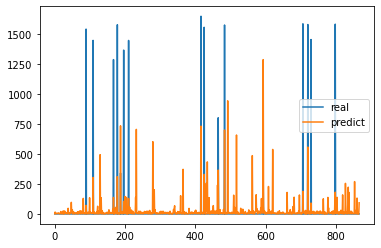

Epoch: 20; Test MAE loss on source data is: 44.989
Epoch: 20; Test MSE loss on source data is: 30375.057


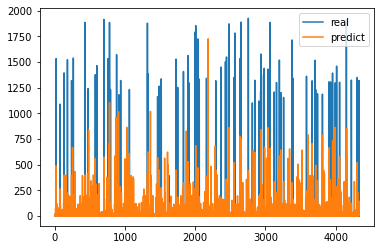

Epoch: 20; MSE loss: 4759412.865
47.06086764286134
29370.759888063265
Epoch: 21; MSE loss: 4775341.695
39.99959117936394
27987.44441155841
Epoch: 22; MSE loss: 4500975.232
54.65554995850296
29372.160903813183
Epoch: 23; MSE loss: 4743799.109
39.03152090096212
30466.398932727676
Epoch: 24; MSE loss: 5030579.719
51.666591115751345
30836.534113327147
Epoch: 25; MSE loss: 4275119.125
38.19396016791016
28967.061900412038
Epoch: 26; MSE loss: 4621664.637
53.83412175965007
30356.571948972178
Epoch: 27; MSE loss: 4619834.129
49.07433193887669
29181.624305788897
Epoch: 28; MSE loss: 4546918.309
49.11260855541647
29848.009234936584
Epoch: 29; MSE loss: 4336689.479
50.59940613897339
31553.86530861729
Epoch: 30; Test MAE loss on target data is: 50.599
Epoch: 30; Test MSE loss on target data is: 31553.865


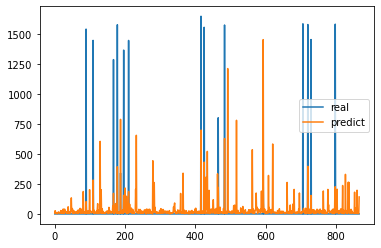

Epoch: 30; Test MAE loss on source data is: 53.550
Epoch: 30; Test MSE loss on source data is: 31327.737


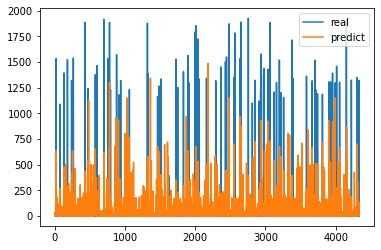

Epoch: 30; MSE loss: 4362843.562
53.17351460209355
32611.26718343521
Epoch: 31; MSE loss: 4138610.914
50.782516354920546
29935.492153083036
Epoch: 32; MSE loss: 3961924.023
47.24162640748277
30293.8498734791
Epoch: 33; MSE loss: 4595394.504
44.95368390278558
29506.067872710493
Epoch: 34; MSE loss: 3989904.814
53.885271536575196
30604.408260014792
Epoch: 35; MSE loss: 4412291.672
45.9917080266253
30437.452257926187
Epoch: 36; MSE loss: 4356476.096
57.53961373970445
32114.638130493375
Epoch: 37; MSE loss: 4227875.883
43.53510643454159
29426.088633669282
Epoch: 38; MSE loss: 4479887.561
49.15270737875704
29116.381492607485
Epoch: 39; MSE loss: 4444469.492
49.986571882079076
30320.40835004672
Epoch: 40; Test MAE loss on target data is: 49.987
Epoch: 40; Test MSE loss on target data is: 30320.408


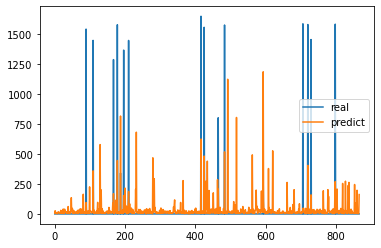

Epoch: 40; Test MAE loss on source data is: 53.638
Epoch: 40; Test MSE loss on source data is: 30903.927


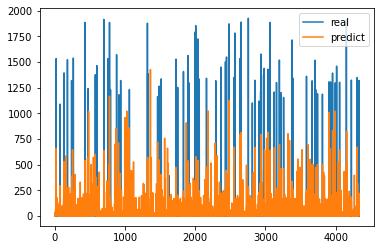

Epoch: 40; MSE loss: 4373534.113
50.38969821060955
35850.581605403044
Epoch: 41; MSE loss: 4180432.102
37.476167415097926
31405.820041688352
Epoch: 42; MSE loss: 4352210.355
43.004279704603356
30647.29462102599
Epoch: 43; MSE loss: 4436843.588
55.58496603606894
32784.36166619713
Epoch: 44; MSE loss: 4770508.371
41.40905141842475
30365.967764537203
Epoch: 45; MSE loss: 4219175.859
56.7004085670568
31460.050419819305
Epoch: 46; MSE loss: 4383475.859
42.6807685743635
30786.07467935884
Epoch: 47; MSE loss: 4668288.359
48.46320543762172
32116.78494983403
Epoch: 48; MSE loss: 4299178.848
50.144797171963404
30605.90185531807
Epoch: 49; MSE loss: 4501852.234
56.28834607664414
30893.233988329514
Epoch: 50; Test MAE loss on target data is: 56.288
Epoch: 50; Test MSE loss on target data is: 30893.234


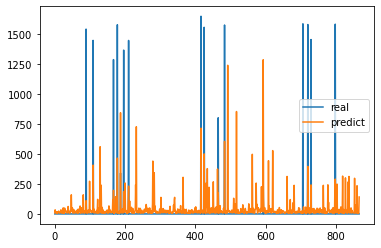

Epoch: 50; Test MAE loss on source data is: 59.425
Epoch: 50; Test MSE loss on source data is: 31283.404


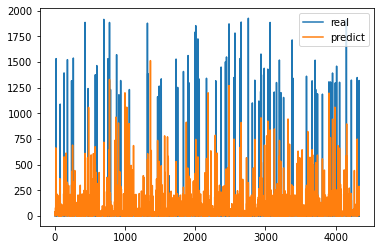

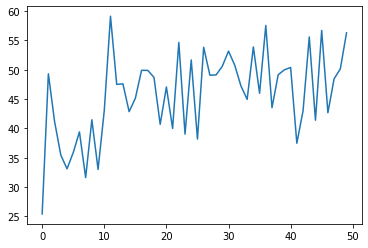

56.28834607664414
0.8085259428354021
0.9361863654037658
house instance is: 5
Epoch: 0; MSE loss: 2820066.855
31.012725781849152
36883.17252059422
Epoch: 1; MSE loss: 2403201.575
54.97952129224782
31992.468007976073
Epoch: 2; MSE loss: 2371943.909
53.77808934362791
31266.855058130295
Epoch: 3; MSE loss: 2100168.700
49.16708473224706
32146.358280722216
Epoch: 4; MSE loss: 2127348.170
47.527348465156756
34402.85159569407
Epoch: 5; MSE loss: 1992407.507
43.32091042542918
34456.364869706325
Epoch: 6; MSE loss: 2347665.916
47.73109709146629
34676.86338626531
Epoch: 7; MSE loss: 2214749.906
54.151273186184305
36492.23224484897
Epoch: 8; MSE loss: 2159017.224
47.999603970481175
34986.62030850191
Epoch: 9; MSE loss: 2088277.552
47.373295359753904
36034.30547351893
Epoch: 10; Test MAE loss on target data is: 47.373
Epoch: 10; Test MSE loss on target data is: 36034.305


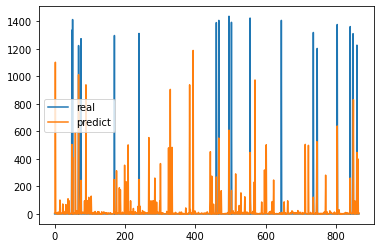

Epoch: 10; Test MAE loss on source data is: 40.590
Epoch: 10; Test MSE loss on source data is: 32406.058


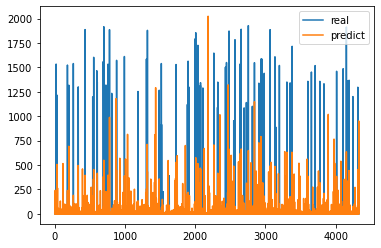

Epoch: 10; MSE loss: 4686356.031
58.753820250964495
37943.47521120356
Epoch: 11; MSE loss: 4581390.658
64.35237973517681
35674.78453077092
Epoch: 12; MSE loss: 4815602.070
73.49042547807836
39993.25672484546
Epoch: 13; MSE loss: 4681276.242
52.8057674856893
34268.728059686284
Epoch: 14; MSE loss: 4811204.797
69.53685755109696
39690.35150987666
Epoch: 15; MSE loss: 4666775.875
58.14067213003059
35739.44620148759
Epoch: 16; MSE loss: 4316282.447
60.15634007935843
36362.62689131794
Epoch: 17; MSE loss: 4505253.668
68.1869360106764
40801.558618618335
Epoch: 18; MSE loss: 4842381.562
58.86746883001436
36699.7083352363
Epoch: 19; MSE loss: 4519564.504
60.282836634824704
35806.759920382974
Epoch: 20; Test MAE loss on target data is: 60.283
Epoch: 20; Test MSE loss on target data is: 35806.760


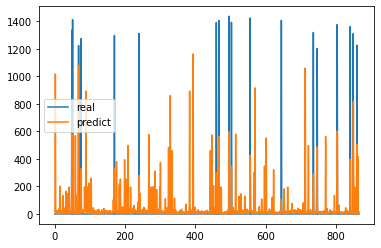

Epoch: 20; Test MAE loss on source data is: 54.796
Epoch: 20; Test MSE loss on source data is: 32606.939


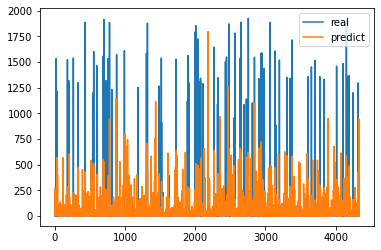

Epoch: 20; MSE loss: 4685959.619
63.02520743827953
35720.75816954662
Epoch: 21; MSE loss: 4738382.508
68.82032599130854
39455.083698498405
Epoch: 22; MSE loss: 4536438.027
57.46950009470803
35085.81485518665
Epoch: 23; MSE loss: 4708774.223
68.88690156648376
38721.95468741636
Epoch: 24; MSE loss: 4401251.203
57.73850710743409
34346.91375336165
Epoch: 25; MSE loss: 4603856.164
57.9523368657254
34146.532350353096
Epoch: 26; MSE loss: 4879582.785
65.38790572310057
37760.29310278799
Epoch: 27; MSE loss: 4538945.289
63.53551895632017
38149.6494461179
Epoch: 28; MSE loss: 4504618.723
65.5713852347877
39012.94308307691
Epoch: 29; MSE loss: 4614670.727
57.472581058225
34570.80718112548
Epoch: 30; Test MAE loss on target data is: 57.473
Epoch: 30; Test MSE loss on target data is: 34570.807


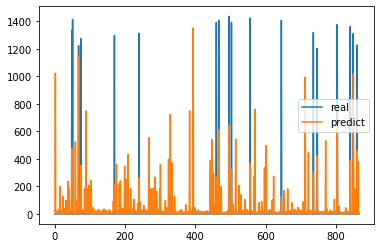

Epoch: 30; Test MAE loss on source data is: 52.408
Epoch: 30; Test MSE loss on source data is: 31951.856


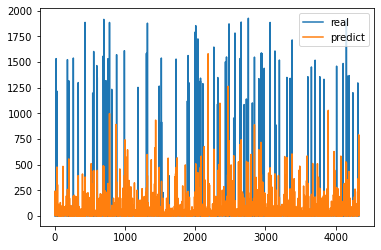

Epoch: 30; MSE loss: 4538485.465
77.42528546784575
42218.217230054404
Epoch: 31; MSE loss: 4680723.479
52.183821836041744
34498.8896723749
Epoch: 32; MSE loss: 4511411.512
56.461887056147624
38062.79030002136
Epoch: 33; MSE loss: 4492425.650
63.57072505979845
38686.53726550812
Epoch: 34; MSE loss: 4886531.785
70.1749690235383
39075.38480338994
Epoch: 35; MSE loss: 4683243.598
68.65360590161363
37734.116586086864
Epoch: 36; MSE loss: 4386126.637
66.94862471571602
37416.44631284526
Epoch: 37; MSE loss: 4294869.402
64.81772818918219
37344.583060040386
Epoch: 38; MSE loss: 4819696.047
60.28113404124322
36569.97505097945
Epoch: 39; MSE loss: 4577945.527
67.15530474258387
39178.96495576956
Epoch: 40; Test MAE loss on target data is: 67.155
Epoch: 40; Test MSE loss on target data is: 39178.965


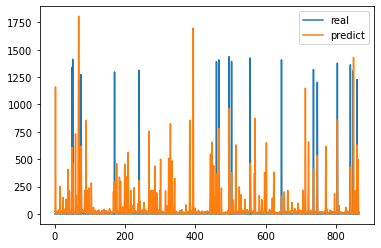

Epoch: 40; Test MAE loss on source data is: 59.390
Epoch: 40; Test MSE loss on source data is: 32548.243


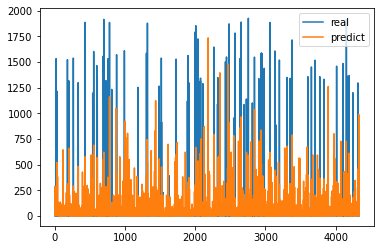

Epoch: 40; MSE loss: 4636685.133
57.2518444704719
33862.77002778312
Epoch: 41; MSE loss: 4482325.092
56.85193908335523
34131.33043892117
Epoch: 42; MSE loss: 4784894.301
78.20300141572437
45441.32352464918
Epoch: 43; MSE loss: 4715182.602
52.889158914499454
33225.392683837694
Epoch: 44; MSE loss: 4414199.963
75.88602510319792
44445.97905991021
Epoch: 45; MSE loss: 4660383.070
59.26699965139754
35491.1597653868
Epoch: 46; MSE loss: 4412721.402
71.67823821465208
43563.3863987821
Epoch: 47; MSE loss: 4511341.320
57.35560986514374
35751.06434791877
Epoch: 48; MSE loss: 4758407.414
64.6159024328088
36648.5981797604
Epoch: 49; MSE loss: 4367497.018
61.930279122863176
38312.201599540116
Epoch: 50; Test MAE loss on target data is: 61.930
Epoch: 50; Test MSE loss on target data is: 38312.202


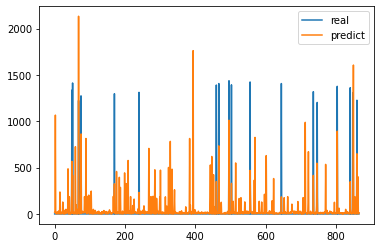

Epoch: 50; Test MAE loss on source data is: 54.574
Epoch: 50; Test MSE loss on source data is: 31591.202


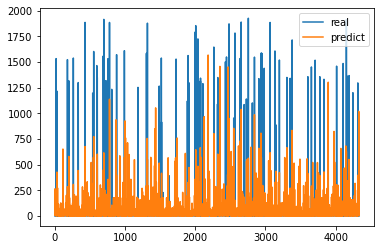

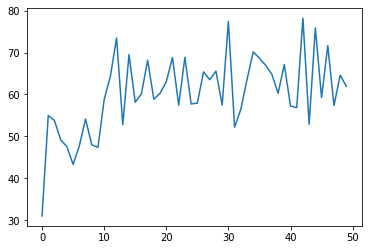

61.930279122863176
0.9090259157482026
0.990808619588128


In [65]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.0001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0,2,5]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="dynamic"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [1]:
trainfile1="F:/NILM/training_data/fridge_house_3_training_.csv"
trainfile2="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1,trainfile2]
stepsizeList=[2,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=50
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

NameError: name 'dataProvider' is not defined

house instance is: 0
Epoch: 0; MSE loss: 608255.632
49.654139574570294
6617.721672440142
Epoch: 1; MSE loss: 503115.280
52.35698732562971
4882.65173431258
Epoch: 2; MSE loss: 468705.375
52.75288422478108
4690.450250110554
Epoch: 3; MSE loss: 437328.464
52.58696550618483
4957.444920602018
Epoch: 4; MSE loss: 438790.744
52.48220734668559
4907.517392475897
Epoch: 5; MSE loss: 525283.900
52.60719129225868
4725.367106456748
Epoch: 6; MSE loss: 498145.328
52.40124641282675
4997.329060467323
Epoch: 7; MSE loss: 422007.196
52.570395607958254
4821.116405061886
Epoch: 8; MSE loss: 397684.786
52.52594033477634
4906.957550951925
Epoch: 9; MSE loss: 490391.135
52.38625497450991
4749.508230088822
Epoch: 10; Test MAE loss on target data is: 52.386
Epoch: 10; Test MSE loss on target data is: 4749.508


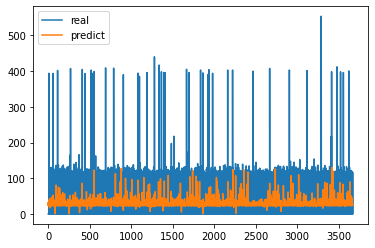

Epoch: 10; Test MAE loss on source data is: 33.418
Epoch: 10; Test MSE loss on source data is: 1542.549


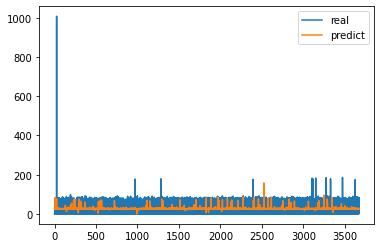

Epoch: 10; MSE loss: 435956.110
52.22915817432806
4977.930208914599
Epoch: 11; MSE loss: 425046.936
52.33765628781011
4889.649238041822
Epoch: 12; MSE loss: 444140.464
52.51480930680465
4844.025873648431
Epoch: 13; MSE loss: 482519.814
52.451530944247835
4928.998530439357
Epoch: 14; MSE loss: 398588.047
52.45171021105406
4896.076895859172
Epoch: 15; MSE loss: 479152.509
52.424871731116184
4722.167989314479
Epoch: 16; MSE loss: 471220.941
52.33632629363443
4775.8279431170495
Epoch: 17; MSE loss: 412690.781
52.23630625296925
4766.106918983532
Epoch: 18; MSE loss: 410815.333
52.097800115143514
4957.404829998762
Epoch: 19; MSE loss: 372391.273
52.08067769990417
4967.412618706159
Epoch: 20; Test MAE loss on target data is: 52.081
Epoch: 20; Test MSE loss on target data is: 4967.413


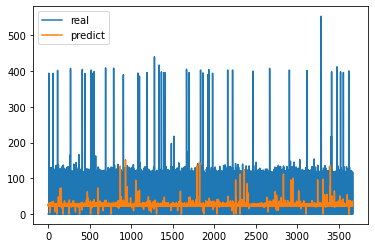

Epoch: 20; Test MAE loss on source data is: 32.584
Epoch: 20; Test MSE loss on source data is: 1539.891


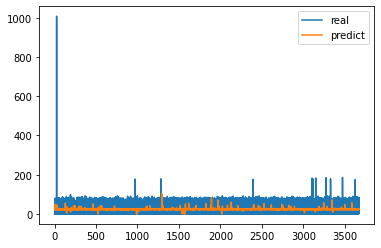

Epoch: 20; MSE loss: 456231.296
52.38280733974128
4832.891543070655
Epoch: 21; MSE loss: 454047.703
52.127336974117135
4803.299228176189
Epoch: 22; MSE loss: 416188.107
52.067014572347176
4878.475314850707
Epoch: 23; MSE loss: 470646.438
52.23055829054315
4655.240294499304
Epoch: 24; MSE loss: 425242.641
51.98287794755176
4768.024162509129
Epoch: 25; MSE loss: 380779.368
51.98763097621738
4710.65398574658
Epoch: 26; MSE loss: 430361.704
51.7732834830274
4892.327544558679
Epoch: 27; MSE loss: 444298.312
51.77210675828476
4829.396630329958
Epoch: 28; MSE loss: 449772.251
51.70064777865956
4847.349755337729
Epoch: 29; MSE loss: 423429.443
51.611774908568655
5002.40216335086
Epoch: 30; Test MAE loss on target data is: 51.612
Epoch: 30; Test MSE loss on target data is: 5002.402


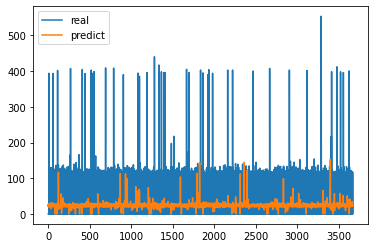

Epoch: 30; Test MAE loss on source data is: 32.213
Epoch: 30; Test MSE loss on source data is: 1524.308


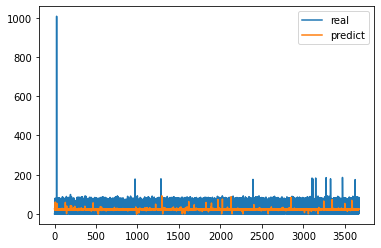

Epoch: 30; MSE loss: 450856.250
51.66926449208756
4799.873883213257
Epoch: 31; MSE loss: 417731.570
51.76219996323131
4711.278052623806
Epoch: 32; MSE loss: 461792.027
51.49909152345329
4779.650442545969
Epoch: 33; MSE loss: 478999.674
51.4478697581982
4851.011760960809
Epoch: 34; MSE loss: 425870.119
51.31261234713907
4715.322708556914
Epoch: 35; MSE loss: 421280.433
51.234034353945475
4776.566511471999
Epoch: 36; MSE loss: 403694.292
51.12878142236246
4639.421676868209
Epoch: 37; MSE loss: 462215.929
52.21072307895827
4683.386727575385
Epoch: 38; MSE loss: 434784.991
51.7201148226937
4689.337244027225
Epoch: 39; MSE loss: 425234.091
51.237600181902245
4623.980303536801
Epoch: 40; Test MAE loss on target data is: 51.238
Epoch: 40; Test MSE loss on target data is: 4623.980


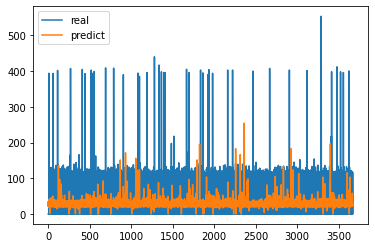

Epoch: 40; Test MAE loss on source data is: 32.528
Epoch: 40; Test MSE loss on source data is: 1476.213


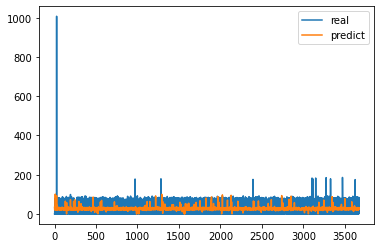

Epoch: 40; MSE loss: 438270.370
50.91508844902629
4630.389183952256
Epoch: 41; MSE loss: 455864.219
50.44449357549604
4524.461542581895
Epoch: 42; MSE loss: 438776.549
50.22452132253526
4577.121705088847
Epoch: 43; MSE loss: 421075.083
49.754669076348804
4547.272992879782
Epoch: 44; MSE loss: 403117.263
49.66273988452539
4529.105226896862
Epoch: 45; MSE loss: 477914.884
49.07637731033981
4427.068135236639
Epoch: 46; MSE loss: 401456.788
48.605476389114855
4381.243899671389
Epoch: 47; MSE loss: 429435.155
48.53294870796704
4579.463758747151
Epoch: 48; MSE loss: 374487.739
48.248335414558234
4300.948790146629
Epoch: 49; MSE loss: 409496.577
46.977271950181034
4454.995342628501
Epoch: 50; Test MAE loss on target data is: 46.977
Epoch: 50; Test MSE loss on target data is: 4454.995


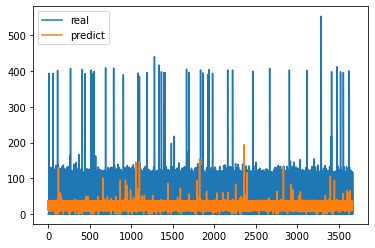

Epoch: 50; Test MAE loss on source data is: 29.447
Epoch: 50; Test MSE loss on source data is: 1427.582


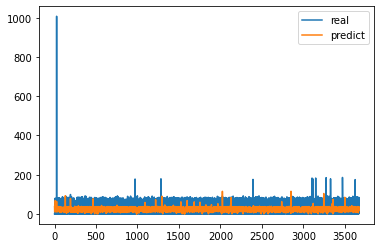

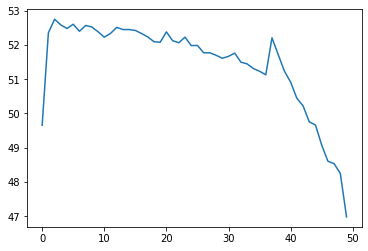

46.977271950181034
0.46615220761641746
0.8081491086973844


In [97]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.0004
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="dynamic"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [88]:
trainfile1="F:/NILM/training_data/fridge_house_3_training_.csv"
trainfile2="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1,trainfile2]
stepsizeList=[2,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=50
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[18353, 18353]


house instance is: 0
Epoch: 0; MSE loss: 546213.187
49.65326306991422
6689.706979784117
Epoch: 1; MSE loss: 484996.025
51.58812747005545
5008.362181534732
Epoch: 2; MSE loss: 417502.688
51.910484873457236
5114.439752671314
Epoch: 3; MSE loss: 479726.298
52.87248574889649
4988.039778824302
Epoch: 4; MSE loss: 442539.648
53.13252059002181
5015.223087457097
Epoch: 5; MSE loss: 424210.856
53.29220050692958
4899.798783683932
Epoch: 6; MSE loss: 561190.190
53.17856205420068
5017.160815358117
Epoch: 7; MSE loss: 515832.685
53.24588347226043
5060.436380311879
Epoch: 8; MSE loss: 445118.068
53.2459294563265
5065.187273150122
Epoch: 9; MSE loss: 472552.989
53.24337385012626
5032.455581492135
Epoch: 10; Test MAE loss on target data is: 53.243
Epoch: 10; Test MSE loss on target data is: 5032.456


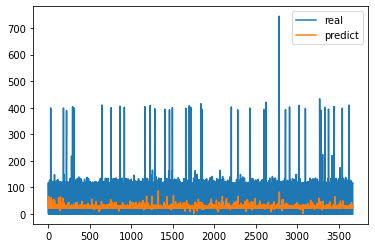

Epoch: 10; Test MAE loss on source data is: 33.067
Epoch: 10; Test MSE loss on source data is: 1327.404


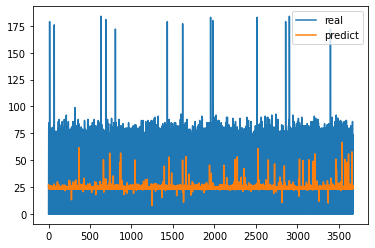

Epoch: 10; MSE loss: 467092.529
53.05737539388974
5050.703442470758
Epoch: 11; MSE loss: 391147.307
53.019288107905695
5027.442315995964
Epoch: 12; MSE loss: 417791.052
53.06613058273402
5045.5432640934105
Epoch: 13; MSE loss: 412546.288
52.976131526637786
4989.1117420533965
Epoch: 14; MSE loss: 404031.839
52.88419599866689
5027.381918714922
Epoch: 15; MSE loss: 418290.913
52.86243156256494
5119.561149876058
Epoch: 16; MSE loss: 577997.354
52.84987574617122
5131.679078165402
Epoch: 17; MSE loss: 402078.960
52.92147137089775
4881.598663055175
Epoch: 18; MSE loss: 496112.029
52.896721066275
4979.467517668745
Epoch: 19; MSE loss: 410178.704
52.691920491900675
5039.813391502508
Epoch: 20; Test MAE loss on target data is: 52.692
Epoch: 20; Test MSE loss on target data is: 5039.813


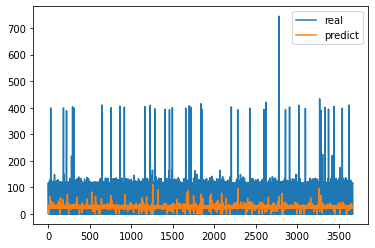

Epoch: 20; Test MAE loss on source data is: 32.531
Epoch: 20; Test MSE loss on source data is: 1304.573


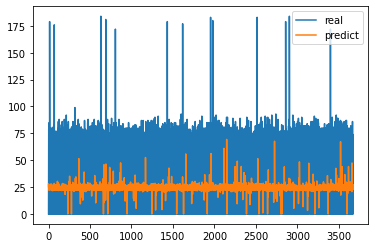

Epoch: 20; MSE loss: 479047.555
52.902711440705474
4935.891833553784
Epoch: 21; MSE loss: 428892.032
52.594934550886485
4807.096171196466
Epoch: 22; MSE loss: 389888.890
52.375961034648434
4977.862452621678
Epoch: 23; MSE loss: 394621.527
52.34271993352835
4854.974924118754
Epoch: 24; MSE loss: 426475.144
52.22704691811347
4856.071472574024
Epoch: 25; MSE loss: 392003.284
52.44748718815625
5268.946863603508
Epoch: 26; MSE loss: 440765.555
52.24165064349201
5044.514082918129
Epoch: 27; MSE loss: 390484.277
51.94197542419726
4959.340348633894
Epoch: 28; MSE loss: 433190.921
52.009066604955265
4945.079535821175
Epoch: 29; MSE loss: 420999.415
51.596051292210305
4760.468304547779
Epoch: 30; Test MAE loss on target data is: 51.596
Epoch: 30; Test MSE loss on target data is: 4760.468


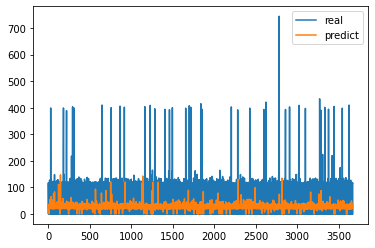

Epoch: 30; Test MAE loss on source data is: 32.324
Epoch: 30; Test MSE loss on source data is: 1264.527


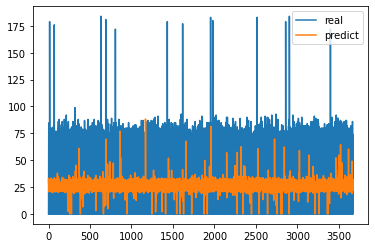

Epoch: 30; MSE loss: 453292.290
51.67923511746988
4699.013391631917
Epoch: 31; MSE loss: 422529.290
51.08001117097479
4850.665341776689
Epoch: 32; MSE loss: 378173.107
51.15465143609521
4703.321989409949
Epoch: 33; MSE loss: 378105.722
50.61283690918534
4516.199373752803
Epoch: 34; MSE loss: 354832.115
50.11514280695449
4694.127228750326
Epoch: 35; MSE loss: 390352.406
49.54036221941829
4497.952605977879
Epoch: 36; MSE loss: 422352.376
49.88503654541333
4598.603474491793
Epoch: 37; MSE loss: 413673.195
49.42307291433389
4476.827381155462
Epoch: 38; MSE loss: 392995.310
48.81688725365979
4633.98618317753
Epoch: 39; MSE loss: 395689.172
49.391082202724945
4572.943967578558
Epoch: 40; Test MAE loss on target data is: 49.391
Epoch: 40; Test MSE loss on target data is: 4572.944


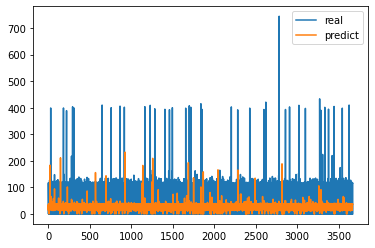

Epoch: 40; Test MAE loss on source data is: 31.804
Epoch: 40; Test MSE loss on source data is: 1225.796


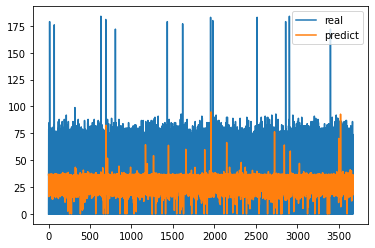

Epoch: 40; MSE loss: 392085.138
48.635662763036265
4557.908301031497
Epoch: 41; MSE loss: 451243.345
48.08270967425588
4373.40382037028
Epoch: 42; MSE loss: 436621.174
47.86727468469298
4373.490353600259
Epoch: 43; MSE loss: 451288.010
47.53691878007206
4321.643816960399
Epoch: 44; MSE loss: 339841.110
49.71500928657213
4995.8935662546455
Epoch: 45; MSE loss: 384887.942
46.82296841109166
4379.740482908262
Epoch: 46; MSE loss: 392028.268
47.22884774426451
4292.788822587281
Epoch: 47; MSE loss: 370131.668
46.51100992797604
4447.485766888411
Epoch: 48; MSE loss: 389973.350
47.05253488281372
4791.192478483044
Epoch: 49; MSE loss: 341213.371
46.79784116061
4263.680066363467
Epoch: 50; Test MAE loss on target data is: 46.798
Epoch: 50; Test MSE loss on target data is: 4263.680


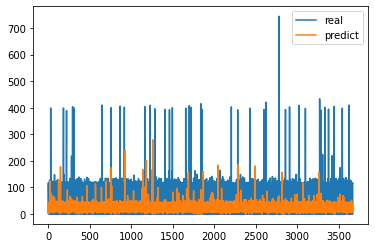

Epoch: 50; Test MAE loss on source data is: 30.503
Epoch: 50; Test MSE loss on source data is: 1187.624


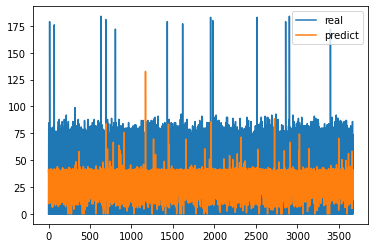

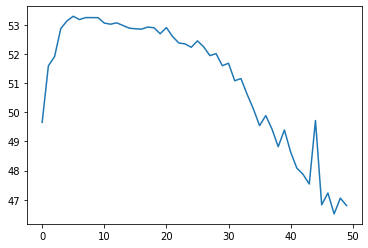

46.79784116061
0.37446480739574584
0.7813061311275987


In [89]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.0001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [8]:
trainfile1="F:/NILM/training_data/washingmachine_house_3_training_.csv"
trainfile2="F:/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"
fileList=[trainfile1,trainfile2]
stepsizeList=[2,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=20
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[18353, 18353]


house instance is: 0
Epoch: 0; MSE loss: 7971744.871
42.20362336898248
83220.2090684503
Epoch: 1; MSE loss: 7639478.237
58.13297677902924
67234.46536687194
Epoch: 2; MSE loss: 8156260.437
47.2722052490464
80761.17921788155
Epoch: 3; MSE loss: 7389787.877
47.71669224113555
76210.21343274163
Epoch: 4; MSE loss: 7364944.505
53.995752105526414
74336.78791110736
Epoch: 5; MSE loss: 6742688.491
49.47459785861971
73995.4551215412
Epoch: 6; MSE loss: 6807189.721
52.57287239549807
74224.14751613555
Epoch: 7; MSE loss: 8294303.176
59.46136319183383
73077.96368418046
Epoch: 8; MSE loss: 7355867.147
46.81025092398331
82365.25639816915
Epoch: 9; MSE loss: 7876102.675
45.84065521312804
83631.67329732374
Epoch: 10; Test MAE loss on target data is: 45.841
Epoch: 10; Test MSE loss on target data is: 83631.673
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: sco

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal 600 normal>) = 11.24
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal 300 normal>) = 11.145
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Berlin Sans FB' (BRLNSB.

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal 350 normal>) = 11.0975
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal 700 condensed>) = 10.535
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Edwardian Script ITC' (ITCEDSCR.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal nor

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal 300 normal>) = 10.145
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal 290 normal>) = 10.1545
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal 700 normal>) = 11.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal 700 normal>) = 11.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Eras Medium ITC' (ERASMD.TTF) 

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'SimHei' (simhei.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal 400 condensed>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Ravie' (RAV

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal 300 normal>) = 11.145
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Engravers MT' (ENGR.TTF) normal normal 500 normal>) = 10.145
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Candara' (Candarali.ttf) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'LiSu' (SIMLI.TTF) normal normal 400 normal>) = 1

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Viner Hand ITC' (VINERITC.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Franklin Gothic Medium' (framdit.ttf) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Franklin Gothic Demi' (FRADM.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Leelawadee UI' (LeelUIsl.ttf) normal normal 350 normal>) = 10.0975
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'STXinwei' (STXINWEI.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Segoe Script' (

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal 350 normal>) = 10.0975
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Copperplate Gothic Light' (COPRGTL.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Harlow Solid Italic' (HARLOWSI.TTF) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Ravie' (RAVIE.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Californian FB' (CAL

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 6.8986363636363635
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal 700 normal>) = 11.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Lucida Sans' (LSANS.TTF)

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'FangSong' (simfang.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Microsoft Sans Serif' (micross.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Constantia' (constanb.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Sitka Small' (SitkaI.ttc) ital

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal 400 condensed>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Freestyle Script' (FREESCPT.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Bodoni MT' (BOD_BLAR.TTF) normal normal 900 normal>) = 10.525
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Bodoni M

09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal 400 condensed>) = 10.25
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal 700 normal>) = 11.335
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal 400 normal>) = 10.05
09-04 16:52 [MainProcess, 25436] [DEBUG]  findfont: score(<Font 'Gill Sans

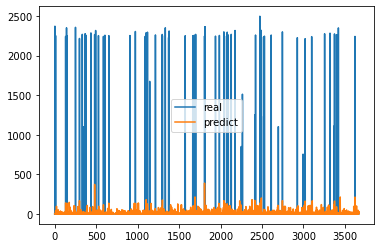

Epoch: 10; Test MAE loss on source data is: 25.546
Epoch: 10; Test MSE loss on source data is: 23428.899


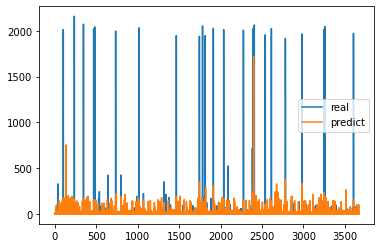

Epoch: 10; MSE loss: 7985144.048
43.094290043658404
83110.97091958173
Epoch: 11; MSE loss: 7513544.324
51.320706769308515
76554.75382347149
Epoch: 12; MSE loss: 8614943.597
53.99948024706323
76718.33419314575
Epoch: 13; MSE loss: 8297368.785
53.419237487815735
74657.60471406931
Epoch: 14; MSE loss: 7178007.472
48.4376200186142
80980.89572475113
Epoch: 15; MSE loss: 7570784.560
54.836355291049216
77930.88542093351
Epoch: 16; MSE loss: 7620392.857
45.91027765716009
79563.24297477074
Epoch: 17; MSE loss: 6195622.877
46.923658023572884
82008.4703438847
Epoch: 18; MSE loss: 6919351.169
52.38620684048893
81283.64209919155
Epoch: 19; MSE loss: 8032448.334
48.73115152201773
81714.4537217559
Epoch: 20; Test MAE loss on target data is: 48.731
Epoch: 20; Test MSE loss on target data is: 81714.454


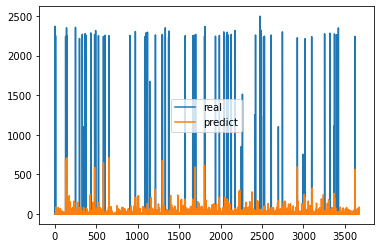

Epoch: 20; Test MAE loss on source data is: 31.304
Epoch: 20; Test MSE loss on source data is: 24381.804


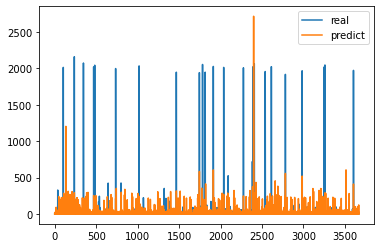

Epoch: 20; MSE loss: 7053320.418
57.419744298613
81772.85388717058
Epoch: 21; MSE loss: 6847010.588
51.77233623733348
81438.16889941618
Epoch: 22; MSE loss: 7713066.735
55.568296458660434
79489.8503334238
Epoch: 23; MSE loss: 7699528.022
51.781732381802755
76084.4779293517
Epoch: 24; MSE loss: 7794384.908
48.997551909432495
81454.08611590568
Epoch: 25; MSE loss: 8290117.725
44.724193256392006
79655.02977326603
Epoch: 26; MSE loss: 7441413.053
43.49167460901346
80459.62987207682
Epoch: 27; MSE loss: 7678312.850
52.839677089900874
77982.21819243822
Epoch: 28; MSE loss: 7402001.175
51.87158499594785
81370.34694042768
Epoch: 29; MSE loss: 7330946.959
48.63652226933664
83480.86671564645
Epoch: 30; Test MAE loss on target data is: 48.637
Epoch: 30; Test MSE loss on target data is: 83480.867


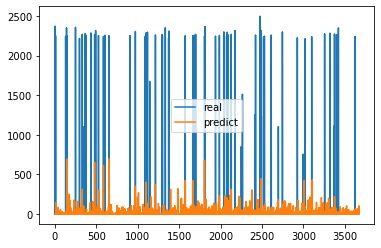

Epoch: 30; Test MAE loss on source data is: 30.066
Epoch: 30; Test MSE loss on source data is: 24025.250


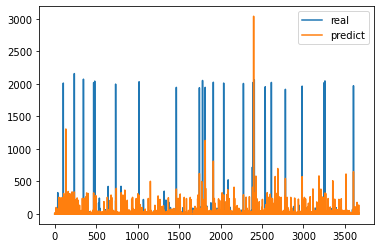

Epoch: 30; MSE loss: 7049410.213
46.87107074559059
75542.0032686276
Epoch: 31; MSE loss: 6108828.178
49.2612251504521
85662.06955178878
Epoch: 32; MSE loss: 7673339.373
52.86428561574089
77942.76616862621
Epoch: 33; MSE loss: 6790852.227
41.94655782494971
80671.48989384861
Epoch: 34; MSE loss: 7243769.424
43.56018209791872
82294.3517783762
Epoch: 35; MSE loss: 6699081.877
41.40553050611429
83028.32048167099
Epoch: 36; MSE loss: 6396645.085
41.518549727114106
85238.68612586978
Epoch: 37; MSE loss: 5811900.684
43.281109001656965
87797.82650342393
Epoch: 38; MSE loss: 6995603.573
52.133157303574556
87412.48604017858
Epoch: 39; MSE loss: 6568533.376
54.30070565945769
87125.17528294868
Epoch: 40; Test MAE loss on target data is: 54.301
Epoch: 40; Test MSE loss on target data is: 87125.175


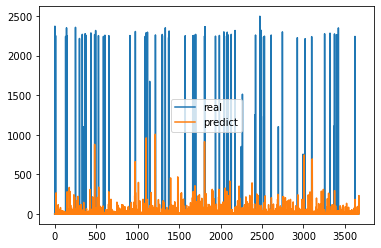

Epoch: 40; Test MAE loss on source data is: 35.832
Epoch: 40; Test MSE loss on source data is: 26030.045


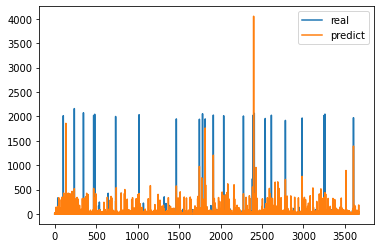

Epoch: 40; MSE loss: 7323244.550
42.547546010077795
87900.12548093358
Epoch: 41; MSE loss: 6295409.669
52.61692944166609
87968.14095121522
Epoch: 42; MSE loss: 6224622.238
42.241193288874804
88975.83513307721
Epoch: 43; MSE loss: 7182114.831
46.35271992039791
88275.13953168233
Epoch: 44; MSE loss: 6971415.553
47.73300390649771
88580.97469723751
Epoch: 45; MSE loss: 6388397.818
44.86338143794714
88859.7519002582
Epoch: 46; MSE loss: 7264243.688
45.489016306137266
88385.95582470277
Epoch: 47; MSE loss: 6802839.073
51.18104217985091
89246.04439979006
Epoch: 48; MSE loss: 6816085.595
49.08192686191439
88770.29260066665
Epoch: 49; MSE loss: 7375349.170
46.25922312563753
89179.43237916652
Epoch: 50; Test MAE loss on target data is: 46.259
Epoch: 50; Test MSE loss on target data is: 89179.432


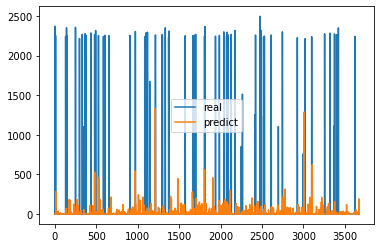

Epoch: 50; Test MAE loss on source data is: 22.123
Epoch: 50; Test MSE loss on source data is: 21938.122


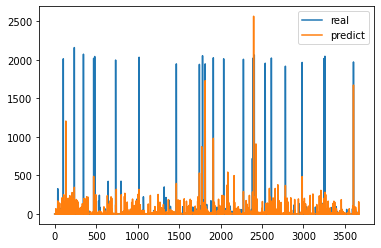

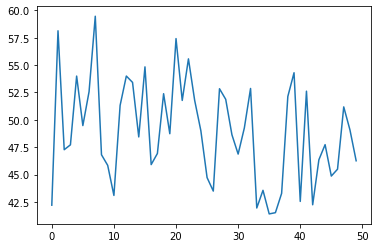

46.25922312563753
0.8324582536042496
1.0039758103848524


In [9]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.0001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="dynamic"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [29]:
trainfile1="F:/NILM/training_data/dishwasher_test_.csv"
trainfile2="F:/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"

fileList=[trainfile1,trainfile2]
stepsizeList=[2,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=10
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[19705, 19705]


house instance is: 0
Epoch: 0; MSE loss: 17461796.058
26.37569853038876
20922.56780792294
Epoch: 1; MSE loss: 15238280.131
34.168634908204965
20797.70747453109
Epoch: 2; MSE loss: 13191803.236
54.35539551108072
25390.576036975857
Epoch: 3; MSE loss: 13680879.389
59.37480067084063
27277.61157241302
Epoch: 4; MSE loss: 13154829.721
59.11397095634249
27555.216500233164
Epoch: 5; MSE loss: 13521899.917
48.51518388462368
23711.692288738228
Epoch: 6; MSE loss: 11596377.573
44.833573861797376
22980.4275633163
Epoch: 7; MSE loss: 13515305.034
77.25353261041457
38534.80849718262
Epoch: 8; MSE loss: 14045690.921
71.73459075152958
34812.16585014783
Epoch: 9; MSE loss: 12161851.202
64.12462422406976
30558.758746418924
Epoch: 10; Test MAE loss on target data is: 64.125
Epoch: 10; Test MSE loss on target data is: 30558.759


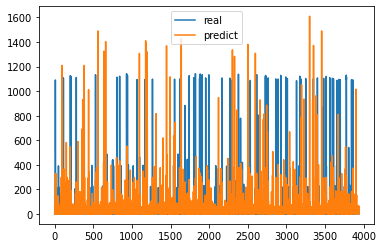

Epoch: 10; Test MAE loss on source data is: 77.980
Epoch: 10; Test MSE loss on source data is: 35736.021


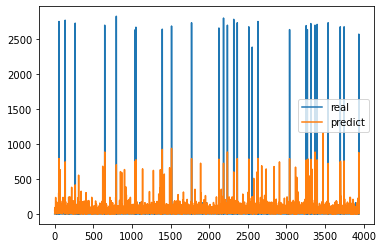

Epoch: 10; MSE loss: 12452484.550
50.47556665108196
26799.552334501124
Epoch: 11; MSE loss: 11854622.149
60.87391128248166
30243.016660677753
Epoch: 12; MSE loss: 11301581.396
57.320227895716286
30116.243299155125
Epoch: 13; MSE loss: 11336696.267
50.01160198762656
27711.368028049856
Epoch: 14; MSE loss: 12519010.364
71.91728462184946
41352.48506823693
Epoch: 15; MSE loss: 11532823.842
62.53054752490156
38396.10553224849
Epoch: 16; MSE loss: 12773758.298
50.952466160114426
31503.665002332516
Epoch: 17; MSE loss: 11591516.708
65.05596793470251
42236.434112140836
Epoch: 18; MSE loss: 11937123.158
44.866337897588906
28347.26712942547
Epoch: 19; MSE loss: 11876296.927
68.49194075503567
47513.60259988945
Epoch: 20; Test MAE loss on target data is: 68.492
Epoch: 20; Test MSE loss on target data is: 47513.603


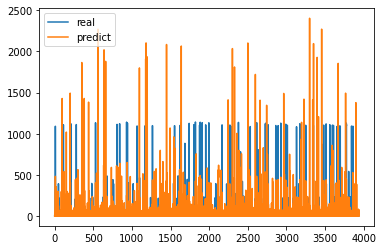

Epoch: 20; Test MAE loss on source data is: 84.639
Epoch: 20; Test MSE loss on source data is: 33662.728


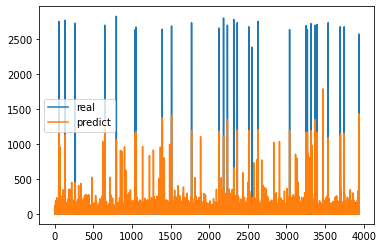

Epoch: 20; MSE loss: 10654790.865
66.42367053568327
49128.71560656554
Epoch: 21; MSE loss: 10289364.925
39.79027141459619
27687.831980563144


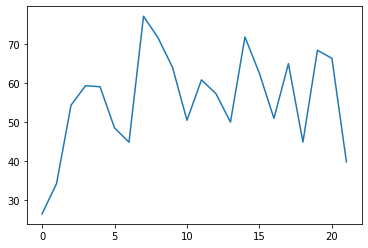

39.79027141459619
0.030632066113028954
1.1328487385843116


In [30]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.0001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/1000
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if(t>20 and stopT<45):
                break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 19049343.962
25.504599861531343
21009.280994288398
Epoch: 1; MSE loss: 13329273.984
54.167276619443186
24856.845875795578
Epoch: 2; MSE loss: 16886472.105
61.63507843220243
27838.3802521243
Epoch: 3; MSE loss: 16255703.928
53.33866956831348
24862.703628634095
Epoch: 4; MSE loss: 15628116.737
64.73800719567768
29508.891754043914
Epoch: 5; MSE loss: 14280039.245
56.46251818930186
26164.56301372444
Epoch: 6; MSE loss: 14375136.868
59.44833103105127
27463.36662038668
Epoch: 7; MSE loss: 16350100.674
56.98228377014573
26605.157527810174
Epoch: 8; MSE loss: 13814790.493
55.3573713271721
26240.99593945056
Epoch: 9; MSE loss: 13905218.684
45.4208730692177
23458.64945843891
Epoch: 10; Test MAE loss on target data is: 45.421
Epoch: 10; Test MSE loss on target data is: 23458.649


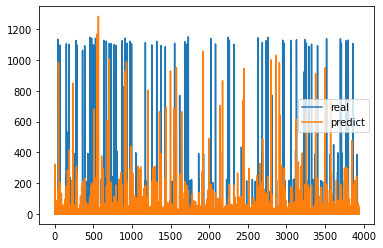

Epoch: 10; Test MAE loss on source data is: 59.876
Epoch: 10; Test MSE loss on source data is: 49604.137


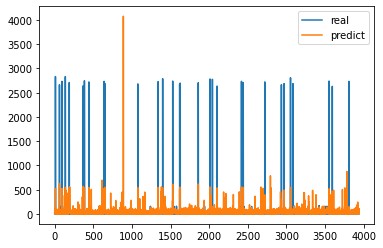

Epoch: 10; MSE loss: 16366166.476
61.650439970545044
30330.15979415319
Epoch: 11; MSE loss: 13578447.559
56.4436171127638
28127.735378972364
Epoch: 12; MSE loss: 14388649.216
64.52688528794349
32997.521716005125
Epoch: 13; MSE loss: 15987620.829
55.09231978537396
28670.58248629098
Epoch: 14; MSE loss: 13165883.796
59.083368031391075
31380.999343140928
Epoch: 15; MSE loss: 12584565.335
56.36500101684666
30908.86048300183
Epoch: 16; MSE loss: 14466165.133
48.30277387338181
27719.671883097602
Epoch: 17; MSE loss: 16042117.053
43.91310611638453
26022.71283448901
Epoch: 18; MSE loss: 14363550.728
44.18566507744343
26312.20260444946
Epoch: 19; MSE loss: 15529172.142
36.979562970871626
23919.98173300491
Epoch: 20; Test MAE loss on target data is: 36.980
Epoch: 20; Test MSE loss on target data is: 23919.982


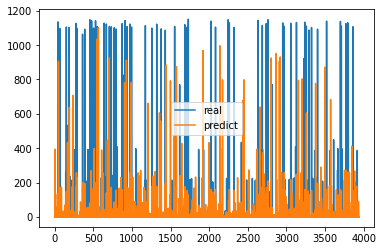

Epoch: 20; Test MAE loss on source data is: 40.975
Epoch: 20; Test MSE loss on source data is: 48491.603


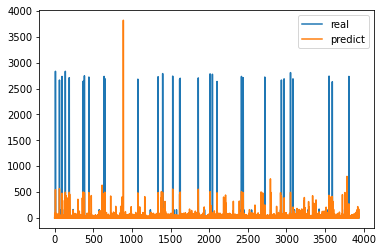

Epoch: 20; MSE loss: 14572065.203
53.77019741397455
33627.82985454284
Epoch: 21; MSE loss: 12156743.022
52.15629984207144
33466.20319176372
Epoch: 22; MSE loss: 14210687.671
62.687820161507126
42279.60433618953
Epoch: 23; MSE loss: 13146267.374
41.289086391440215
28703.35370622457
Epoch: 24; MSE loss: 15478579.348
44.63589807485531
31149.245307518402
Epoch: 25; MSE loss: 14964960.589
54.112787130615445
40036.8812528597
Epoch: 26; MSE loss: 15421519.058
52.76251713767588
39251.75717257619
Epoch: 27; MSE loss: 14127356.565
37.21740072913191
27464.968254737214
Epoch: 28; MSE loss: 13006885.961
48.5659203304057
37953.84443321093
Epoch: 29; MSE loss: 15773705.789
54.076697989566
49434.63859140803
Epoch: 30; Test MAE loss on target data is: 54.077
Epoch: 30; Test MSE loss on target data is: 49434.639


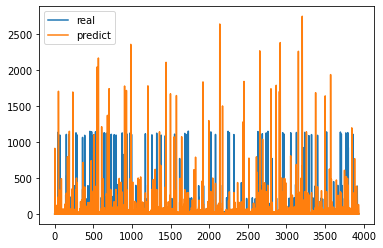

Epoch: 30; Test MAE loss on source data is: 63.538
Epoch: 30; Test MSE loss on source data is: 53880.786


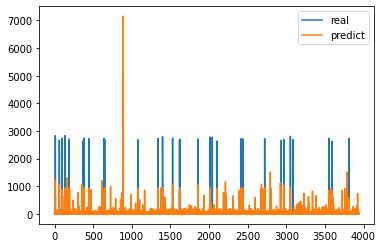

Epoch: 30; MSE loss: 14010561.354
58.964781726797064
49776.95291575846
Epoch: 31; MSE loss: 12750571.782
34.038729884504896
26004.04497323766
Epoch: 32; MSE loss: 14959151.163
39.2014899105678
31236.63617164724
Epoch: 33; MSE loss: 13898069.480
43.33754048458989
35848.78676401838
Epoch: 34; MSE loss: 12159375.644
41.90911814125521
35341.289915374065
Epoch: 35; MSE loss: 10749129.351
41.95070871347543
36300.14697154333
Epoch: 36; MSE loss: 13097005.685
39.311215735990196
33354.32761878241
Epoch: 37; MSE loss: 17046301.900
43.90564549856053
41392.1690316398
Epoch: 38; MSE loss: 13389756.047
40.73377549881702
36164.19710723182
Epoch: 39; MSE loss: 13969585.510
34.01924360130156
27953.87682808702
Epoch: 40; Test MAE loss on target data is: 34.019
Epoch: 40; Test MSE loss on target data is: 27953.877


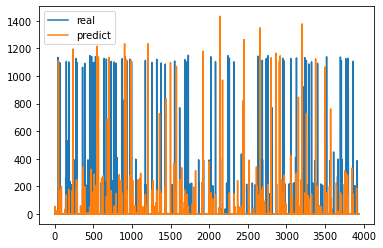

Epoch: 40; Test MAE loss on source data is: 28.225
Epoch: 40; Test MSE loss on source data is: 48344.222


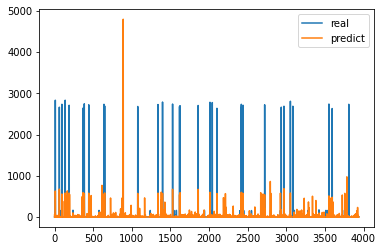

Epoch: 40; MSE loss: 13048761.431
40.89238418747726
36948.37241086939
Epoch: 41; MSE loss: 14231983.506
55.23560351250307
62959.959041339025
Epoch: 42; MSE loss: 14402296.911
34.993087878104625
29438.97941006909
Epoch: 43; MSE loss: 12586017.096
46.614000314616774
48471.08171959594
Epoch: 44; MSE loss: 13619585.682
46.39736224290613
49832.46383434029
Epoch: 45; MSE loss: 12707546.243
36.432777612249446
32862.10585812585
Epoch: 46; MSE loss: 13167844.479
46.42962061898071
57749.14217690355
Epoch: 47; MSE loss: 12994080.863
40.910093717079796
40026.93307406424
Epoch: 48; MSE loss: 12271392.318
48.553788582030194
62349.655998171715
Epoch: 49; MSE loss: 13995608.387
43.44654790587628
47842.9956214844
Epoch: 50; Test MAE loss on target data is: 43.447
Epoch: 50; Test MSE loss on target data is: 47842.996


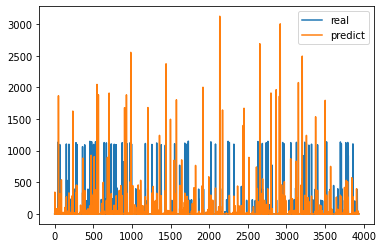

Epoch: 50; Test MAE loss on source data is: 39.790
Epoch: 50; Test MSE loss on source data is: 52571.855


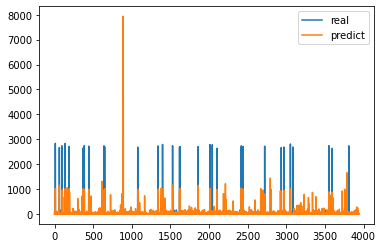

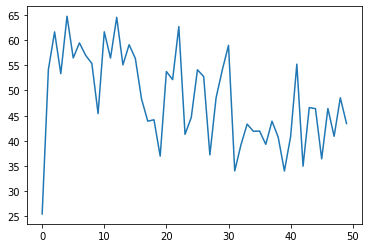

43.44654790587628
0.23242268311323677
1.4875772466498198


In [104]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.00001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="dynamic"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


In [26]:
# ######################################microwave###############################################################
#trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="/content/drive/MyDrive/training_data/microwave_house_3_training_.csv"

# trainfile2="/content/drive/MyDrive/ukdale_training/microwave_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="/content/drive/MyDrive/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile4="/content/drive/MyDrive/refit_training/microwave/microwave_house_17_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]

trainfile1="F:/NILM/training_data/microwave_test_.csv"
trainfile2="F:/NILM/refit_training/microwave/microwave_house_17_training_.csv"
fileList=[trainfile1,trainfile2]
stepsizeList=[2,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=200
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    X_on=X[Y>0]
    Y_on=Y[Y>0]
    X_off=X[Y==0]
    Y_off=Y[Y==0]
    ridx = np.random.choice(X_off.shape[0], int(len(Y_on)*50))
    X_off = X_off[ridx, :]
    Y_on=Y_on.reshape(-1,1)
    Y_off=Y_off.reshape(-1,1)
    Y_off = Y_off[ridx, :]
    X_pre=np.concatenate([X_on,X_off], axis=0)
    Y_pre=np.concatenate([Y_on,Y_off], axis=0)
    on.append(Y_on)
    data_insts.append(X_pre)
    data_labels.append(Y_pre)
    num_insts.append(X_pre.shape[0])
    # r_order = np.arange(num_insts[i])
    # np.random.shuffle(r_order)
    # data_insts[i] = data_insts[i][r_order, :]
    # data_labels[i] = data_labels[i][r_order,:]
print(num_insts)
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[13311, 10302]
[10302, 10302]


house instance is: 0
Epoch: 0; MSE loss: 5351136.892
29.848253050640317
38896.95254976834
Epoch: 1; MSE loss: 4761710.973
40.39945915693722
31907.09677317054
Epoch: 2; MSE loss: 4010035.074
32.37003232771689
32728.24296936588
Epoch: 3; MSE loss: 4168552.831
34.79546497699302
31454.62285862053
Epoch: 4; MSE loss: 4448897.769
37.93343594574377
30468.887084922728
Epoch: 5; MSE loss: 4440762.377
44.3593703435016
32346.394445506518
Epoch: 6; MSE loss: 4108257.670
39.2178346669255
31621.96519478657
Epoch: 7; MSE loss: 3560519.946
31.3372297769594
31776.61939616992
Epoch: 8; MSE loss: 3909751.079
36.09531727781844
31268.59729244975
Epoch: 9; MSE loss: 3907737.556
39.192199145561375
33169.72750856832
Epoch: 10; Test MAE loss on target data is: 39.192
Epoch: 10; Test MSE loss on target data is: 33169.728


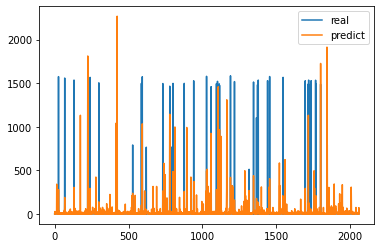

Epoch: 10; Test MAE loss on source data is: 40.185
Epoch: 10; Test MSE loss on source data is: 23782.053


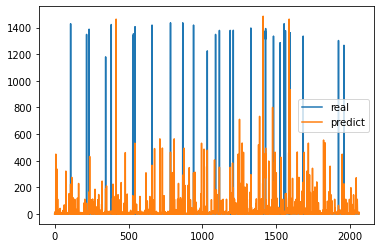

Epoch: 10; MSE loss: 3832521.398
41.75246936035724
33966.453013183724
Epoch: 11; MSE loss: 3869015.322
35.589309848611535
33141.47066165627
Epoch: 12; MSE loss: 3371051.901
40.127596050502824
36198.88042398357
Epoch: 13; MSE loss: 4038419.317
31.21641177818186
34844.706855133816
Epoch: 14; MSE loss: 3473739.440
32.19174157718075
34134.186344036265
Epoch: 15; MSE loss: 3136957.315
28.722600028251396
33344.782040802704
Epoch: 16; MSE loss: 3680844.077
36.75054095323497
35884.78282269174
Epoch: 17; MSE loss: 3407964.294
51.5668982937703
39094.83804103015
Epoch: 18; MSE loss: 3928304.746
34.06727427454875
33739.88172643618
Epoch: 19; MSE loss: 3355170.879
33.46588661231582
35810.614293107734
Epoch: 20; Test MAE loss on target data is: 33.466
Epoch: 20; Test MSE loss on target data is: 35810.614


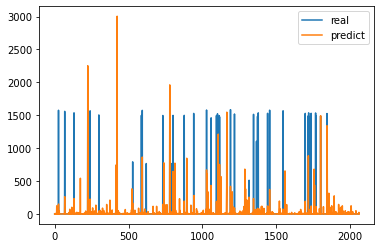

Epoch: 20; Test MAE loss on source data is: 29.048
Epoch: 20; Test MSE loss on source data is: 21702.252


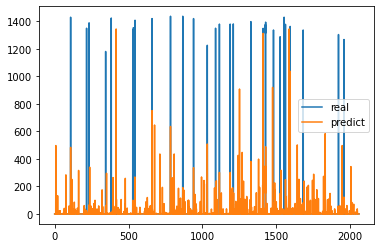

Epoch: 20; MSE loss: 3682624.545
36.81043502172806
32914.42646438916
Epoch: 21; MSE loss: 3030584.390
36.27177472598278
34768.38337620471
Epoch: 22; MSE loss: 3354792.255
36.094132331718846
35025.17569536669
Epoch: 23; MSE loss: 3353066.262
30.645850294278205
32813.62183536371
Epoch: 24; MSE loss: 2895814.510
34.99660320406047
34939.91436140228
Epoch: 25; MSE loss: 3067450.472
39.772579367559196
36399.028974952955
Epoch: 26; MSE loss: 3092608.049
32.74834689663757
31706.272233113676
Epoch: 27; MSE loss: 3152854.195
34.35727845455776
35315.76584898955
Epoch: 28; MSE loss: 2681296.997
38.59176577302728
43587.5923412795
Epoch: 29; MSE loss: 3222612.138
37.831689408219496
39227.96021117713
Epoch: 30; Test MAE loss on target data is: 37.832
Epoch: 30; Test MSE loss on target data is: 39227.960


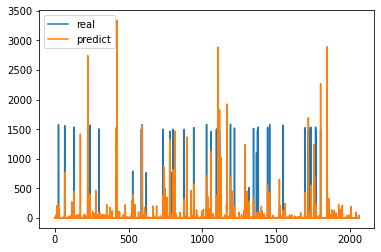

Epoch: 30; Test MAE loss on source data is: 32.199
Epoch: 30; Test MSE loss on source data is: 19578.801


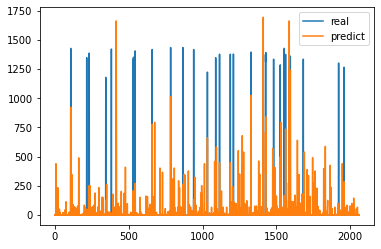

Epoch: 30; MSE loss: 3218782.748
39.88657060322538
40166.60201842205
Epoch: 31; MSE loss: 2779708.484
32.079605784673575
33827.80660113446
Epoch: 32; MSE loss: 3258012.912
30.534989032761217
30884.165644592507
Epoch: 33; MSE loss: 3047607.059
32.18191494755615
34052.64228554564
Epoch: 34; MSE loss: 3242979.705
29.347718628576786
32348.18489946604
Epoch: 35; MSE loss: 3058275.099
40.874127600975264
35803.46215983932
Epoch: 36; MSE loss: 3110368.190
38.570571926494864
38435.543535012235
Epoch: 37; MSE loss: 2899930.498
35.277614838679725
39092.814649198655
Epoch: 38; MSE loss: 2692418.298
32.759136323384325
36063.86006986659
Epoch: 39; MSE loss: 2677268.472
38.487359713626226
41271.08035771177
Epoch: 40; Test MAE loss on target data is: 38.487
Epoch: 40; Test MSE loss on target data is: 41271.080


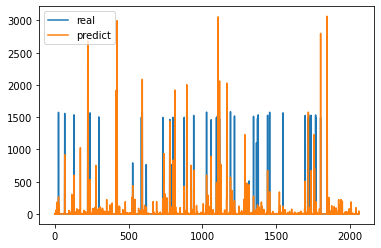

Epoch: 40; Test MAE loss on source data is: 28.882
Epoch: 40; Test MSE loss on source data is: 17078.617


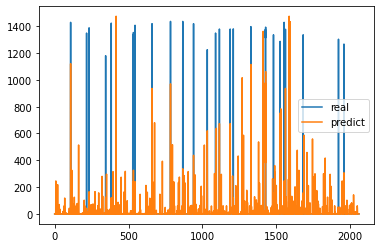

Epoch: 40; MSE loss: 2898929.370
33.08470687349213
37290.02717655741
Epoch: 41; MSE loss: 2320324.085
32.14826275279452
35374.91066905038
Epoch: 42; MSE loss: 2568166.486
30.904004285872684
35888.27228594263
Epoch: 43; MSE loss: 2896247.559
36.19771636617129
41310.9478485822
Epoch: 44; MSE loss: 2643961.614
38.40173407267226
41357.61126368229
Epoch: 45; MSE loss: 2844750.332
31.304926777748047
36661.30578825652
Epoch: 46; MSE loss: 2771959.070
30.61718424747151
34774.14278587071
Epoch: 47; MSE loss: 2503251.816
35.62533705265713
36147.5446986245
Epoch: 48; MSE loss: 2497637.330
33.152804227059335
37977.246665240316
Epoch: 49; MSE loss: 2201817.383
33.75100778902443
38678.53163527839
Epoch: 50; Test MAE loss on target data is: 33.751
Epoch: 50; Test MSE loss on target data is: 38678.532


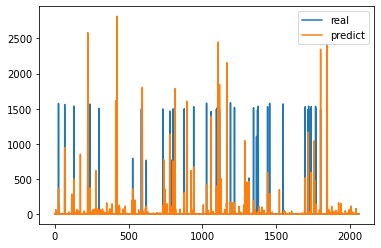

Epoch: 50; Test MAE loss on source data is: 22.306
Epoch: 50; Test MSE loss on source data is: 15851.918


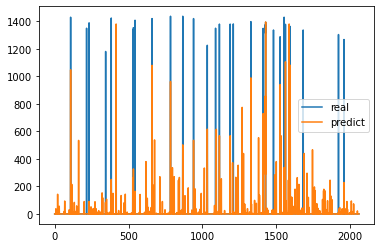

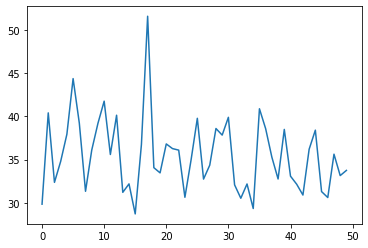

33.75100778902443
0.12249227092390147
0.9582111595088358


In [27]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.00001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="dynamic"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/500
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))


house instance is: 0
Epoch: 0; MSE loss: 5351114.440
29.84705967284049
38892.517321973726
Epoch: 1; MSE loss: 4761411.144
40.358578830807986
31904.024150653557
Epoch: 2; MSE loss: 4011355.167
32.41294587377508
32692.79945501245
Epoch: 3; MSE loss: 4169306.583
34.71780187976924
31430.092416525047
Epoch: 4; MSE loss: 4446697.050
37.69384914293605
30390.475215088394
Epoch: 5; MSE loss: 4443282.509
44.659490116555276
32385.140474172145
Epoch: 6; MSE loss: 4106772.423
39.170052525597015
31522.58638740584
Epoch: 7; MSE loss: 3563073.423
31.41279924963725
31768.182686532553
Epoch: 8; MSE loss: 3913529.724
35.831972397972464
31163.93300434642
Epoch: 9; MSE loss: 3909702.809
39.24605059849898
33109.89591178955
Epoch: 10; Test MAE loss on target data is: 39.246
Epoch: 10; Test MSE loss on target data is: 33109.896


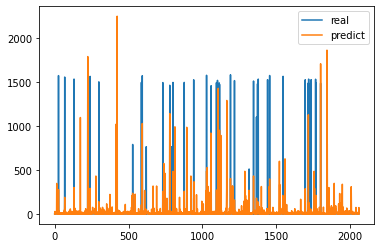

Epoch: 10; Test MAE loss on source data is: 40.187
Epoch: 10; Test MSE loss on source data is: 23737.915


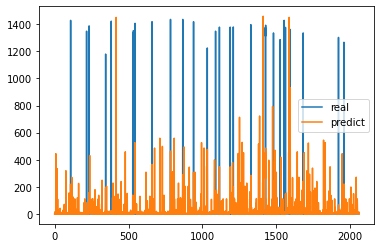

Epoch: 10; MSE loss: 3844617.987
41.09981132357151
33664.47955235653
Epoch: 11; MSE loss: 3876242.859
36.31312968114371
33190.92589692482
Epoch: 12; MSE loss: 3381254.931
39.52989064064344
36125.92064975632
Epoch: 13; MSE loss: 3963015.983
30.669212285012303
34426.396385960994
Epoch: 14; MSE loss: 3462607.605
31.633702836047476
34138.90982891046
Epoch: 15; MSE loss: 3097059.396
28.7224482150404
33246.3479734575
Epoch: 16; MSE loss: 3642188.195
43.54294552384542
37823.81783037539
Epoch: 17; MSE loss: 3468887.434
52.21053983150982
39757.92160063307
Epoch: 18; MSE loss: 4032869.943
34.43506132388409
36200.723777666666
Epoch: 19; MSE loss: 3322237.579
34.66628932107498
35079.35403307931
Epoch: 20; Test MAE loss on target data is: 34.666
Epoch: 20; Test MSE loss on target data is: 35079.354


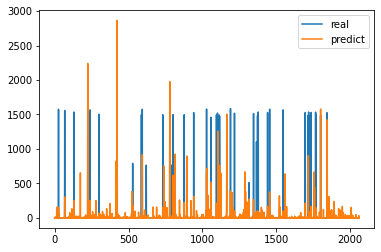

Epoch: 20; Test MAE loss on source data is: 30.771
Epoch: 20; Test MSE loss on source data is: 21419.733


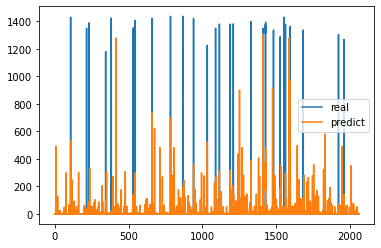

Epoch: 20; MSE loss: 3656644.291
35.3803250582019
33331.697348435715
Epoch: 21; MSE loss: 3018326.593
34.36289971891972
33550.10474920732
Epoch: 22; MSE loss: 3348711.474
36.445608662923675
35975.8018303316
Epoch: 23; MSE loss: 3336078.485
32.26220609396142
33502.24572590112
Epoch: 24; MSE loss: 2818603.583
42.289812900253104
40118.379254167936
Epoch: 25; MSE loss: 3049209.039
36.78924811454907
35358.07447944669
Epoch: 26; MSE loss: 3063011.632
32.333434999425315
31640.58494066656
Epoch: 27; MSE loss: 3187396.617
35.17213533862885
35271.87027843931
Epoch: 28; MSE loss: 2657089.555
39.11258853238709
44143.46403168192
Epoch: 29; MSE loss: 3196282.027
37.86843928629353
39112.51032632799
Epoch: 30; Test MAE loss on target data is: 37.868
Epoch: 30; Test MSE loss on target data is: 39112.510


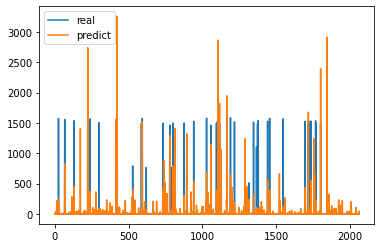

Epoch: 30; Test MAE loss on source data is: 32.208
Epoch: 30; Test MSE loss on source data is: 19558.821


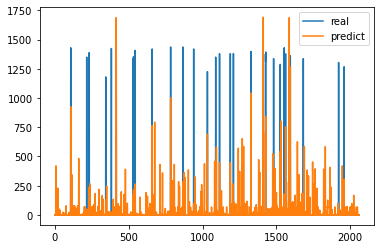

Epoch: 30; MSE loss: 3194713.394
39.55189659997107
39253.332802722136
Epoch: 31; MSE loss: 2761292.957
31.91375532988763
34179.06650034337
Epoch: 32; MSE loss: 3270157.258
30.792583120579824
30807.4956176608
Epoch: 33; MSE loss: 3084104.402
31.748300310336962
34583.84502974236
Epoch: 34; MSE loss: 3239561.525
29.599721018634956
32586.550031023977
Epoch: 35; MSE loss: 3035450.099
40.28906062409913
36376.6037407634
Epoch: 36; MSE loss: 3116104.019
38.41251152500205
40740.72167601032
Epoch: 37; MSE loss: 2853006.470
34.47250121081293
38620.841129291584
Epoch: 38; MSE loss: 2650791.835
35.783739325596
38329.120692565746
Epoch: 39; MSE loss: 2626220.890
38.734583982836
42021.89112186109
Epoch: 40; Test MAE loss on target data is: 38.735
Epoch: 40; Test MSE loss on target data is: 42021.891


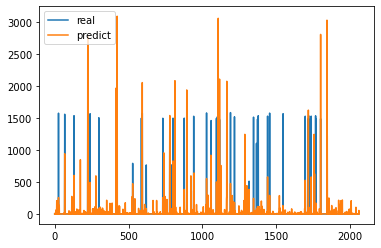

Epoch: 40; Test MAE loss on source data is: 28.466
Epoch: 40; Test MSE loss on source data is: 16932.327


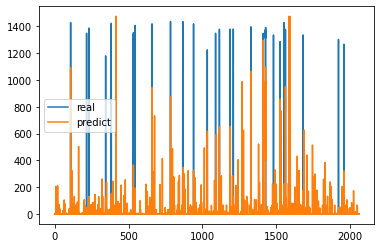

Epoch: 40; MSE loss: 2878739.173
34.24142795188656
38354.406857369555
Epoch: 41; MSE loss: 2259314.730
31.706578882568074
36840.241355800266
Epoch: 42; MSE loss: 2540066.308
31.196602309471228
35621.33402060216
Epoch: 43; MSE loss: 2798058.574
37.26954268564226
43025.530751636834
Epoch: 44; MSE loss: 2609534.157
38.74859488038121
43201.195834679565
Epoch: 45; MSE loss: 2734917.707
33.44268067609913
38762.303815636864
Epoch: 46; MSE loss: 2645228.272
31.50240972643432
37725.12616805772
Epoch: 47; MSE loss: 2419096.623
35.3307060708742
37297.15145201154
Epoch: 48; MSE loss: 2437341.857
33.475219929285046
39700.611716324514
Epoch: 49; MSE loss: 2162306.461
34.35949280658008
40038.142658385914
Epoch: 50; Test MAE loss on target data is: 34.359
Epoch: 50; Test MSE loss on target data is: 40038.143


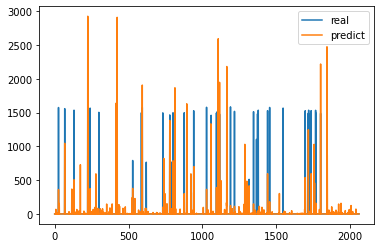

Epoch: 50; Test MAE loss on source data is: 21.543
Epoch: 50; Test MSE loss on source data is: 15474.955


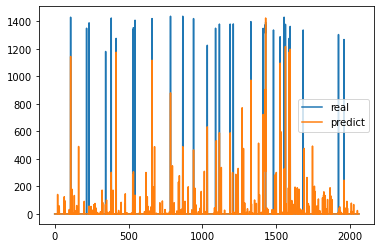

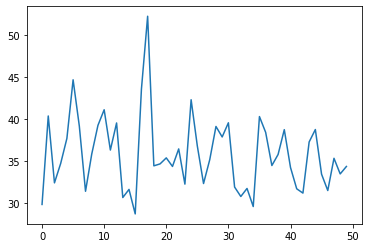

34.35949280658008
0.1012836729202717
0.9749070175285968


In [28]:
########################################################## Real code ####################################################################################
import matplotlib.pyplot as plt
import math
num_data_sets=len(fileList)


name="amazon"
epoch=200
batch_size=100
mu=0.2
mode="dynamic"
verbose=True
frac=1.0
seed=42
dimension=5000
model="mdan"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random number seed.
logger = get_logger(name)
np.random.seed(seed)
torch.manual_seed(seed)
# num_data_sets=1
if model == "mdan":
    configs = {"input_dim": 19, "hidden_layers": [1000, 500, 100], "num_classes": 2,
               "num_epochs": epoch, "batch_size": batch_size, "lr": 0.00002, "mu": mu, "num_domains":
                   num_data_sets - 1, "mode": mode, "gamma": 10.0, "verbose": verbose}
    num_domains = configs["num_domains"]
    error_dicts = {}
#     lr=0.2   #0.000001
    num_epochs=50
    b1=0.99
    b2=0.99
    lr = 0.0001
    batch_size = 64
    mu = 0.1
    gamma = 0.00001
    # X=np.concatenate(data_insts, axis=0)
    # Y=np.concatenate(data_labels, axis=0)
    for i in [0]:
        print("house instance is:", i)
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        # Train DannNet.
        mdan = MDANet(configs).to(device)
        #optimizer = optim.Adadelta(mdan.parameters(), lr=lr)
        optimizer = torch.optim.Adam(mdan.parameters(), lr=lr, betas=(b1, b2))
        # logger.info("network's parameters: {}".format(mdan.parameters))
        mdan.train()
        # Training phase.
        mae_loss,mse_loss=[],[]
        for t in range(num_epochs):
            running_loss = 0.0
            train_loader = multi_data_loader(source_insts, source_labels, batch_size)
            for xs, ys in train_loader:
                slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
                for j in range(num_domains):
                    xs[j]= xs[j].reshape(xs[j].shape[0],1,xs[j].shape[1])
                    xs[j] = torch.tensor(xs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    ys[j] = torch.tensor(ys[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                tinputs = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                y_spred, y_tpred, sdomains, tdomains = mdan(sinputs=xs, tinputs=tinputs)
#                 print(logprobs[0])
                # Compute prediction accuracy on multiple training sources. 
                criterion = nn.MSELoss()
                losses = torch.stack([criterion(y_spred[j], ys[j]) for j in range(num_domains)])
                domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                           F.nll_loss(tdomains[j], tlabels) for j in range(num_domains)])
                # print("mse error is:{}".format(losses))
                # print("domain error is:{}".format(domain_losses))
#                 loss_energy=float(torch.mean(losses))

                if(t<10):
                  mode="no-weight"
                else:
                  mode="DANNJMMD"
#                 mode="no-weight"
               # Different final loss function depending on different training modes.
                if mode == "maxmin":
                    loss = torch.max(losses) + mu *10* torch.min(domain_losses)
                elif mode == "dynamic":
                    loss = torch.log(torch.sum(torch.exp(gamma * (losses + mu * domain_losses)))) / gamma
                elif mode=='no-weight':
                    loss = torch.mean(losses)
                elif mode=='DANN':
                    loss = torch.mean(losses) + 10 * torch.mean(domain_losses)
                elif mode=='DANN0':
                    loss=weighted_mse(losses,mdan.alpha) + weighted_mse(domain_losses,mdan.alpha)
                elif mode=="DANNJMMD":
                    sourceList=[]
                    for i in range(num_domains):
                        z_sfeat=mdan.extract(xs[i])
                        sourceList.append([z_sfeat,y_spred[i]])           
                    z_tfeat=mdan.extract(tinputs)
                    targetList=[z_tfeat,y_tpred]
                    loss_jmmd=weighted_jmmd(sourceList, targetList)
                    lamda=math.log(t+1)/(math.log(num_epochs)**2)*loss_energy/200
                    loss= torch.mean(losses) + lamda* (torch.mean(domain_losses) + loss_jmmd)
                else:
                    raise ValueError("No support for the training mode on madnNet: {}.".format(mode))
                running_loss += loss.item()
                loss.backward()
                optimizer.step()     
#             logger.info("Iteration {}, loss = {}".format(t, running_loss)) 
#             print(loss_energy)
            loss_energy=float(torch.mean(losses))
            print('Epoch: %i; MSE loss: %.3f'%(t, running_loss))
            mdan.eval()
            prediction=mdan.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
#             if(stopT<32):
#                 break;   
            if (t+1)%10==0:
                mdan.eval()
                prediction=mdan.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = mdan.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=mdan.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(t+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(t+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        mdan.eval()
        prediction=mdan.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
